In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import os
from tqdm import tqdm
import pickle

In [2]:
# Carregar o drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#High - 50 trials_1 n_layers': 2, 'n_units_lstm1': 156, 'n_units_lstm2': 165, 'dropout_rate_lstm1': 0.28092475924593174, 'dropout_rate_lstm2': 0.002139485189729312, 'activation_lstm1': 'relu', 'activation_lstm2': 'sigmoid', 'n_units_dense': 31, 'activation_dense': 'relu', 'optimizer': 'adam', 'lookback': 3, 'batch_size': 16, 'learning_rate': 0.00258889006067603}
#High - 50 trials_2 'n_layers': 1, 'n_units_lstm1': 101, 'dropout_rate_lstm1': 0.4570536925674341, 'activation_lstm1': 'tanh', 'n_units_dense': 59, 'activation_dense': 'sigmoid', 'optimizer': 'adam', 'lookback': 9, 'batch_size': 16, 'learning_rate': 0.005911055455196886
# Low - 50Trials 'n_layers': 1, 'n_units_lstm1': 163, 'dropout_rate_lstm1': 0.090164301026192, 'activation_lstm1': 'tanh', 'n_units_dense': 22, 'activation_dense': 'tanh', 'optimizer': 'adam', 'lookback': 9, 'batch_size': 32, 'learning_rate': 0.0067414385784827086
#Volume - 50Trials n_layers': 2, 'n_units_lstm1': 237, 'n_units_lstm2': 256, 'dropout_rate_lstm1': 0.0412901953075126, 'dropout_rate_lstm2': 0.4529453045893003, 'activation_lstm1': 'relu', 'activation_lstm2': 'tanh', 'n_units_dense': 63, 'activation_dense': 'tanh', 'optimizer': 'rmsprop', 'lookback': 7, 'batch_size': 32, 'learning_rate': 0.002980802463636748
#USD - 50 Trials n_layers': 3, 'n_units_lstm1': 201, 'n_units_lstm2': 83, 'n_units_lstm3': 256, 'dropout_rate_lstm1': 0.06537458387369367, 'dropout_rate_lstm2': 0.2674145645248178, 'dropout_rate_lstm3': 0.23975742893255256, 'activation_lstm1': 'sigmoid', 'activation_lstm2': 'relu', 'activation_lstm3': 'sigmoid', 'n_units_dense': 40, 'activation_dense': 'tanh', 'optimizer': 'rmsprop', 'lookback': 15, 'batch_size': 16, 'learning_rate': 0.008137268840506761


In [ ]:
# Definição de hiperparametros *Melhores apos 50 trials do optuna

n_layers = 1
n_units_lstm1 = 163
dropout_rate_lstm1 = 0.090164301026192
activation_lstm1 = 'tanh'
n_units_dense = 22
activation_dense = 'tanh'
optimizer = 'adam'
lookback = 9
batch_size = 32
learning_rate = 0.0067414385784827086


In [3]:
# Carregar o arquivo CSV sem índice e com a coluna 'Date' no formato datetime
df = pd.read_csv(
    "/content/drive/MyDrive/Mestrado/df_indice_brasil_endogenous_exogenous_red1.csv",
    sep=',',
    parse_dates=['Date'],  # Converte a coluna 'Date' para datetime
    index_col=None         # Não define uma coluna de índice
)

# Visualizar as primeiras linhas para confirmar o carregamento
df.head()


,Unnamed: 0,Date,Close,High,Low,Volume,USD
0,0,2013-01-02,62550.10,62887.0,60990.0,3739800.0,2.0456
1,1,2013-01-03,63312.46,63473.0,62341.0,3355800.0,2.0456
2,2,2013-01-04,62523.06,63314.0,62415.0,6233800.0,2.0487
3,3,2013-01-07,61932.54,62699.0,61639.0,3985800.0,2.0324
4,4,2013-01-08,61127.84,62265.0,61081.0,3840600.0,2.0264


In [4]:
#carregar base de dados
# Selecionar apenas as colunas desejadas
df = df[['Date', 'Close', 'High', 'Low', 'Volume', 'USD']]

# Verificar as informações do DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2724 non-null   datetime64[ns]
 1   Close   2724 non-null   float64       
 2   High    2724 non-null   float64       
 3   Low     2724 non-null   float64       
 4   Volume  2724 non-null   float64       
 5   USD     2724 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 127.8 KB


In [5]:
#separação dos dados em treino, validação e teste
train_size = int(len(df['Close']) * 0.75)
val_size = int(len(df['Close']) * 0.85)

df_train = df.iloc[:train_size].copy()
df_test = df.iloc[val_size:].copy()

In [6]:
# Função para salvar os melhores resultados

def save_model(model, optimizer, metrics, seed, filename='bestresults'):
    # Salvar o modelo e suas métricas
    model.save(filename + '.keras')
    with open(filename + '.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
        f.write(f'Seed: {seed}\n')  # Salvar a seed

    # Salvar o otimizador
    with open(filename + '_optimizer.pkl', 'wb') as f:
        pickle.dump(optimizer.get_config(), f)

In [7]:
# Criação de diretório e salvar modelos e history
patience=10
runs=100
results_dir = f'/content/drive/MyDrive/Mestrado/Resultados/Exogenous/LSTM_p{patience}_bestresults'

best_model = None
best_history = None
best_mape = float('inf')
all_metrics = []
all_history = []

In [ ]:
'''# Normalização das colunas 'Close' e ''Low'' no conjunto de treino
train_mean = df_train[['Close', 'Low']].mean().values
train_std = df_train[['Close', 'Low']].std().values

train_not_norm = df_train[['Close', 'Low']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

# Normalização do conjunto de treino
train_norm = (train_not_norm - train_mean) / train_std


# Normalização do conjunto de teste
test_mean = df_train[['Close', 'Low']].mean().values
test_std = df_train[['Close', 'Low']].std().values
test_norm = (test_not_norm - test_mean) / test_std



# Preparação dos dados de treino e teste com exógena ''Low''
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],  # Target continua sendo 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],  # Target continua sendo 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)'''



##1 camada

In [ ]:
# Normalização das colunas 'Close' e 'High' no conjunto de treino
train_mean = df_train[['Close', 'Low']].mean().values
train_std = df_train[['Close', 'Low']].std().values

train_not_norm = df_train[['Close', 'Low']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

# Normalização do conjunto de treino e teste
train_norm = (train_not_norm - train_mean) / train_std
test_norm = (test_not_norm - train_mean) / train_std  # usa stats de treino

# Preparação dos dados de treino e validação com exógena 'High'
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Configuração para múltiplos runs
all_metrics = []
all_history = []

# Criação do diretório de resultados
os.makedirs(results_dir, exist_ok=True)

# Loop para os múltiplos runs
for run_num in tqdm(range(runs)):
    # Definir seed para reprodutibilidade
    seed = run_num
    np.random.seed(seed)
    tf.random.set_seed(seed)

    print(f"\nStarting Run {run_num} with seed {seed}")

    # Definir e compilar o modelo LSTM
    model = Sequential()
    model.add(LSTM(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 2), return_sequences=False))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))

    # Compilar o modelo
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mae')

    # Callback de early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fazer previsões
    val_predict = model.predict(val_dataset)
    # Desnormalizar as previsões de 'Close'
    predict = (val_predict * train_std[0]) + train_mean[0]

    # Ajustar y_real e y_predict para o cálculo de métricas
    y_real = test_not_norm[lookback:, 0]  # 'Close' desnormalizado
    y_predict = predict.squeeze()

    # Ajustar o tamanho de y_predict
    if len(y_real) != len(y_predict):
        y_predict = y_predict[:len(y_real)]

    # Calcular métricas
    mae = mean_absolute_error(y_real, y_predict)
    mse = mean_squared_error(y_real, y_predict)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_predict) / np.clip(y_real, 1e-10, None))) * 100
    r2 = r2_score(y_real, y_predict)

    # Exibir e armazenar métricas
    print(f"Run {run_num}, Seed {seed}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

    # Salvar histórico e métricas
    run_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Run': run_num}
    all_metrics.append(run_metrics)
    all_history.append(history.history)

# Salvar métricas e histórico
np.save(os.path.join(results_dir, "all_metrics.npy"), all_metrics)
np.save(os.path.join(results_dir, "all_history.npy"), all_history)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting Run 0 with seed 0
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.2068 - val_loss: 0.3299
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1157 - val_loss: 0.1912
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0807 - val_loss: 0.2700
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0750 - val_loss: 0.1253
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0864 - val_loss: 0.1408
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0654 - val_loss: 0.1781
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0596 - val_loss: 0.1555
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0797 - val_loss: 0.1018
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0706 - val_loss: 0.1992
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0513 - val_loss: 0.1697
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0671 - val_loss: 0.0639
Epoch 12/200
64/64 ━━━━━

  1%|          | 1/100 [00:56<1:33:03, 56.40s/it]

Run 0, Seed 0
MAE: 1420.5857164062502, MSE: 3649922.3237474645, RMSE: 1910.4769885417265, MAPE: 1.2445073240974753, R2: 0.9381307961541728

Starting Run 1 with seed 1
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1913 - val_loss: 0.2335
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1050 - val_loss: 0.0790
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0850 - val_loss: 0.2442
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0674 - val_loss: 0.0749
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1028 - val_loss: 0.0880
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1004 - val_loss: 0.2094
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0496 - val_loss: 0.2025
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0517 - val_loss: 0.2265
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0438 - val_loss: 0.1418
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0516 - val_loss: 0.1740
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0746 - val_loss: 0.2703
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

  2%|▏         | 2/100 [01:51<1:30:43, 55.54s/it]

Run 1, Seed 1
MAE: 1478.7390187500005, MSE: 4077902.6839014376, RMSE: 2019.3817578411065, MAPE: 1.2834246731267396, R2: 0.9308761748785095

Starting Run 2 with seed 2
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1880 - val_loss: 0.3835
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1086 - val_loss: 0.0885
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0903 - val_loss: 0.0718
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0757 - val_loss: 0.1668
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0456 - val_loss: 0.1914
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0574 - val_loss: 0.2249
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0619 - val_loss: 0.2416
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0592 - val_loss: 0.1766
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0482 - val_loss: 0.1784
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0662 - val_loss: 0.1307
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0782 - val_loss: 0.1851
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0

  3%|▎         | 3/100 [02:45<1:28:43, 54.88s/it]

Run 2, Seed 2
MAE: 1343.1886851562504, MSE: 3167480.5308850254, RMSE: 1779.7417034179498, MAPE: 1.1786798491407278, R2: 0.9463085837832823

Starting Run 3 with seed 3
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1952 - val_loss: 0.1087
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1047 - val_loss: 0.2565
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1060 - val_loss: 0.2558
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0618 - val_loss: 0.2036
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0660 - val_loss: 0.1532
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0769 - val_loss: 0.1209
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0659 - val_loss: 0.1837
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0665 - val_loss: 0.2277
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0634 - val_loss: 0.0827
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0615 - val_loss: 0.0654
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0608 - val_loss: 0.0691
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

  4%|▍         | 4/100 [03:49<1:33:47, 58.62s/it]

Run 3, Seed 3
MAE: 1442.17587421875, MSE: 3450368.8759932523, RMSE: 1857.5168575259963, MAPE: 1.2821599299601165, R2: 0.9415133922321537

Starting Run 4 with seed 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2013 - val_loss: 0.2807
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1366 - val_loss: 0.2891
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1268 - val_loss: 0.1554
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1090 - val_loss: 0.2098
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0889 - val_loss: 0.1001
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0944 - val_loss: 0.1117
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0943 - val_loss: 0.1338
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0985 - val_loss: 0.1402
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1424 - val_loss: 0.1022
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1777 - val_loss: 0.0963
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1816 - val_loss: 0.1704
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1

  5%|▌         | 5/100 [05:04<1:42:11, 64.54s/it]

Run 4, Seed 4
MAE: 1577.7926898437506, MSE: 4510106.7330734655, RMSE: 2123.7011873315573, MAPE: 1.3851853931682532, R2: 0.9235499585787168

Starting Run 5 with seed 5
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1977 - val_loss: 0.3962
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1098 - val_loss: 0.0838
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1139 - val_loss: 0.2044
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0590 - val_loss: 0.1481
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0751 - val_loss: 0.0711
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0775 - val_loss: 0.1533
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0742 - val_loss: 0.0770
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0602 - val_loss: 0.1669
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0605 - val_loss: 0.1366
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0647 - val_loss: 0.1827
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0538 - val_loss: 0.0605
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

  6%|▌         | 6/100 [06:02<1:37:35, 62.30s/it]

Run 5, Seed 5
MAE: 1311.7892843750003, MSE: 2717504.904543466, RMSE: 1648.4856397747194, MAPE: 1.1739898672568394, R2: 0.9539360430227973

Starting Run 6 with seed 6
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1929 - val_loss: 0.1206
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0853 - val_loss: 0.0909
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1153 - val_loss: 0.2712
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0862 - val_loss: 0.2270
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0527 - val_loss: 0.1682
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0774 - val_loss: 0.2235
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0561 - val_loss: 0.1779
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0817 - val_loss: 0.0779
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0840 - val_loss: 0.0854
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0629 - val_loss: 0.1052
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0575 - val_loss: 0.0802
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

  7%|▋         | 7/100 [07:20<1:44:28, 67.41s/it]

Run 6, Seed 6
MAE: 1511.3263117187503, MSE: 4471268.407051553, RMSE: 2114.537397884358, MAPE: 1.318915088054503, R2: 0.9242083003450734

Starting Run 7 with seed 7
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.2055 - val_loss: 0.1152
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1194 - val_loss: 0.1712
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1033 - val_loss: 0.1676
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0963 - val_loss: 0.0831
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0753 - val_loss: 0.0594
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0588 - val_loss: 0.2109
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0550 - val_loss: 0.0625
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0622 - val_loss: 0.0634
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0730 - val_loss: 0.1482
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0890 - val_loss: 0.1596
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0736 - val_loss: 0.1702
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

  8%|▊         | 8/100 [07:57<1:28:29, 57.72s/it]

Run 7, Seed 7
MAE: 1321.3973984375002, MSE: 2879039.6197055513, RMSE: 1696.773296497075, MAPE: 1.1730362851296658, R2: 0.9511978959242915

Starting Run 8 with seed 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2017 - val_loss: 0.0978
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2054 - val_loss: 0.2333
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0964 - val_loss: 0.0838
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0898 - val_loss: 0.1891
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0765 - val_loss: 0.1358
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0901 - val_loss: 0.2063
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0735 - val_loss: 0.1465
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0495 - val_loss: 0.0739
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0673 - val_loss: 0.0592
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0599 - val_loss: 0.1537
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0448 - val_loss: 0.0690
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0

  9%|▉         | 9/100 [08:41<1:21:06, 53.48s/it]

Run 8, Seed 8
MAE: 1315.6815601562505, MSE: 3022212.6335078645, RMSE: 1738.4512168904437, MAPE: 1.158596345961985, R2: 0.9487709948588842

Starting Run 9 with seed 9
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1912 - val_loss: 0.1370
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1471 - val_loss: 0.3174
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1173 - val_loss: 0.1218
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1059 - val_loss: 0.2192
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0756 - val_loss: 0.2330
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0487 - val_loss: 0.1192
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0819 - val_loss: 0.1364
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1006 - val_loss: 0.0925
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0663 - val_loss: 0.1737
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1069 - val_loss: 0.0759
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0703 - val_loss: 0.1799
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1

 10%|█         | 10/100 [10:12<1:37:17, 64.86s/it]

Run 9, Seed 9
MAE: 1533.0086335937503, MSE: 4514032.545389419, RMSE: 2124.625271757215, MAPE: 1.3414412770119055, R2: 0.923483412811193

Starting Run 10 with seed 10
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1969 - val_loss: 0.0951
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1126 - val_loss: 0.1633
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1071 - val_loss: 0.1945
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0681 - val_loss: 0.1102
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0599 - val_loss: 0.1467
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0666 - val_loss: 0.0842
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0594 - val_loss: 0.1622
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0461 - val_loss: 0.0697
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0689 - val_loss: 0.1890
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0688 - val_loss: 0.1139
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0642 - val_loss: 0.0995
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0

 11%|█         | 11/100 [11:01<1:29:06, 60.07s/it]

Run 10, Seed 10
MAE: 1549.2840078125, MSE: 3836650.024037594, RMSE: 1958.7368439985996, MAPE: 1.3890259650681835, R2: 0.9349656071095328

Starting Run 11 with seed 11


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.2022 - val_loss: 0.0804
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0842 - val_loss: 0.1003
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1050 - val_loss: 0.2832
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0911 - val_loss: 0.0813
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0831 - val_loss: 0.1615
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0512 - val_loss: 0.1374
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0745 - val_loss: 0.1542
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0665 - val_loss: 0.1316
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0620 - val_loss: 0.1797
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0651 - val_loss: 0.0653
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0637 - val_loss: 0.1919
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

 12%|█▏        | 12/100 [12:09<1:31:50, 62.62s/it]

Run 11, Seed 11
MAE: 1325.3679898437504, MSE: 3057788.5132402503, RMSE: 1748.6533427870288, MAPE: 1.1663533340571823, R2: 0.9481679542569412

Starting Run 12 with seed 12
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1937 - val_loss: 0.0735
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0781 - val_loss: 0.0647
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0950 - val_loss: 0.0760
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0882 - val_loss: 0.1011
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1026 - val_loss: 0.2861
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0881 - val_loss: 0.1117
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0869 - val_loss: 0.2141
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0546 - val_loss: 0.2985
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0668 - val_loss: 0.0845
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0563 - val_loss: 0.1830
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0502 - val_loss: 0.1878
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 13%|█▎        | 13/100 [12:41<1:17:17, 53.30s/it]

Run 12, Seed 12
MAE: 1437.4166234375007, MSE: 3234010.2660285006, RMSE: 1798.3354153295488, MAPE: 1.2641626546635116, R2: 0.9451808497165545

Starting Run 13 with seed 13
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1897 - val_loss: 0.1212
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1293 - val_loss: 0.1640
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1025 - val_loss: 0.1632
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0711 - val_loss: 0.1039
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0757 - val_loss: 0.1986
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0663 - val_loss: 0.0905
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0569 - val_loss: 0.0831
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0600 - val_loss: 0.0686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0551 - val_loss: 0.0696
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0545 - val_loss: 0.1563
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0477 - val_loss: 0.0899
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 14%|█▍        | 14/100 [13:40<1:18:59, 55.11s/it]

Run 13, Seed 13
MAE: 1407.0998156250002, MSE: 3695026.2656500465, RMSE: 1922.2451107104023, MAPE: 1.2232686174149539, R2: 0.9373662470135884

Starting Run 14 with seed 14
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2135 - val_loss: 0.1013
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1475 - val_loss: 0.2050
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0890 - val_loss: 0.2226
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0608 - val_loss: 0.1505
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0831 - val_loss: 0.1660
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0716 - val_loss: 0.2117
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0803 - val_loss: 0.0783
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0674 - val_loss: 0.0753
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0589 - val_loss: 0.1711
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0567 - val_loss: 0.1420
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0524 - val_loss: 0.0631
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 15%|█▌        | 15/100 [14:31<1:16:02, 53.68s/it]

Run 14, Seed 14
MAE: 1402.4827343750005, MSE: 3543683.5856746067, RMSE: 1882.4674195519578, MAPE: 1.234362658779218, R2: 0.9399316306813593

Starting Run 15 with seed 15
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.2165 - val_loss: 0.0713
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1080 - val_loss: 0.2192
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0883 - val_loss: 0.2231
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0746 - val_loss: 0.0713
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0738 - val_loss: 0.1678
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0556 - val_loss: 0.2133
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0612 - val_loss: 0.0735
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0742 - val_loss: 0.0973
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0627 - val_loss: 0.2091
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0652 - val_loss: 0.0729
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0738 - val_loss: 0.1522
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 16%|█▌        | 16/100 [15:07<1:07:41, 48.35s/it]

Run 15, Seed 15
MAE: 1584.92858125, MSE: 3734766.9658565754, RMSE: 1932.554518210696, MAPE: 1.4426457167793285, R2: 0.9366926092580513

Starting Run 16 with seed 16
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1931 - val_loss: 0.0848
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1161 - val_loss: 0.0922
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1082 - val_loss: 0.0890
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1182 - val_loss: 0.2256
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0610 - val_loss: 0.1720
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0558 - val_loss: 0.1788
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0836 - val_loss: 0.2094
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0656 - val_loss: 0.1720
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0693 - val_loss: 0.0793
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0641 - val_loss: 0.0630
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0591 - val_loss: 0.1366
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0

 17%|█▋        | 17/100 [15:58<1:08:13, 49.32s/it]

Run 16, Seed 16
MAE: 1401.2511359375005, MSE: 3281091.221430721, RMSE: 1811.3782656945846, MAPE: 1.2423484046285815, R2: 0.9443827885610925

Starting Run 17 with seed 17
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1932 - val_loss: 0.2248
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0986 - val_loss: 0.0923
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1056 - val_loss: 0.3247
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0725 - val_loss: 0.1311
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0882 - val_loss: 0.1935
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0643 - val_loss: 0.0767
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0864 - val_loss: 0.2196
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0752 - val_loss: 0.1802
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0549 - val_loss: 0.0886
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0672 - val_loss: 0.1048
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0653 - val_loss: 0.0649
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 18%|█▊        | 18/100 [17:09<1:16:05, 55.67s/it]

Run 17, Seed 17
MAE: 1423.9305710937506, MSE: 3609493.6086325347, RMSE: 1899.8667344402172, MAPE: 1.2449653983117677, R2: 0.9388160963317673

Starting Run 18 with seed 18
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1940 - val_loss: 0.1066
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1327 - val_loss: 0.0927
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0970 - val_loss: 0.2424
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0528 - val_loss: 0.2031
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0677 - val_loss: 0.0763
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0766 - val_loss: 0.0752
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0798 - val_loss: 0.1866
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0547 - val_loss: 0.1490
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0534 - val_loss: 0.0626
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0595 - val_loss: 0.0873
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0599 - val_loss: 0.1376
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0

 19%|█▉        | 19/100 [18:09<1:17:04, 57.10s/it]

Run 18, Seed 18
MAE: 1224.3520500000004, MSE: 2551464.3168327976, RMSE: 1597.33037184948, MAPE: 1.0790492725956495, R2: 0.9567505683897933

Starting Run 19 with seed 19
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2032 - val_loss: 0.1669
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1011 - val_loss: 0.1056
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1393 - val_loss: 0.1060
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1033 - val_loss: 0.1869
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0629 - val_loss: 0.1963
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0669 - val_loss: 0.0784
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0668 - val_loss: 0.0617
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0553 - val_loss: 0.0619
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0544 - val_loss: 0.1392
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0561 - val_loss: 0.1403
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0556 - val_loss: 0.0625
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0

 20%|██        | 20/100 [18:53<1:10:44, 53.05s/it]

Run 19, Seed 19
MAE: 1371.4441921875002, MSE: 3192043.6945968107, RMSE: 1786.6291429943738, MAPE: 1.2133992525472128, R2: 0.9458922178313564

Starting Run 20 with seed 20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1825 - val_loss: 0.2041
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1266 - val_loss: 0.2826
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0729 - val_loss: 0.2411
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0820 - val_loss: 0.2012
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0844 - val_loss: 0.0882
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0737 - val_loss: 0.2310
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0811 - val_loss: 0.1833
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0574 - val_loss: 0.1207
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0608 - val_loss: 0.0850
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0634 - val_loss: 0.0788
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0648 - val_loss: 0.0863
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step

 21%|██        | 21/100 [19:43<1:08:51, 52.29s/it]

Run 20, Seed 20
MAE: 1496.2266906250004, MSE: 4291509.1017809305, RMSE: 2071.595786291556, MAPE: 1.2972429523365743, R2: 0.9272553693275042

Starting Run 21 with seed 21
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1851 - val_loss: 0.1254
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1044 - val_loss: 0.1196
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1325 - val_loss: 0.1076
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0506 - val_loss: 0.1233
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0722 - val_loss: 0.0907
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1028 - val_loss: 0.1079
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0666 - val_loss: 0.0819
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0581 - val_loss: 0.1478
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0685 - val_loss: 0.0645
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0677 - val_loss: 0.0725
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0619 - val_loss: 0.0702
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 22%|██▏       | 22/100 [20:58<1:16:51, 59.12s/it]

Run 21, Seed 21
MAE: 1384.3980265625003, MSE: 3371780.043405405, RMSE: 1836.2407367786514, MAPE: 1.2152563660122722, R2: 0.9428455379799544

Starting Run 22 with seed 22
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.1889 - val_loss: 0.1368
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1036 - val_loss: 0.1205
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1301 - val_loss: 0.1496
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0930 - val_loss: 0.1227
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0709 - val_loss: 0.1546
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0798 - val_loss: 0.0686
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0673 - val_loss: 0.1297
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0580 - val_loss: 0.0623
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0557 - val_loss: 0.1093
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0670 - val_loss: 0.1002
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0485 - val_loss: 0.0597
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 23%|██▎       | 23/100 [21:50<1:13:05, 56.95s/it]

Run 22, Seed 22
MAE: 1326.6143234375004, MSE: 2959992.3252252783, RMSE: 1720.4628229709813, MAPE: 1.1751984683688919, R2: 0.949825680574095

Starting Run 23 with seed 23
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1882 - val_loss: 0.1030
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1214 - val_loss: 0.1440
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1073 - val_loss: 0.1065
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0755 - val_loss: 0.1456
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0887 - val_loss: 0.0771
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0749 - val_loss: 0.0682
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0695 - val_loss: 0.0869
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0656 - val_loss: 0.0646
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0613 - val_loss: 0.1052
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0679 - val_loss: 0.1517
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0672 - val_loss: 0.0743
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 24%|██▍       | 24/100 [22:35<1:07:19, 53.16s/it]

Run 23, Seed 23
MAE: 1435.9064234375005, MSE: 3671719.2633830053, RMSE: 1916.173077616687, MAPE: 1.2495565567576237, R2: 0.9377613199895015

Starting Run 24 with seed 24
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1979 - val_loss: 0.1605
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0968 - val_loss: 0.0795
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1020 - val_loss: 0.1355
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0842 - val_loss: 0.1533
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0562 - val_loss: 0.2179
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0616 - val_loss: 0.0979
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0720 - val_loss: 0.2099
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0613 - val_loss: 0.1014
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0691 - val_loss: 0.1585
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0691 - val_loss: 0.0867
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0666 - val_loss: 0.1510
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 25%|██▌       | 25/100 [23:07<58:43, 46.98s/it]  

Run 24, Seed 24
MAE: 1766.9568000000006, MSE: 5150308.467240318, RMSE: 2269.4291060177047, MAPE: 1.5508350843220238, R2: 0.912698009391767

Starting Run 25 with seed 25
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1863 - val_loss: 0.2054
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0855 - val_loss: 0.0721
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1076 - val_loss: 0.1037
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1096 - val_loss: 0.1013
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0761 - val_loss: 0.2339
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0713 - val_loss: 0.1680
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0635 - val_loss: 0.0825
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0705 - val_loss: 0.0782
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0535 - val_loss: 0.1083
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0533 - val_loss: 0.1312
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0448 - val_loss: 0.0720
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 26%|██▌       | 26/100 [24:08<1:03:02, 51.12s/it]

Run 25, Seed 25
MAE: 1457.2906976562506, MSE: 4009156.3758741855, RMSE: 2002.287785477948, MAPE: 1.2655597502269555, R2: 0.9320414816899211

Starting Run 26 with seed 26
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.3069 - val_loss: 0.2563
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1900 - val_loss: 0.0919
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1312 - val_loss: 0.2687
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1572 - val_loss: 0.4099
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1473 - val_loss: 0.0612
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0526 - val_loss: 0.1719
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0473 - val_loss: 0.1074
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1092 - val_loss: 0.1798
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0633 - val_loss: 0.1354
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0510 - val_loss: 0.1820
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0435 - val_loss: 0.0702
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 27%|██▋       | 27/100 [24:48<58:04, 47.74s/it]  

Run 26, Seed 26
MAE: 1361.5376007812501, MSE: 2869742.7226754413, RMSE: 1694.0314999064926, MAPE: 1.2268092027443802, R2: 0.9513554860225101

Starting Run 27 with seed 27
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1922 - val_loss: 0.0799
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1313 - val_loss: 0.1129
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0888 - val_loss: 0.0955
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0697 - val_loss: 0.2714
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0690 - val_loss: 0.1636
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0643 - val_loss: 0.0823
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0751 - val_loss: 0.0748
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0542 - val_loss: 0.0617
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0573 - val_loss: 0.1438
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0558 - val_loss: 0.1018
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0645 - val_loss: 0.0584
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0

 28%|██▊       | 28/100 [25:43<59:54, 49.93s/it]

Run 27, Seed 27
MAE: 1298.0629726562502, MSE: 2816086.2041060454, RMSE: 1678.1198419975985, MAPE: 1.151037106917741, R2: 0.9522650084152

Starting Run 28 with seed 28
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2827 - val_loss: 0.0683
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1744 - val_loss: 0.0723
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1765 - val_loss: 0.2783
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1645 - val_loss: 0.1226
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1389 - val_loss: 0.1125
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0731 - val_loss: 0.1264
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0687 - val_loss: 0.2574
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0587 - val_loss: 0.1668
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0595 - val_loss: 0.0761
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0608 - val_loss: 0.1860
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0601 - val_loss: 0.0734
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


 29%|██▉       | 29/100 [26:12<51:45, 43.74s/it]

Run 28, Seed 28
MAE: 1517.6771218750007, MSE: 3515760.381938364, RMSE: 1875.0361015026788, MAPE: 1.345069562796352, R2: 0.9404049520922687

Starting Run 29 with seed 29
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1872 - val_loss: 0.1513
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1374 - val_loss: 0.1458
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1232 - val_loss: 0.2701
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0799 - val_loss: 0.1751
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0677 - val_loss: 0.1386
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1042 - val_loss: 0.1909
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0669 - val_loss: 0.0897
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0771 - val_loss: 0.0821
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0631 - val_loss: 0.1551
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0570 - val_loss: 0.0733
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0526 - val_loss: 0.0913
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0

 30%|███       | 30/100 [27:02<53:06, 45.52s/it]

Run 29, Seed 29
MAE: 1628.6628382812505, MSE: 5125689.595573929, RMSE: 2263.9985855945074, MAPE: 1.4076501996507012, R2: 0.9131153196396241

Starting Run 30 with seed 30
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2016 - val_loss: 0.1175
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0813 - val_loss: 0.0890
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0971 - val_loss: 0.2758
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0790 - val_loss: 0.1404
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0799 - val_loss: 0.1575
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0609 - val_loss: 0.2104
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0608 - val_loss: 0.1155
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0772 - val_loss: 0.1890
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0448 - val_loss: 0.1503
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0762 - val_loss: 0.0796
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0797 - val_loss: 0.1421
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0

 31%|███       | 31/100 [27:52<53:46, 46.76s/it]

Run 30, Seed 30
MAE: 1362.49501484375, MSE: 2885473.339701602, RMSE: 1698.6681075776992, MAPE: 1.2200388453864157, R2: 0.951088839046195

Starting Run 31 with seed 31
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1885 - val_loss: 0.0986
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1300 - val_loss: 0.0882
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0925 - val_loss: 0.2336
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0548 - val_loss: 0.2480
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0623 - val_loss: 0.2157
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0405 - val_loss: 0.1689
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0757 - val_loss: 0.1628
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0612 - val_loss: 0.0868
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0714 - val_loss: 0.0900
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0618 - val_loss: 0.0653
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0684 - val_loss: 0.0656
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 32%|███▏      | 32/100 [28:37<52:41, 46.50s/it]

Run 31, Seed 31
MAE: 1452.0428304687503, MSE: 3606851.791604495, RMSE: 1899.1713434033527, MAPE: 1.2845371914592358, R2: 0.9388608773166031

Starting Run 32 with seed 32
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.2830 - val_loss: 0.3252
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2006 - val_loss: 0.2981
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1705 - val_loss: 0.2391
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1203 - val_loss: 0.1564
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1313 - val_loss: 0.0983
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1700 - val_loss: 0.1302
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1427 - val_loss: 0.1215
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1557 - val_loss: 0.1509
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2236 - val_loss: 0.1177
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1976 - val_loss: 0.1475
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1586 - val_loss: 0.1086
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1

 33%|███▎      | 33/100 [29:35<55:38, 49.82s/it]

Run 32, Seed 32
MAE: 1726.4220710937502, MSE: 5505070.248745206, RMSE: 2346.2886115619294, MAPE: 1.5234158669709548, R2: 0.9066845036155402

Starting Run 33 with seed 33
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1976 - val_loss: 0.1330
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1187 - val_loss: 0.1130
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0869 - val_loss: 0.2458
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0927 - val_loss: 0.1912
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0685 - val_loss: 0.1062
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0707 - val_loss: 0.1842
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0541 - val_loss: 0.1892
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0747 - val_loss: 0.0737
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0665 - val_loss: 0.1593
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0473 - val_loss: 0.0813
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0682 - val_loss: 0.0898
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

 34%|███▍      | 34/100 [30:53<1:04:04, 58.24s/it]

Run 33, Seed 33
MAE: 1453.7534562500005, MSE: 3835622.4189881687, RMSE: 1958.4745132342593, MAPE: 1.2679775804017912, R2: 0.9349830258655053

Starting Run 34 with seed 34
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.2059 - val_loss: 0.2145
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1895 - val_loss: 0.4882
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1267 - val_loss: 0.1324
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0995 - val_loss: 0.1070
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1010 - val_loss: 0.0939
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0945 - val_loss: 0.1872
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0764 - val_loss: 0.0937
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0631 - val_loss: 0.1412
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0650 - val_loss: 0.1388
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0740 - val_loss: 0.0887
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1036 - val_loss: 0.1535
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

 35%|███▌      | 35/100 [32:02<1:06:34, 61.45s/it]

Run 34, Seed 34
MAE: 1636.0849679687503, MSE: 5488986.56008461, RMSE: 2342.858629982742, MAPE: 1.415265895558187, R2: 0.90695713544824

Starting Run 35 with seed 35
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2092 - val_loss: 0.1167
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1266 - val_loss: 0.2105
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1032 - val_loss: 0.3428
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0782 - val_loss: 0.1745
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0755 - val_loss: 0.1940
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0768 - val_loss: 0.1768
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0726 - val_loss: 0.0949
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0584 - val_loss: 0.0824
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0541 - val_loss: 0.1326
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0565 - val_loss: 0.0720
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0572 - val_loss: 0.1322
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 36%|███▌      | 36/100 [32:51<1:01:40, 57.82s/it]

Run 35, Seed 35
MAE: 1600.0940976562501, MSE: 4984143.837866946, RMSE: 2232.5196164573663, MAPE: 1.385136541434134, R2: 0.9155146373675953

Starting Run 36 with seed 36
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1926 - val_loss: 0.1131
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1248 - val_loss: 0.2733
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0792 - val_loss: 0.1283
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1279 - val_loss: 0.2268
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0660 - val_loss: 0.1485
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0773 - val_loss: 0.1345
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0593 - val_loss: 0.1642
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0607 - val_loss: 0.1208
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0651 - val_loss: 0.1928
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0444 - val_loss: 0.0792
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0750 - val_loss: 0.1484
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 37%|███▋      | 37/100 [34:02<1:04:51, 61.77s/it]

Run 36, Seed 36
MAE: 1470.6790507812502, MSE: 3680518.075561441, RMSE: 1918.4676373505604, MAPE: 1.3025130332350277, R2: 0.9376121728417042

Starting Run 37 with seed 37
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1841 - val_loss: 0.3088
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2675 - val_loss: 0.3905
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2027 - val_loss: 0.1930
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1742 - val_loss: 0.1139
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1360 - val_loss: 0.1001
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1712 - val_loss: 0.1288
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2270 - val_loss: 0.1131
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2652 - val_loss: 0.1344
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.2475 - val_loss: 0.0760
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2138 - val_loss: 0.0752
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2031 - val_loss: 0.0750
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 38%|███▊      | 38/100 [34:59<1:02:08, 60.14s/it]

Run 37, Seed 37
MAE: 1660.1463953124999, MSE: 5699025.078462009, RMSE: 2387.2630936832265, MAPE: 1.4460380391809908, R2: 0.9033968087463762

Starting Run 38 with seed 38


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1977 - val_loss: 0.0819
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1100 - val_loss: 0.0993
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1418 - val_loss: 0.0861
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1074 - val_loss: 0.1553
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0652 - val_loss: 0.1195
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0732 - val_loss: 0.1239
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0790 - val_loss: 0.2443
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0546 - val_loss: 0.1492
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0581 - val_loss: 0.0759
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0587 - val_loss: 0.0669
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0532 - val_loss: 0.0788
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

 39%|███▉      | 39/100 [35:58<1:00:55, 59.93s/it]

Run 38, Seed 38
MAE: 1476.5800070312503, MSE: 3521316.659537087, RMSE: 1876.5171620683589, MAPE: 1.3178921528354715, R2: 0.940310768588926

Starting Run 39 with seed 39
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1987 - val_loss: 0.2413
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1227 - val_loss: 0.1778
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0761 - val_loss: 0.1630
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0812 - val_loss: 0.1572
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0669 - val_loss: 0.0923
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0791 - val_loss: 0.1351
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0573 - val_loss: 0.1721
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0640 - val_loss: 0.1860
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0465 - val_loss: 0.1233
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0722 - val_loss: 0.1832
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0811 - val_loss: 0.1449
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 40%|████      | 40/100 [37:08<1:02:55, 62.92s/it]

Run 39, Seed 39
MAE: 1344.5872312500005, MSE: 3282902.2070926, RMSE: 1811.8780883637287, MAPE: 1.1768784024942094, R2: 0.9443520908554598

Starting Run 40 with seed 40
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1885 - val_loss: 0.1116
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0932 - val_loss: 0.2609
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0945 - val_loss: 0.1716
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0559 - val_loss: 0.1203
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0815 - val_loss: 0.3123
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0642 - val_loss: 0.0846
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0696 - val_loss: 0.1961
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0770 - val_loss: 0.2206
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0529 - val_loss: 0.1172
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0753 - val_loss: 0.1399
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0620 - val_loss: 0.0869
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 41%|████      | 41/100 [38:36<1:09:25, 70.60s/it]

Run 40, Seed 40
MAE: 1605.9765046875004, MSE: 4790915.98846279, RMSE: 2188.816115726214, MAPE: 1.4021772927490166, R2: 0.9187900093188544

Starting Run 41 with seed 41
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1954 - val_loss: 0.0990
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0881 - val_loss: 0.0957
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1077 - val_loss: 0.1124
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0728 - val_loss: 0.2641
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0720 - val_loss: 0.1403
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0710 - val_loss: 0.1220
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0623 - val_loss: 0.0996
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0659 - val_loss: 0.1103
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0680 - val_loss: 0.1675
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0563 - val_loss: 0.0673
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0652 - val_loss: 0.0630
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 42%|████▏     | 42/100 [39:32<1:04:00, 66.21s/it]

Run 41, Seed 41
MAE: 1283.5642656250002, MSE: 2744645.771222726, RMSE: 1656.6972479070296, MAPE: 1.1373376048619814, R2: 0.9534759828724192

Starting Run 42 with seed 42
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2076 - val_loss: 0.3044
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1123 - val_loss: 0.1293
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0986 - val_loss: 0.0798
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1100 - val_loss: 0.0841
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0906 - val_loss: 0.1115
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0572 - val_loss: 0.0921
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0511 - val_loss: 0.1788
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0738 - val_loss: 0.1119
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0600 - val_loss: 0.1070
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0488 - val_loss: 0.0832
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0646 - val_loss: 0.1494
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

 43%|████▎     | 43/100 [40:38<1:02:50, 66.15s/it]

Run 42, Seed 42
MAE: 1257.84835703125, MSE: 2478647.979162686, RMSE: 1574.3722492354489, MAPE: 1.1266697830055152, R2: 0.9579848655717654

Starting Run 43 with seed 43
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.2090 - val_loss: 0.1373
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0851 - val_loss: 0.0681
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1153 - val_loss: 0.2071
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0780 - val_loss: 0.0747
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1295 - val_loss: 0.2752
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0727 - val_loss: 0.0849
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0524 - val_loss: 0.0795
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0613 - val_loss: 0.2239
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0481 - val_loss: 0.1494
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0784 - val_loss: 0.0913
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0538 - val_loss: 0.1506
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0

 44%|████▍     | 44/100 [41:41<1:00:48, 65.15s/it]

Run 43, Seed 43
MAE: 1175.3253679687505, MSE: 2275926.3604200226, RMSE: 1508.6173671345637, MAPE: 1.0425994849623372, R2: 0.9614211647697902

Starting Run 44 with seed 44


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1869 - val_loss: 0.1318
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1038 - val_loss: 0.1218
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0945 - val_loss: 0.2100
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0696 - val_loss: 0.2133
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0701 - val_loss: 0.2065
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0782 - val_loss: 0.1014
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0702 - val_loss: 0.0881
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0735 - val_loss: 0.0726
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0626 - val_loss: 0.0997
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0503 - val_loss: 0.1467
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0796 - val_loss: 0.1550
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step

 45%|████▌     | 45/100 [42:29<54:59, 59.98s/it]  

Run 44, Seed 44
MAE: 1614.039875, MSE: 4157395.6556927334, RMSE: 2038.9692630573745, MAPE: 1.4449533240029808, R2: 0.9295287032229986

Starting Run 45 with seed 45
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1988 - val_loss: 0.1730
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1131 - val_loss: 0.0980
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1028 - val_loss: 0.0889
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1026 - val_loss: 0.1653
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0693 - val_loss: 0.1329
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0654 - val_loss: 0.1502
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0582 - val_loss: 0.1303
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0629 - val_loss: 0.0917
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0644 - val_loss: 0.1780
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0431 - val_loss: 0.1486
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0668 - val_loss: 0.1295
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 46%|████▌     | 46/100 [43:02<46:34, 51.74s/it]

Run 45, Seed 45
MAE: 1977.4640124999999, MSE: 5858552.7028768025, RMSE: 2420.4447324565795, MAPE: 1.800251932099515, R2: 0.9006926834969857

Starting Run 46 with seed 46
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.1899 - val_loss: 0.1023
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1086 - val_loss: 0.0869
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1183 - val_loss: 0.2439
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0860 - val_loss: 0.1424
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0706 - val_loss: 0.1785
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0528 - val_loss: 0.0953
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0644 - val_loss: 0.1450
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0588 - val_loss: 0.0982
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0692 - val_loss: 0.1198
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0753 - val_loss: 0.1392
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0664 - val_loss: 0.0878
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 47%|████▋     | 47/100 [43:59<47:08, 53.37s/it]

Run 46, Seed 46
MAE: 1525.5753382812504, MSE: 4177184.894249711, RMSE: 2043.8162574580208, MAPE: 1.3347560127871094, R2: 0.9291932592530627

Starting Run 47 with seed 47
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.3112 - val_loss: 0.2062
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2019 - val_loss: 0.2116
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1274 - val_loss: 0.1366
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1438 - val_loss: 0.1545
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0710 - val_loss: 0.1575
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0972 - val_loss: 0.1186
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1241 - val_loss: 0.1391
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1675 - val_loss: 0.0945
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1820 - val_loss: 0.1026
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1616 - val_loss: 0.1454
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1196 - val_loss: 0.1061
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1

 48%|████▊     | 48/100 [45:30<56:03, 64.69s/it]

Run 47, Seed 47
MAE: 1658.3504648437502, MSE: 5664375.425157853, RMSE: 2379.994837212437, MAPE: 1.439655032307214, R2: 0.9039841490438708

Starting Run 48 with seed 48
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2026 - val_loss: 0.1066
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.1110 - val_loss: 0.1108
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1019 - val_loss: 0.0831
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0938 - val_loss: 0.0992
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0623 - val_loss: 0.1386
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0414 - val_loss: 0.1632
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0845 - val_loss: 0.1242
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0732 - val_loss: 0.0739
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0645 - val_loss: 0.0812
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0591 - val_loss: 0.0873
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0641 - val_loss: 0.0607
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 49%|████▉     | 49/100 [46:40<56:15, 66.18s/it]

Run 48, Seed 48
MAE: 1282.9568273437505, MSE: 2834983.32535131, RMSE: 1683.7408723884178, MAPE: 1.1252119035083141, R2: 0.9519446865719609

Starting Run 49 with seed 49
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2099 - val_loss: 0.1484
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1524 - val_loss: 0.2570
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0904 - val_loss: 0.1606
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0924 - val_loss: 0.1787
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0840 - val_loss: 0.0769
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0632 - val_loss: 0.1092
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0962 - val_loss: 0.1376
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0704 - val_loss: 0.1736
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0663 - val_loss: 0.1106
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0572 - val_loss: 0.0800
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0580 - val_loss: 0.1373
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0

 50%|█████     | 50/100 [47:13<46:59, 56.40s/it]

Run 49, Seed 49
MAE: 1709.4254234375, MSE: 5483452.495071395, RMSE: 2341.6772824348354, MAPE: 1.5015720387716018, R2: 0.9070509424298765

Starting Run 50 with seed 50
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1893 - val_loss: 0.2410
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1134 - val_loss: 0.0751
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1125 - val_loss: 0.0886
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1204 - val_loss: 0.2496
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0827 - val_loss: 0.0924
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0516 - val_loss: 0.1075
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0656 - val_loss: 0.1055
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0584 - val_loss: 0.1570
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0488 - val_loss: 0.1939
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0455 - val_loss: 0.0691
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0700 - val_loss: 0.0813
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 51%|█████     | 51/100 [48:06<45:11, 55.34s/it]

Run 50, Seed 50
MAE: 1260.5918859375006, MSE: 2720263.2229148773, RMSE: 1649.322049484235, MAPE: 1.1123932998041242, R2: 0.9538892872437819

Starting Run 51 with seed 51
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1889 - val_loss: 0.1078
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0941 - val_loss: 0.1139
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1271 - val_loss: 0.1366
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0758 - val_loss: 0.2902
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0627 - val_loss: 0.2727
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0840 - val_loss: 0.0762
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0658 - val_loss: 0.0791
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0621 - val_loss: 0.0740
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0648 - val_loss: 0.0911
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0813 - val_loss: 0.1510
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0734 - val_loss: 0.0838
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0

 52%|█████▏    | 52/100 [48:47<40:48, 51.02s/it]

Run 51, Seed 51
MAE: 1645.3328937500005, MSE: 5238456.83571173, RMSE: 2288.767536407254, MAPE: 1.4170048531456065, R2: 0.9112038215998374

Starting Run 52 with seed 52
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1903 - val_loss: 0.1901
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1047 - val_loss: 0.0568
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0770 - val_loss: 0.2682
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0931 - val_loss: 0.0862
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0910 - val_loss: 0.1555
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0774 - val_loss: 0.1647
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0670 - val_loss: 0.2181
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0626 - val_loss: 0.1123
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0622 - val_loss: 0.1007
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0637 - val_loss: 0.0645
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0586 - val_loss: 0.0814
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 53%|█████▎    | 53/100 [49:18<35:21, 45.14s/it]

Run 52, Seed 52
MAE: 1262.01962890625, MSE: 2437763.9985733675, RMSE: 1561.3340445187787, MAPE: 1.128431815975646, R2: 0.9586778828759015

Starting Run 53 with seed 53
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1929 - val_loss: 0.2498
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0922 - val_loss: 0.0935
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0905 - val_loss: 0.0892
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0713 - val_loss: 0.1024
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0500 - val_loss: 0.1716
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0752 - val_loss: 0.1470
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0680 - val_loss: 0.1831
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0581 - val_loss: 0.0722
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0657 - val_loss: 0.1662
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0652 - val_loss: 0.0752
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0651 - val_loss: 0.0657
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0

 54%|█████▍    | 54/100 [50:12<36:38, 47.80s/it]

Run 53, Seed 53
MAE: 1460.3619515625, MSE: 3340611.1459911224, RMSE: 1827.733882705883, MAPE: 1.306366292557966, R2: 0.9433738765846494

Starting Run 54 with seed 54
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2115 - val_loss: 0.2639
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2180 - val_loss: 0.4039
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1053 - val_loss: 0.1933
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1306 - val_loss: 0.2382
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0735 - val_loss: 0.1300
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0595 - val_loss: 0.1006
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0801 - val_loss: 0.0814
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0704 - val_loss: 0.0996
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0849 - val_loss: 0.1328
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1072 - val_loss: 0.1306
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1490 - val_loss: 0.0896
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 55%|█████▌    | 55/100 [51:15<39:07, 52.16s/it]

Run 54, Seed 54
MAE: 1568.2929070312507, MSE: 4722001.513024246, RMSE: 2173.016684939222, MAPE: 1.3621171722439245, R2: 0.9199581667070527

Starting Run 55 with seed 55
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.2001 - val_loss: 0.1326
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1182 - val_loss: 0.1565
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1149 - val_loss: 0.0836
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0977 - val_loss: 0.0746
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0728 - val_loss: 0.1564
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0580 - val_loss: 0.0784
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0711 - val_loss: 0.1312
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0773 - val_loss: 0.1669
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0587 - val_loss: 0.1593
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0484 - val_loss: 0.1695
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0610 - val_loss: 0.0721
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 56%|█████▌    | 56/100 [52:11<39:09, 53.39s/it]

Run 55, Seed 55
MAE: 1350.1495742187503, MSE: 2826319.331974649, RMSE: 1681.1660631759876, MAPE: 1.2107348364593087, R2: 0.9520915484295002

Starting Run 56 with seed 56
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1882 - val_loss: 0.1745
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1155 - val_loss: 0.2111
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0857 - val_loss: 0.2041
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0983 - val_loss: 0.1951
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0794 - val_loss: 0.0989
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0703 - val_loss: 0.1792
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0733 - val_loss: 0.1713
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0662 - val_loss: 0.0931
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0582 - val_loss: 0.0735
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0644 - val_loss: 0.0653
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0582 - val_loss: 0.0951
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0

 57%|█████▋    | 57/100 [53:07<38:47, 54.12s/it]

Run 56, Seed 56
MAE: 1432.4798976562504, MSE: 3697487.6711183996, RMSE: 1922.8852464768665, MAPE: 1.2535582944814465, R2: 0.9373245241539871

Starting Run 57 with seed 57
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1900 - val_loss: 0.0856
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1376 - val_loss: 0.2280
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0712 - val_loss: 0.1572
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0835 - val_loss: 0.1659
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0818 - val_loss: 0.1291
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0591 - val_loss: 0.1338
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0644 - val_loss: 0.1298
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0606 - val_loss: 0.0709
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0690 - val_loss: 0.0839
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0521 - val_loss: 0.1173
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0493 - val_loss: 0.1072
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0

 58%|█████▊    | 58/100 [54:04<38:36, 55.15s/it]

Run 57, Seed 57
MAE: 1335.724878125, MSE: 2825950.1128743617, RMSE: 1681.0562491702535, MAPE: 1.192664896976492, R2: 0.9520978069987938

Starting Run 58 with seed 58
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.2208 - val_loss: 0.0952
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1508 - val_loss: 0.0988
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1205 - val_loss: 0.2240
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0860 - val_loss: 0.1850
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0663 - val_loss: 0.1039
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0763 - val_loss: 0.0729
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0587 - val_loss: 0.0788
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0894 - val_loss: 0.1288
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0630 - val_loss: 0.1810
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0524 - val_loss: 0.0762
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0574 - val_loss: 0.1179
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

 59%|█████▉    | 59/100 [55:02<38:15, 55.98s/it]

Run 58, Seed 58
MAE: 1563.4170937500003, MSE: 4520318.0296055395, RMSE: 2126.103955503009, MAPE: 1.3675698418452877, R2: 0.9233768686522373

Starting Run 59 with seed 59
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1859 - val_loss: 0.2334
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1118 - val_loss: 0.0930
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0957 - val_loss: 0.0881
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0800 - val_loss: 0.2053
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0532 - val_loss: 0.0826
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0753 - val_loss: 0.1929
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0614 - val_loss: 0.1113
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0666 - val_loss: 0.1282
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0738 - val_loss: 0.1095
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0555 - val_loss: 0.1264
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0592 - val_loss: 0.0750
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0

 60%|██████    | 60/100 [56:20<41:37, 62.45s/it]

Run 59, Seed 59
MAE: 1436.7941492187501, MSE: 3302187.3538805568, RMSE: 1817.1921620677756, MAPE: 1.2831852564036814, R2: 0.9440251916581651

Starting Run 60 with seed 60
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1900 - val_loss: 0.3871
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1566 - val_loss: 0.1337
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1620 - val_loss: 0.2253
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0750 - val_loss: 0.1505
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0920 - val_loss: 0.1897
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0701 - val_loss: 0.1862
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0398 - val_loss: 0.1670
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0751 - val_loss: 0.0750
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0713 - val_loss: 0.1228
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0544 - val_loss: 0.0993
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0557 - val_loss: 0.0798
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 61%|██████    | 61/100 [57:20<40:04, 61.65s/it]

Run 60, Seed 60
MAE: 1287.5116789062504, MSE: 2791441.083055948, RMSE: 1670.7606300891662, MAPE: 1.1393364888344653, R2: 0.9526827636118333

Starting Run 61 with seed 61
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2052 - val_loss: 0.1387
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1630 - val_loss: 0.2984
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0734 - val_loss: 0.2075
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0676 - val_loss: 0.2524
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0794 - val_loss: 0.1372
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0620 - val_loss: 0.1350
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0729 - val_loss: 0.1947
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0594 - val_loss: 0.1377
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0665 - val_loss: 0.0738
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0647 - val_loss: 0.1455
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0487 - val_loss: 0.0725
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 62%|██████▏   | 62/100 [58:53<45:07, 71.24s/it]

Run 61, Seed 61
MAE: 1562.41410546875, MSE: 4229177.830230313, RMSE: 2056.4964940962855, MAPE: 1.3830312925927801, R2: 0.9283119359619347

Starting Run 62 with seed 62
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.1988 - val_loss: 0.1340
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1754 - val_loss: 0.1572
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0753 - val_loss: 0.2589
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0529 - val_loss: 0.2326
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0652 - val_loss: 0.2277
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0528 - val_loss: 0.0870
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0667 - val_loss: 0.2050
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0422 - val_loss: 0.0917
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0773 - val_loss: 0.0771
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0625 - val_loss: 0.1540
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0633 - val_loss: 0.0728
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 63%|██████▎   | 63/100 [1:00:09<44:51, 72.73s/it]

Run 62, Seed 62
MAE: 1409.6713679687505, MSE: 3495890.987514126, RMSE: 1869.730191100878, MAPE: 1.2424442486994356, R2: 0.9407417547704868

Starting Run 63 with seed 63
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2024 - val_loss: 0.2479
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1731 - val_loss: 0.2510
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1152 - val_loss: 0.2085
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0751 - val_loss: 0.0839
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0937 - val_loss: 0.0772
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0729 - val_loss: 0.0514
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0580 - val_loss: 0.0616
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0582 - val_loss: 0.0848
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0617 - val_loss: 0.1070
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0903 - val_loss: 0.0931
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0745 - val_loss: 0.1554
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 64%|██████▍   | 64/100 [1:00:53<38:22, 63.97s/it]

Run 63, Seed 63
MAE: 1143.1209789062505, MSE: 2128483.426977799, RMSE: 1458.932290059343, MAPE: 1.016388506507206, R2: 0.9639204445066252

Starting Run 64 with seed 64
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1967 - val_loss: 0.3021
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1856 - val_loss: 0.1178
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1236 - val_loss: 0.1784
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0625 - val_loss: 0.2582
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0541 - val_loss: 0.1392
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0771 - val_loss: 0.1823
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0562 - val_loss: 0.1391
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0720 - val_loss: 0.1845
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0505 - val_loss: 0.1543
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0629 - val_loss: 0.0620
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0546 - val_loss: 0.1083
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 65%|██████▌   | 65/100 [1:01:53<36:40, 62.86s/it]

Run 64, Seed 64
MAE: 1377.4616226562503, MSE: 3293235.008043387, RMSE: 1814.7272544499317, MAPE: 1.2130118278744961, R2: 0.9441769413285334

Starting Run 65 with seed 65
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2202 - val_loss: 0.3135
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0773 - val_loss: 0.0614
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1459 - val_loss: 0.0796
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0916 - val_loss: 0.2085
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0708 - val_loss: 0.1546
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0445 - val_loss: 0.2132
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0437 - val_loss: 0.2288
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0568 - val_loss: 0.1760
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0562 - val_loss: 0.1009
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0677 - val_loss: 0.1239
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0553 - val_loss: 0.1806
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0

 66%|██████▌   | 66/100 [1:02:23<30:00, 52.95s/it]

Run 65, Seed 65
MAE: 1365.2164882812503, MSE: 2858342.5204727454, RMSE: 1690.6633374130834, MAPE: 1.209168954083481, R2: 0.9515487288839741

Starting Run 66 with seed 66
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2776 - val_loss: 0.1919
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2211 - val_loss: 0.1678
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0892 - val_loss: 0.1348
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0950 - val_loss: 0.2214
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0898 - val_loss: 0.1985
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0604 - val_loss: 0.0809
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0664 - val_loss: 0.0736
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0640 - val_loss: 0.0644
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0620 - val_loss: 0.1074
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0606 - val_loss: 0.1520
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0461 - val_loss: 0.1214
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0

 67%|██████▋   | 67/100 [1:03:08<27:44, 50.45s/it]

Run 66, Seed 66
MAE: 1432.3617937500003, MSE: 3766680.414382688, RMSE: 1940.7937588478296, MAPE: 1.248688031431493, R2: 0.9361516498958646

Starting Run 67 with seed 67
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.2081 - val_loss: 0.0901
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1635 - val_loss: 0.1242
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1504 - val_loss: 0.1095
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0952 - val_loss: 0.0914
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0846 - val_loss: 0.1270
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0586 - val_loss: 0.1302
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0682 - val_loss: 0.0825
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0665 - val_loss: 0.0595
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0551 - val_loss: 0.1473
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0568 - val_loss: 0.0970
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0579 - val_loss: 0.0930
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

 68%|██████▊   | 68/100 [1:03:58<26:53, 50.41s/it]

Run 67, Seed 67
MAE: 1323.3425429687504, MSE: 3108101.1867941557, RMSE: 1762.9807675621864, MAPE: 1.159967551847348, R2: 0.9473151128044308

Starting Run 68 with seed 68
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1969 - val_loss: 0.2177
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1084 - val_loss: 0.1128
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1758 - val_loss: 0.1743
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0611 - val_loss: 0.2074
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0543 - val_loss: 0.1645
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0743 - val_loss: 0.0897
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0646 - val_loss: 0.0576
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0615 - val_loss: 0.1512
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0753 - val_loss: 0.0946
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0760 - val_loss: 0.0782
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0684 - val_loss: 0.0734
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0

 69%|██████▉   | 69/100 [1:04:47<25:49, 49.97s/it]

Run 68, Seed 68
MAE: 1281.6898320312503, MSE: 2765592.104216397, RMSE: 1663.006946532815, MAPE: 1.1346971054519255, R2: 0.953120925194239

Starting Run 69 with seed 69
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.1867 - val_loss: 0.1221
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1083 - val_loss: 0.0788
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0892 - val_loss: 0.2873
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0915 - val_loss: 0.1786
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0722 - val_loss: 0.1311
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0640 - val_loss: 0.1221
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0650 - val_loss: 0.0753
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0568 - val_loss: 0.0728
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0559 - val_loss: 0.1798
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0620 - val_loss: 0.1162
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0609 - val_loss: 0.0865
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 70%|███████   | 70/100 [1:05:49<26:51, 53.71s/it]

Run 69, Seed 69
MAE: 1446.6953054687503, MSE: 3298607.849192996, RMSE: 1816.2069951393196, MAPE: 1.2936828959790914, R2: 0.9440858672248041

Starting Run 70 with seed 70
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.1942 - val_loss: 0.1491
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0724 - val_loss: 0.0740
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0816 - val_loss: 0.1819
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0920 - val_loss: 0.1815
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0549 - val_loss: 0.1604
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0714 - val_loss: 0.1698
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0557 - val_loss: 0.1308
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0586 - val_loss: 0.0655
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0595 - val_loss: 0.0577
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0568 - val_loss: 0.1244
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0467 - val_loss: 0.1083
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 71%|███████   | 71/100 [1:06:35<24:49, 51.35s/it]

Run 70, Seed 70
MAE: 1282.1520976562504, MSE: 2741743.7728013336, RMSE: 1655.8211777850088, MAPE: 1.1360256603656922, R2: 0.9535251741471829

Starting Run 71 with seed 71


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.1816 - val_loss: 0.2234
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1022 - val_loss: 0.0615
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0969 - val_loss: 0.1314
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0692 - val_loss: 0.2529
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0756 - val_loss: 0.1117
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0754 - val_loss: 0.0933
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0899 - val_loss: 0.2476
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0543 - val_loss: 0.2020
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0506 - val_loss: 0.1187
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0678 - val_loss: 0.1387
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0537 - val_loss: 0.1788
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

 72%|███████▏  | 72/100 [1:07:06<21:02, 45.09s/it]

Run 71, Seed 71
MAE: 1367.326584375, MSE: 2862198.299199984, RMSE: 1691.8032684682885, MAPE: 1.2311447220263514, R2: 0.9514833702437345

Starting Run 72 with seed 72
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.1991 - val_loss: 0.1379
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1075 - val_loss: 0.2430
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0552 - val_loss: 0.3381
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0742 - val_loss: 0.1082
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0739 - val_loss: 0.1638
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0763 - val_loss: 0.1254
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0572 - val_loss: 0.1547
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0732 - val_loss: 0.0751
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0569 - val_loss: 0.1065
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0687 - val_loss: 0.1185
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0514 - val_loss: 0.0631
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 73%|███████▎  | 73/100 [1:07:55<20:52, 46.39s/it]

Run 72, Seed 72
MAE: 1401.8513101562503, MSE: 3436078.9380779327, RMSE: 1853.6663502577621, MAPE: 1.2377855155045105, R2: 0.9417556185053197

Starting Run 73 with seed 73
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1912 - val_loss: 0.1901
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0998 - val_loss: 0.0794
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0897 - val_loss: 0.2777
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0665 - val_loss: 0.2146
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0694 - val_loss: 0.2054
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0676 - val_loss: 0.1312
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0608 - val_loss: 0.1643
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0721 - val_loss: 0.1515
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0587 - val_loss: 0.2005
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0557 - val_loss: 0.2005
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0519 - val_loss: 0.1288
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 74%|███████▍  | 74/100 [1:08:49<21:06, 48.71s/it]

Run 73, Seed 73
MAE: 1352.4167398437503, MSE: 3152288.427738443, RMSE: 1775.4685093626535, MAPE: 1.1935564188193024, R2: 0.9465661025036965

Starting Run 74 with seed 74
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2025 - val_loss: 0.1200
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1126 - val_loss: 0.0983
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1532 - val_loss: 0.0888
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1094 - val_loss: 0.1984
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0749 - val_loss: 0.2513
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0523 - val_loss: 0.2435
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0721 - val_loss: 0.2125
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0470 - val_loss: 0.2015
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0845 - val_loss: 0.2062
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0606 - val_loss: 0.0755
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0639 - val_loss: 0.1711
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 75%|███████▌  | 75/100 [1:09:52<22:01, 52.84s/it]

Run 74, Seed 74
MAE: 1422.3490867187504, MSE: 3736288.6013014806, RMSE: 1932.9481631180595, MAPE: 1.2364322403152577, R2: 0.9366668162780454

Starting Run 75 with seed 75
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.1901 - val_loss: 0.1532
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1394 - val_loss: 0.1778
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0930 - val_loss: 0.1662
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0597 - val_loss: 0.0759
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0716 - val_loss: 0.2255
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0439 - val_loss: 0.1104
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0864 - val_loss: 0.0889
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0602 - val_loss: 0.1530
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0690 - val_loss: 0.0740
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0548 - val_loss: 0.0649
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0608 - val_loss: 0.0939
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 76%|███████▌  | 76/100 [1:10:55<22:22, 55.94s/it]

Run 75, Seed 75
MAE: 1419.5483500000003, MSE: 3567353.7533657444, RMSE: 1888.7439618343574, MAPE: 1.2513422129699852, R2: 0.9395304017509736

Starting Run 76 with seed 76
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.2039 - val_loss: 0.2149
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1352 - val_loss: 0.1104
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0758 - val_loss: 0.1994
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0759 - val_loss: 0.1986
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0707 - val_loss: 0.1653
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0560 - val_loss: 0.0755
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0652 - val_loss: 0.0794
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0660 - val_loss: 0.1542
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0546 - val_loss: 0.1464
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0637 - val_loss: 0.1359
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0696 - val_loss: 0.0684
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

 77%|███████▋  | 77/100 [1:11:48<21:08, 55.14s/it]

Run 76, Seed 76
MAE: 1520.3734320312499, MSE: 3549598.441087819, RMSE: 1884.037802457217, MAPE: 1.364134483105011, R2: 0.9398313689873233

Starting Run 77 with seed 77
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1961 - val_loss: 0.1431
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1006 - val_loss: 0.1126
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1420 - val_loss: 0.2263
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0672 - val_loss: 0.2478
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0634 - val_loss: 0.1962
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0485 - val_loss: 0.1720
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0818 - val_loss: 0.2235
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0524 - val_loss: 0.2267
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0669 - val_loss: 0.0754
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0608 - val_loss: 0.1266
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0593 - val_loss: 0.0797
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 78%|███████▊  | 78/100 [1:12:48<20:46, 56.65s/it]

Run 77, Seed 77
MAE: 1357.7757679687504, MSE: 3150916.4624805213, RMSE: 1775.0821002084724, MAPE: 1.2001772044902408, R2: 0.946589358450175

Starting Run 78 with seed 78
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1888 - val_loss: 0.3442
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0858 - val_loss: 0.3559
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0813 - val_loss: 0.1240
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0958 - val_loss: 0.1936
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0748 - val_loss: 0.1707
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0844 - val_loss: 0.0817
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0701 - val_loss: 0.0886
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0898 - val_loss: 0.0860
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0790 - val_loss: 0.1575
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0750 - val_loss: 0.1383
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0712 - val_loss: 0.0844
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 79%|███████▉  | 79/100 [1:13:30<18:17, 52.25s/it]

Run 78, Seed 78
MAE: 1817.0245578125002, MSE: 6461443.15841682, RMSE: 2541.9368911160677, MAPE: 1.5679051462215134, R2: 0.8904731913593525

Starting Run 79 with seed 79
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1927 - val_loss: 0.1969
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1395 - val_loss: 0.2231
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1269 - val_loss: 0.1681
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0893 - val_loss: 0.0987
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0850 - val_loss: 0.1034
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0762 - val_loss: 0.1188
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0595 - val_loss: 0.1687
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0801 - val_loss: 0.0730
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0657 - val_loss: 0.0688
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0636 - val_loss: 0.1580
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0461 - val_loss: 0.0673
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 80%|████████  | 80/100 [1:14:23<17:29, 52.46s/it]

Run 79, Seed 79
MAE: 1495.87421328125, MSE: 3492917.6965042264, RMSE: 1868.934909648869, MAPE: 1.3416861564179685, R2: 0.9407921545136232

Starting Run 80 with seed 80
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1929 - val_loss: 0.1379
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1628 - val_loss: 0.2004
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0852 - val_loss: 0.2587
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0781 - val_loss: 0.1678
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0489 - val_loss: 0.0953
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0696 - val_loss: 0.0766
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0625 - val_loss: 0.0668
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0596 - val_loss: 0.0731
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0712 - val_loss: 0.0764
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0573 - val_loss: 0.1330
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0716 - val_loss: 0.1443
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0

 81%|████████  | 81/100 [1:15:15<16:33, 52.28s/it]

Run 80, Seed 80
MAE: 1299.1747250000005, MSE: 2943110.9535049535, RMSE: 1715.5497525589146, MAPE: 1.1416548853061004, R2: 0.9501118337947722

Starting Run 81 with seed 81
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2005 - val_loss: 0.2190
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1278 - val_loss: 0.1537
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1286 - val_loss: 0.2055
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0945 - val_loss: 0.2188
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0752 - val_loss: 0.0658
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0737 - val_loss: 0.0724
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0615 - val_loss: 0.1464
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0897 - val_loss: 0.1402
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1105 - val_loss: 0.0997
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0745 - val_loss: 0.1353
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0549 - val_loss: 0.0729
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0

 82%|████████▏ | 82/100 [1:16:08<15:42, 52.34s/it]

Run 81, Seed 81
MAE: 1393.7925203125005, MSE: 3383709.46154891, RMSE: 1839.486194987315, MAPE: 1.2302378663502562, R2: 0.942643324470346

Starting Run 82 with seed 82
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1851 - val_loss: 0.1506
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1834 - val_loss: 0.0979
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0905 - val_loss: 0.2595
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0829 - val_loss: 0.1600
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0471 - val_loss: 0.2137
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0896 - val_loss: 0.0716
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0603 - val_loss: 0.2019
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0742 - val_loss: 0.1919
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0781 - val_loss: 0.1138
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0553 - val_loss: 0.0715
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0533 - val_loss: 0.0908
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 83%|████████▎ | 83/100 [1:17:11<15:45, 55.59s/it]

Run 82, Seed 82
MAE: 1397.0519093750004, MSE: 3531390.560936496, RMSE: 1879.1994468221026, MAPE: 1.2230183625425326, R2: 0.9401400076236452

Starting Run 83 with seed 83
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.2052 - val_loss: 0.2628
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0916 - val_loss: 0.0677
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1103 - val_loss: 0.0637
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1082 - val_loss: 0.1306
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0805 - val_loss: 0.1079
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0541 - val_loss: 0.1749
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0439 - val_loss: 0.2290
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0533 - val_loss: 0.1917
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0576 - val_loss: 0.0903
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0796 - val_loss: 0.1742
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0570 - val_loss: 0.1080
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

 84%|████████▍ | 84/100 [1:17:47<13:18, 49.91s/it]

Run 83, Seed 83
MAE: 1415.4101046875003, MSE: 3201574.369157176, RMSE: 1789.2943774452476, MAPE: 1.2388996069549454, R2: 0.9457306650105396

Starting Run 84 with seed 84
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1920 - val_loss: 0.1250
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1056 - val_loss: 0.1242
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1103 - val_loss: 0.3262
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0760 - val_loss: 0.1532
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0649 - val_loss: 0.0884
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0707 - val_loss: 0.2560
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0463 - val_loss: 0.1021
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0773 - val_loss: 0.0783
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0652 - val_loss: 0.0804
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0570 - val_loss: 0.0751
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0644 - val_loss: 0.0589
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 85%|████████▌ | 85/100 [1:18:42<12:51, 51.41s/it]

Run 84, Seed 84
MAE: 1310.2477914062504, MSE: 3032993.7778521758, RMSE: 1741.5492464619472, MAPE: 1.15259518365004, R2: 0.9485882455404152

Starting Run 85 with seed 85


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.2469 - val_loss: 0.1639
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1555 - val_loss: 0.2896
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1013 - val_loss: 0.1071
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0972 - val_loss: 0.0711
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0714 - val_loss: 0.1397
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0721 - val_loss: 0.1231
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0647 - val_loss: 0.0569
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0543 - val_loss: 0.0594
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0774 - val_loss: 0.0998
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0764 - val_loss: 0.1025
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0651 - val_loss: 0.0626
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

 86%|████████▌ | 86/100 [1:19:24<11:17, 48.42s/it]

Run 85, Seed 85
MAE: 1264.27494765625, MSE: 2582879.6932271756, RMSE: 1607.1339997732534, MAPE: 1.1261304083051393, R2: 0.9562180517624144

Starting Run 86 with seed 86
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2087 - val_loss: 0.2266
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1414 - val_loss: 0.0962
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1100 - val_loss: 0.0893
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0764 - val_loss: 0.1570
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0470 - val_loss: 0.2422
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0791 - val_loss: 0.1438
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0647 - val_loss: 0.1000
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0703 - val_loss: 0.1775
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0472 - val_loss: 0.1535
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0697 - val_loss: 0.0611
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0606 - val_loss: 0.1547
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 87%|████████▋ | 87/100 [1:20:17<10:47, 49.81s/it]

Run 86, Seed 86
MAE: 1353.8658976562501, MSE: 2996523.680582913, RMSE: 1731.0469897096707, MAPE: 1.2045952416009265, R2: 0.9492064438696094

Starting Run 87 with seed 87
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1956 - val_loss: 0.1889
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1445 - val_loss: 0.1934
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0948 - val_loss: 0.2630
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0722 - val_loss: 0.1033
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0940 - val_loss: 0.0825
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0931 - val_loss: 0.2096
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0700 - val_loss: 0.1883
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0580 - val_loss: 0.1842
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0541 - val_loss: 0.1693
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0724 - val_loss: 0.0907
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0673 - val_loss: 0.1017
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0

 88%|████████▊ | 88/100 [1:21:33<11:31, 57.61s/it]

Run 87, Seed 87
MAE: 1569.7118890625006, MSE: 4681653.921528342, RMSE: 2163.7129942597153, MAPE: 1.3710289925156895, R2: 0.9206420917721716

Starting Run 88 with seed 88
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2210 - val_loss: 0.2223
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1563 - val_loss: 0.2499
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0940 - val_loss: 0.2280
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1040 - val_loss: 0.1421
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1034 - val_loss: 0.1271
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0972 - val_loss: 0.2194
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0873 - val_loss: 0.1489
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0763 - val_loss: 0.1730
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0538 - val_loss: 0.0836
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0707 - val_loss: 0.1051
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0641 - val_loss: 0.2131
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0

 89%|████████▉ | 89/100 [1:23:10<12:45, 69.61s/it]

Run 88, Seed 88
MAE: 1524.2927718750004, MSE: 4045737.3259730567, RMSE: 2011.4018310554102, MAPE: 1.3464404456930652, R2: 0.9314214043135298

Starting Run 89 with seed 89
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1936 - val_loss: 0.2217
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1203 - val_loss: 0.1212
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1113 - val_loss: 0.0862
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0985 - val_loss: 0.2037
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0701 - val_loss: 0.0773
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1124 - val_loss: 0.2340
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0756 - val_loss: 0.0805
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0658 - val_loss: 0.1149
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0622 - val_loss: 0.0667
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0609 - val_loss: 0.0542
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0554 - val_loss: 0.0922
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0

 90%|█████████ | 90/100 [1:24:04<10:47, 64.74s/it]

Run 89, Seed 89
MAE: 1204.6452484375004, MSE: 2436986.053688852, RMSE: 1561.0848963745862, MAPE: 1.0655922916035658, R2: 0.9586910696854749

Starting Run 90 with seed 90


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1825 - val_loss: 0.4313
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1330 - val_loss: 0.2270
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0833 - val_loss: 0.2122
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0864 - val_loss: 0.1452
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0640 - val_loss: 0.0955
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0676 - val_loss: 0.0729
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0650 - val_loss: 0.2291
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0537 - val_loss: 0.0933
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0668 - val_loss: 0.0695
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0547 - val_loss: 0.1224
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0555 - val_loss: 0.0677
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

 91%|█████████ | 91/100 [1:24:53<09:02, 60.27s/it]

Run 90, Seed 90
MAE: 1505.2596359375002, MSE: 3718664.680090158, RMSE: 1928.3839555675, MAPE: 1.3410905275216807, R2: 0.9369655563270847

Starting Run 91 with seed 91
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2021 - val_loss: 0.0874
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1070 - val_loss: 0.0786
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1238 - val_loss: 0.2042
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0733 - val_loss: 0.1035
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0863 - val_loss: 0.2314
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0718 - val_loss: 0.0845
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0607 - val_loss: 0.1217
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0467 - val_loss: 0.1339
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0716 - val_loss: 0.1903
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0544 - val_loss: 0.0936
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0669 - val_loss: 0.1770
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0

 92%|█████████▏| 92/100 [1:25:25<06:54, 51.78s/it]

Run 91, Seed 91
MAE: 1747.4733523437503, MSE: 5125364.831352763, RMSE: 2263.926860866482, MAPE: 1.5339585310790398, R2: 0.9131208246619283

Starting Run 92 with seed 92
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1883 - val_loss: 0.2183
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1119 - val_loss: 0.4175
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1469 - val_loss: 0.1553
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1319 - val_loss: 0.0864
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0763 - val_loss: 0.0748
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0883 - val_loss: 0.0987
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1002 - val_loss: 0.1640
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1060 - val_loss: 0.0756
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1287 - val_loss: 0.0946
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1859 - val_loss: 0.0849
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2027 - val_loss: 0.1241
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2

 93%|█████████▎| 93/100 [1:26:05<05:36, 48.01s/it]

Run 92, Seed 92
MAE: 1663.9607742187502, MSE: 4909705.751320376, RMSE: 2215.7855833361623, MAPE: 1.4652884034797524, R2: 0.9167764245350862

Starting Run 93 with seed 93
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.1830 - val_loss: 0.0780
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1032 - val_loss: 0.0937
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0725 - val_loss: 0.0950
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1184 - val_loss: 0.1915
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0688 - val_loss: 0.2044
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0558 - val_loss: 0.0869
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0716 - val_loss: 0.2291
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0493 - val_loss: 0.2022
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0487 - val_loss: 0.1696
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0687 - val_loss: 0.0713
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0684 - val_loss: 0.1966
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 94%|█████████▍| 94/100 [1:27:05<05:09, 51.63s/it]

Run 93, Seed 93
MAE: 1366.8631781250003, MSE: 3314739.431178781, RMSE: 1820.6425874341128, MAPE: 1.2008147957311008, R2: 0.9438124235606087

Starting Run 94 with seed 94
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.1995 - val_loss: 0.1252
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1112 - val_loss: 0.1234
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1202 - val_loss: 0.1084
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0851 - val_loss: 0.1257
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0690 - val_loss: 0.2083
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0746 - val_loss: 0.0996
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0588 - val_loss: 0.1467
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0599 - val_loss: 0.0844
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0574 - val_loss: 0.1723
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0607 - val_loss: 0.1384
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0583 - val_loss: 0.0825
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 95%|█████████▌| 95/100 [1:28:12<04:42, 56.46s/it]

Run 94, Seed 94
MAE: 1260.9214710937504, MSE: 2777471.057907474, RMSE: 1666.5746481653541, MAPE: 1.1072057440141778, R2: 0.9529195670988607

Starting Run 95 with seed 95


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1848 - val_loss: 0.1290
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1185 - val_loss: 0.2675
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0813 - val_loss: 0.2431
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0665 - val_loss: 0.0978
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0675 - val_loss: 0.1795
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0535 - val_loss: 0.1240
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0700 - val_loss: 0.1485
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0577 - val_loss: 0.2000
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0492 - val_loss: 0.0873
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0682 - val_loss: 0.0738
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0625 - val_loss: 0.0799
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

 96%|█████████▌| 96/100 [1:29:07<03:43, 56.00s/it]

Run 95, Seed 95
MAE: 1374.64085625, MSE: 3040204.060374752, RMSE: 1743.6180947600744, MAPE: 1.225984371586073, R2: 0.9484660252848572

Starting Run 96 with seed 96
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.2003 - val_loss: 0.0958
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1678 - val_loss: 0.1298
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0894 - val_loss: 0.1532
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0798 - val_loss: 0.2149
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0694 - val_loss: 0.2559
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0824 - val_loss: 0.1387
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0774 - val_loss: 0.0811
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0597 - val_loss: 0.1333
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0515 - val_loss: 0.0749
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0504 - val_loss: 0.0913
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0674 - val_loss: 0.1186
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

 97%|█████████▋| 97/100 [1:30:08<02:51, 57.27s/it]

Run 96, Seed 96
MAE: 1261.7648820312504, MSE: 2800616.3836368932, RMSE: 1673.5042227723518, MAPE: 1.1094851713462204, R2: 0.9525272346740542

Starting Run 97 with seed 97
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1812 - val_loss: 0.3290
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1446 - val_loss: 0.1425
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1036 - val_loss: 0.1614
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0682 - val_loss: 0.1856
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0680 - val_loss: 0.2216
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0424 - val_loss: 0.2155
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0569 - val_loss: 0.1576
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0566 - val_loss: 0.1205
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0693 - val_loss: 0.1917
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0495 - val_loss: 0.1415
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0828 - val_loss: 0.1732
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 98%|█████████▊| 98/100 [1:31:04<01:54, 57.12s/it]

Run 97, Seed 97
MAE: 1555.6974343750003, MSE: 4358637.315784225, RMSE: 2087.7349725921213, MAPE: 1.3612685035436147, R2: 0.9261174905488369

Starting Run 98 with seed 98
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2084 - val_loss: 0.1220
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1356 - val_loss: 0.2082
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1262 - val_loss: 0.0923
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0953 - val_loss: 0.1949
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0483 - val_loss: 0.2216
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0670 - val_loss: 0.2046
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0565 - val_loss: 0.1637
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0503 - val_loss: 0.1678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0501 - val_loss: 0.1102
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0620 - val_loss: 0.0849
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0500 - val_loss: 0.1247
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0

 99%|█████████▉| 99/100 [1:32:12<01:00, 60.26s/it]

Run 98, Seed 98
MAE: 1250.9063109375006, MSE: 2580195.7120926734, RMSE: 1606.2987617789765, MAPE: 1.1050620151686457, R2: 0.9562635474637471

Starting Run 99 with seed 99
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1844 - val_loss: 0.2873
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0990 - val_loss: 0.0822
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1064 - val_loss: 0.1193
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0734 - val_loss: 0.1160
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0752 - val_loss: 0.1132
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0785 - val_loss: 0.1433
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0790 - val_loss: 0.1735
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0478 - val_loss: 0.1018
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0751 - val_loss: 0.0877
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0682 - val_loss: 0.0573
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0506 - val_loss: 0.0919
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0

100%|██████████| 100/100 [1:33:02<00:00, 55.82s/it]

Run 99, Seed 99
MAE: 1273.8415023437503, MSE: 2644775.247054373, RMSE: 1626.2764977255167, MAPE: 1.1328306725712496, R2: 0.9551688709039698


##2 camadas

In [ ]:
# Definição de hiperparametros *Melhores apos 50 trials do optuna

n_layers = 2
n_units_lstm1 = 237
n_units_lstm2 = 256
dropout_rate_lstm1 = 0.0412901953075126
dropout_rate_lstm2 = 0.4529453045893003
activation_lstm1 = 'relu'
activation_lstm2 = 'tanh'
n_units_dense = 63
activation_dense = 'tanh'
optimizer = 'rmsprop'
lookback = 7
batch_size = 32
learning_rate = 0.002980802463636748


In [ ]:
# Normalização das colunas 'Close' e 'High' no conjunto de treino
train_mean = df_train[['Close', 'Volume']].mean().values
train_std = df_train[['Close', 'Volume']].std().values

train_not_norm = df_train[['Close', 'Volume']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

# Normalização do conjunto de treino e teste
train_norm = (train_not_norm - train_mean) / train_std
test_norm = (test_not_norm - train_mean) / train_std  # usa stats de treino

# Preparação dos dados de treino e validação com exógena 'High'
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Normalização das colunas 'Close' e ''Volume'' no conjunto de treino
train_mean = df_train[['Close', 'Volume']].mean().values
train_std = df_train[['Close', 'Volume']].std().values

train_not_norm = df_train[['Close', 'Volume']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

# Normalização do conjunto de treino e teste
train_norm = (train_not_norm - train_mean) / train_std
test_norm = (test_not_norm - train_mean) / train_std  # usa stats de treino

# Preparação dos dados de treino e validação com exógena 'High'
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Configuração para múltiplos runs
all_metrics = []
all_history = []

# Criação do diretório de resultados
os.makedirs(results_dir, exist_ok=True)

# Loop para os múltiplos runs
for run_num in tqdm(range(runs)):
    # Definir seed para reprodutibilidade
    seed = run_num
    np.random.seed(seed)
    tf.random.set_seed(seed)

    print(f"\nStarting Run {run_num} with seed {seed}")

    # Definir e compilar o modelo LSTM
    model = Sequential()
    model.add(LSTM(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 2), return_sequences=False))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))

    # Compilar o modelo
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mae')

    # Callback de early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fazer previsões
    val_predict = model.predict(val_dataset)
    # Desnormalizar as previsões de 'Close'
    predict = (val_predict * train_std[0]) + train_mean[0]

    # Ajustar y_real e y_predict para o cálculo de métricas
    y_real = test_not_norm[lookback:, 0]  # 'Close' desnormalizado
    y_predict = predict.squeeze()

    # Ajustar o tamanho de y_predict
    if len(y_real) != len(y_predict):
        y_predict = y_predict[:len(y_real)]

    # Calcular métricas
    mae = mean_absolute_error(y_real, y_predict)
    mse = mean_squared_error(y_real, y_predict)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_predict) / np.clip(y_real, 1e-10, None))) * 100
    r2 = r2_score(y_real, y_predict)

    # Exibir e armazenar métricas
    print(f"Run {run_num}, Seed {seed}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

    # Salvar histórico e métricas
    run_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Run': run_num}
    all_metrics.append(run_metrics)
    all_history.append(history.history)

# Salvar métricas e histórico
np.save(os.path.join(results_dir, "all_metrics.npy"), all_metrics)
np.save(os.path.join(results_dir, "all_history.npy"), all_history)



  0%|          | 0/100 [00:00<?, ?it/s]


Starting Run 0 with seed 0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2694 - val_loss: 0.3932
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.4694 - val_loss: 1.1496
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.3462 - val_loss: 0.8707
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0978 - val_loss: 0.9570
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1509 - val_loss: 0.1886
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2388 - val_loss: 0.7906
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1522 - val_loss: 0.1190
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2743 - val_loss: 0.4371
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0780 - val_loss: 0.1355
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0976 - val_loss: 0.3694
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1480 - val_loss: 0.2487
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2

  1%|          | 1/100 [01:14<2:02:46, 74.40s/it]

Run 0, Seed 0
MAE: 1441.1625855099508, MSE: 3104450.381007377, RMSE: 1761.9450561829042, MAPE: 1.2999710847016062, R2: 0.947124719445926

Starting Run 1 with seed 1
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2189 - val_loss: 0.3507
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.4911 - val_loss: 0.3677
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3381 - val_loss: 0.2195
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1667 - val_loss: 1.1980
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.2739 - val_loss: 0.2507
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.3362 - val_loss: 0.6969
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1619 - val_loss: 0.0865
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2271 - val_loss: 0.5197
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0776 - val_loss: 0.2798
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1222 - val_loss: 0.0874
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0766 - val_loss: 0.2901
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1

  2%|▏         | 2/100 [02:17<1:50:19, 67.55s/it]

Run 1, Seed 1
MAE: 1431.7748313121892, MSE: 3110330.9030387294, RMSE: 1763.6130253087636, MAPE: 1.2939831162747573, R2: 0.9470245618611521

Starting Run 2 with seed 2
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.2719 - val_loss: 0.3224
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5064 - val_loss: 1.2084
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3427 - val_loss: 0.3779
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1427 - val_loss: 0.0773
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1406 - val_loss: 0.8882
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1095 - val_loss: 0.3664
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1974 - val_loss: 0.7631
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.1615 - val_loss: 0.2412
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1437 - val_loss: 0.2948
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0568 - val_loss: 0.0601
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0706 - val_loss: 0.4085
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1

  3%|▎         | 3/100 [03:07<1:36:42, 59.82s/it]

Run 2, Seed 2
MAE: 1336.097565298508, MSE: 2653447.9351389534, RMSE: 1628.9407402170752, MAPE: 1.2038039349747125, R2: 0.9548062340231145

Starting Run 3 with seed 3
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2728 - val_loss: 0.4933
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5187 - val_loss: 0.3400
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2872 - val_loss: 0.0914
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0983 - val_loss: 1.2692
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.3690 - val_loss: 0.2409
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2253 - val_loss: 0.1639
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2784 - val_loss: 0.2913
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1935 - val_loss: 0.0640
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1661 - val_loss: 0.3028
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0808 - val_loss: 0.4366
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1435 - val_loss: 0.5118
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

  4%|▍         | 4/100 [03:54<1:27:26, 54.65s/it]

Run 3, Seed 3
MAE: 1423.3318773320898, MSE: 3013327.549882599, RMSE: 1735.8938763307506, MAPE: 1.2764757428963278, R2: 0.9486767317731583

Starting Run 4 with seed 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.2095 - val_loss: 0.8008
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.4884 - val_loss: 1.1000
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4775 - val_loss: 1.1816
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1565 - val_loss: 0.4033
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1100 - val_loss: 0.0705
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.1360 - val_loss: 0.1016
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.2913 - val_loss: 0.2806
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2663 - val_loss: 0.3471
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2488 - val_loss: 0.0635
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1525 - val_loss: 0.2204
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0750 - val_loss: 0.0709
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

  5%|▌         | 5/100 [04:53<1:29:11, 56.33s/it]

Run 4, Seed 4
MAE: 1411.4533722014928, MSE: 3056070.379495892, RMSE: 1748.1620003580595, MAPE: 1.2739286578233364, R2: 0.9479487320211556

Starting Run 5 with seed 5
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2105 - val_loss: 0.2150
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.5719 - val_loss: 0.8940
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.4373 - val_loss: 1.0745
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1145 - val_loss: 0.6150
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1871 - val_loss: 0.6513
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1890 - val_loss: 0.2341
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2630 - val_loss: 0.0749
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0732 - val_loss: 0.0648
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1307 - val_loss: 0.2180
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1562 - val_loss: 0.2655
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1403 - val_loss: 0.4833
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

  6%|▌         | 6/100 [05:43<1:24:57, 54.23s/it]

Run 5, Seed 5
MAE: 1440.2584748134332, MSE: 3044016.182566804, RMSE: 1744.7109166182242, MAPE: 1.291525054758046, R2: 0.9481540401969213

Starting Run 6 with seed 6
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.2134 - val_loss: 0.2202
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.5337 - val_loss: 0.1002
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.3124 - val_loss: 0.0841
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1022 - val_loss: 0.3375
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2785 - val_loss: 0.6497
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3564 - val_loss: 1.0896
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2085 - val_loss: 0.4595
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2922 - val_loss: 0.5890
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1417 - val_loss: 0.4230
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1180 - val_loss: 0.1679
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0541 - val_loss: 0.0738
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

  7%|▋         | 7/100 [06:50<1:30:04, 58.12s/it]

Run 6, Seed 6
MAE: 1377.77838852612, MSE: 2852573.612293202, RMSE: 1688.9563677884641, MAPE: 1.2479576809673938, R2: 0.9514147074232807

Starting Run 7 with seed 7
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2036 - val_loss: 0.4448
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5291 - val_loss: 0.1593
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4905 - val_loss: 1.2659
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1158 - val_loss: 0.4011
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1370 - val_loss: 0.2916
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0851 - val_loss: 0.5958
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0752 - val_loss: 0.2733
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2113 - val_loss: 0.6338
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1926 - val_loss: 0.2844
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2318 - val_loss: 0.4913
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1182 - val_loss: 0.5428
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

  8%|▊         | 8/100 [07:20<1:15:41, 49.37s/it]

Run 7, Seed 7
MAE: 3541.924907493781, MSE: 19979939.031998023, RMSE: 4469.892507879583, MAPE: 3.112943066485795, R2: 0.6596998656401853

Starting Run 8 with seed 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1801 - val_loss: 0.2932
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4495 - val_loss: 0.4124
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2993 - val_loss: 0.3668
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1721 - val_loss: 0.6537
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2014 - val_loss: 0.4391
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1493 - val_loss: 1.1269
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1498 - val_loss: 0.3827
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2538 - val_loss: 0.6453
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0538 - val_loss: 0.3378
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0506 - val_loss: 0.5583
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0853 - val_loss: 0.2758
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

  9%|▉         | 9/100 [08:49<1:33:29, 61.64s/it]

Run 8, Seed 8
MAE: 2200.964617537313, MSE: 7212876.778942239, RMSE: 2685.679947227934, MAPE: 1.9944187905138102, R2: 0.8771496282814546

Starting Run 9 with seed 9
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2680 - val_loss: 0.4608
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4775 - val_loss: 0.9871
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.3229 - val_loss: 1.6618
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2926 - val_loss: 1.8719
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2052 - val_loss: 1.1329
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1241 - val_loss: 0.2110
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1948 - val_loss: 0.2283
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2189 - val_loss: 0.3469
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0989 - val_loss: 0.2590
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0602 - val_loss: 0.1752
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1080 - val_loss: 0.2317
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1

 10%|█         | 10/100 [10:01<1:37:09, 64.77s/it]

Run 9, Seed 9
MAE: 1433.8780853544781, MSE: 3200875.7929323907, RMSE: 1789.0991568195404, MAPE: 1.26358107059069, R2: 0.9454823930814046

Starting Run 10 with seed 10
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2093 - val_loss: 0.7446
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5298 - val_loss: 0.3287
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4302 - val_loss: 0.3391
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0828 - val_loss: 0.2436
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2300 - val_loss: 0.4956
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1957 - val_loss: 0.7134
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1821 - val_loss: 0.6508
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0753 - val_loss: 0.4735
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1178 - val_loss: 0.3704
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0983 - val_loss: 0.3382
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1578 - val_loss: 0.5874
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1

 11%|█         | 11/100 [10:55<1:31:17, 61.55s/it]

Run 10, Seed 10
MAE: 1949.183739894279, MSE: 5488455.666605565, RMSE: 2342.7453268773293, MAPE: 1.7300839158428418, R2: 0.9065201251223746

Starting Run 11 with seed 11


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.3019 - val_loss: 0.5392
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5498 - val_loss: 0.1705
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4025 - val_loss: 0.7285
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4206 - val_loss: 0.1864
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3429 - val_loss: 1.0245
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3801 - val_loss: 0.3633
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2755 - val_loss: 0.6678
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2175 - val_loss: 0.7077
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1409 - val_loss: 0.7027
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1304 - val_loss: 0.4977
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1743 - val_loss: 0.8681
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

 12%|█▏        | 12/100 [11:22<1:15:03, 51.17s/it]

Run 11, Seed 11
MAE: 3789.8924121579603, MSE: 19587540.98677237, RMSE: 4425.781398439418, MAPE: 3.2910052916070067, R2: 0.6663832247484871

Starting Run 12 with seed 12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.2581 - val_loss: 0.8251
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4604 - val_loss: 0.1263
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2979 - val_loss: 0.6028
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1848 - val_loss: 1.1603
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1693 - val_loss: 0.6579
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1381 - val_loss: 0.2654
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2153 - val_loss: 0.1529
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0716 - val_loss: 0.5750
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0687 - val_loss: 0.5070
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1621 - val_loss: 0.1922
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0666 - val_loss: 0.2350
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

 13%|█▎        | 13/100 [11:52<1:04:58, 44.81s/it]

Run 12, Seed 12
MAE: 2808.2966441231342, MSE: 11411648.626888499, RMSE: 3378.113175559472, MAPE: 2.5928693422754097, R2: 0.8056357652154054

Starting Run 13 with seed 13


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2554 - val_loss: 0.2671
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4882 - val_loss: 1.4003
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2347 - val_loss: 0.7180
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0923 - val_loss: 0.7958
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0895 - val_loss: 0.5431
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1178 - val_loss: 0.0919
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2443 - val_loss: 0.8142
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1869 - val_loss: 0.4486
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2594 - val_loss: 0.2455
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0543 - val_loss: 0.0680
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0757 - val_loss: 0.0819
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

 14%|█▍        | 14/100 [12:42<1:06:06, 46.12s/it]

Run 13, Seed 13
MAE: 1511.4485284514928, MSE: 3437915.8010796173, RMSE: 1854.1617515954797, MAPE: 1.3613261955107192, R2: 0.9414451061561558

Starting Run 14 with seed 14
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2269 - val_loss: 0.4826
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5221 - val_loss: 0.6880
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.5033 - val_loss: 0.5900
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1045 - val_loss: 0.2985
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1602 - val_loss: 0.5254
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2229 - val_loss: 0.6636
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2859 - val_loss: 0.1454
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2133 - val_loss: 0.4973
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0837 - val_loss: 0.1614
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2120 - val_loss: 0.5894
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1533 - val_loss: 0.0591
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1

 15%|█▌        | 15/100 [13:35<1:08:23, 48.27s/it]

Run 14, Seed 14
MAE: 1315.002979633085, MSE: 2650257.744882078, RMSE: 1627.9612233963308, MAPE: 1.1764562202625206, R2: 0.9548605696330135

Starting Run 15 with seed 15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.2188 - val_loss: 0.1165
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4879 - val_loss: 0.1886
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3830 - val_loss: 0.0981
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1602 - val_loss: 1.2720
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3261 - val_loss: 0.6927
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1069 - val_loss: 0.2507
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2497 - val_loss: 0.7092
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1728 - val_loss: 0.4614
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0725 - val_loss: 0.5724
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1001 - val_loss: 0.1469
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2247 - val_loss: 0.2206
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

 16%|█▌        | 16/100 [14:10<1:01:58, 44.27s/it]

Run 15, Seed 15
MAE: 2180.0016620024876, MSE: 7559919.015780206, RMSE: 2749.5306900960763, MAPE: 1.903558186132277, R2: 0.8712387734167147

Starting Run 16 with seed 16
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2240 - val_loss: 0.4031
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4994 - val_loss: 0.9889
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2989 - val_loss: 0.6980
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1874 - val_loss: 0.1545
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1756 - val_loss: 1.2504
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0824 - val_loss: 0.5143
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2003 - val_loss: 0.4794
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0590 - val_loss: 0.2589
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0788 - val_loss: 1.2942
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1092 - val_loss: 0.4435
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2557 - val_loss: 0.5558
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1

 17%|█▋        | 17/100 [15:10<1:07:38, 48.90s/it]

Run 16, Seed 16
MAE: 3432.308912468905, MSE: 17796933.530112166, RMSE: 4218.641194758351, MAPE: 2.950659774048943, R2: 0.6968810134109693

Starting Run 17 with seed 17
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2195 - val_loss: 0.4257
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5170 - val_loss: 0.1581
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4689 - val_loss: 0.8577
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1135 - val_loss: 0.3236
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2212 - val_loss: 0.0797
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2813 - val_loss: 0.4226
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0841 - val_loss: 0.1436
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1065 - val_loss: 0.1216
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1830 - val_loss: 0.0923
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1173 - val_loss: 0.3489
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0983 - val_loss: 0.0644
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0

 18%|█▊        | 18/100 [15:58<1:06:46, 48.87s/it]

Run 17, Seed 17
MAE: 1431.7108379975123, MSE: 3047380.098912493, RMSE: 1745.674683012987, MAPE: 1.2853788191938675, R2: 0.9480967456685155

Starting Run 18 with seed 18
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2325 - val_loss: 0.2902
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.5210 - val_loss: 1.1099
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.5280 - val_loss: 0.8592
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1103 - val_loss: 0.1178
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1527 - val_loss: 0.0773
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2804 - val_loss: 0.5556
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3415 - val_loss: 0.3483
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2204 - val_loss: 0.4637
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1465 - val_loss: 0.4160
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1563 - val_loss: 0.4861
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0580 - val_loss: 0.5497
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 19%|█▉        | 19/100 [16:38<1:02:21, 46.19s/it]

Run 18, Seed 18
MAE: 1718.2956125621895, MSE: 4572498.798623727, RMSE: 2138.3401971210583, MAPE: 1.5387185508613124, R2: 0.9221207856020098

Starting Run 19 with seed 19
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1693 - val_loss: 0.5740
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4133 - val_loss: 0.2720
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3379 - val_loss: 0.5385
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2926 - val_loss: 0.2264
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2213 - val_loss: 0.1072
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1140 - val_loss: 0.6525
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2299 - val_loss: 0.8842
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1084 - val_loss: 0.5613
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2381 - val_loss: 0.0926
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2111 - val_loss: 0.2015
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0724 - val_loss: 0.2669
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1

 20%|██        | 20/100 [17:32<1:04:39, 48.49s/it]

Run 19, Seed 19
MAE: 1326.2788712686572, MSE: 2636736.098484153, RMSE: 1623.8029740347665, MAPE: 1.1954351167690513, R2: 0.9550908715412731

Starting Run 20 with seed 20
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.2617 - val_loss: 0.0873
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4605 - val_loss: 1.1235
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3688 - val_loss: 0.1050
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0650 - val_loss: 0.2692
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2174 - val_loss: 0.3108
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1209 - val_loss: 0.0661
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1408 - val_loss: 0.1426
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2355 - val_loss: 0.4886
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0704 - val_loss: 0.3536
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2027 - val_loss: 0.3040
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0580 - val_loss: 0.2572
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 21%|██        | 21/100 [18:30<1:07:37, 51.36s/it]

Run 20, Seed 20
MAE: 1281.6599891169158, MSE: 2577790.357283869, RMSE: 1605.5498613508921, MAPE: 1.138071703028117, R2: 0.9560948407535049

Starting Run 21 with seed 21
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2706 - val_loss: 0.1714
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4458 - val_loss: 0.3606
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.3064 - val_loss: 0.6166
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1053 - val_loss: 1.0450
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1664 - val_loss: 0.1265
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2331 - val_loss: 0.8993
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1050 - val_loss: 0.2970
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2730 - val_loss: 0.4465
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1799 - val_loss: 0.3880
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1373 - val_loss: 0.6704
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0682 - val_loss: 0.6359
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 22%|██▏       | 22/100 [19:09<1:01:46, 47.52s/it]

Run 21, Seed 21
MAE: 2812.5885105721395, MSE: 12189976.080434328, RMSE: 3491.4146245374995, MAPE: 2.5675322217602425, R2: 0.792379221409471

Starting Run 22 with seed 22


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2127 - val_loss: 0.6815
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5646 - val_loss: 0.5353
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6057 - val_loss: 0.8782
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.5427 - val_loss: 1.0601
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2735 - val_loss: 0.5385
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1894 - val_loss: 0.0781
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2479 - val_loss: 0.6462
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2000 - val_loss: 0.4631
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2547 - val_loss: 0.0910
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1946 - val_loss: 0.1643
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1335 - val_loss: 0.3424
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

 23%|██▎       | 23/100 [19:51<58:50, 45.86s/it]  

Run 22, Seed 22
MAE: 1736.6990632773632, MSE: 4626323.662152633, RMSE: 2150.889039944328, MAPE: 1.5722977329170569, R2: 0.9212040356428908

Starting Run 23 with seed 23


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2332 - val_loss: 0.6078
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5311 - val_loss: 0.3636
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4281 - val_loss: 0.4113
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1052 - val_loss: 0.3201
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.3076 - val_loss: 0.4508
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2406 - val_loss: 0.7585
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2337 - val_loss: 0.5449
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2065 - val_loss: 0.7000
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1131 - val_loss: 0.4564
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1009 - val_loss: 0.5971
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2193 - val_loss: 0.2730
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

 24%|██▍       | 24/100 [20:51<1:03:25, 50.08s/it]

Run 23, Seed 23
MAE: 1851.0234258395524, MSE: 5148364.048995143, RMSE: 2269.0006718807163, MAPE: 1.6481995077513183, R2: 0.9123125964098057

Starting Run 24 with seed 24


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2646 - val_loss: 0.3067
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4952 - val_loss: 0.6107
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.4088 - val_loss: 1.0633
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1105 - val_loss: 0.7731
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1298 - val_loss: 0.1725
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1573 - val_loss: 0.3799
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2863 - val_loss: 0.2921
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3043 - val_loss: 0.4281
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2213 - val_loss: 0.1905
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2147 - val_loss: 0.4312
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0613 - val_loss: 0.1952
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step

 25%|██▌       | 25/100 [21:26<57:07, 45.70s/it]  

Run 24, Seed 24
MAE: 3836.265159359452, MSE: 18329978.4997172, RMSE: 4281.352414800398, MAPE: 3.4922001766942428, R2: 0.6878021431258342

Starting Run 25 with seed 25
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2265 - val_loss: 0.1939
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.5242 - val_loss: 0.1138
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3919 - val_loss: 1.5799
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.3582 - val_loss: 0.3726
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1652 - val_loss: 1.3263
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2489 - val_loss: 0.3548
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1044 - val_loss: 0.3312
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1623 - val_loss: 0.4266
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1588 - val_loss: 0.2908
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0620 - val_loss: 0.3370
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0712 - val_loss: 0.1521
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 26%|██▌       | 26/100 [22:27<1:01:56, 50.22s/it]

Run 25, Seed 25
MAE: 1556.5378568097017, MSE: 3738428.549841241, RMSE: 1933.501629128158, MAPE: 1.4086890058712696, R2: 0.9363267457539223

Starting Run 26 with seed 26
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2682 - val_loss: 0.0898
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.4995 - val_loss: 0.2529
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3101 - val_loss: 1.2771
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2496 - val_loss: 0.2981
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0780 - val_loss: 0.8088
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1005 - val_loss: 0.2064
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2173 - val_loss: 0.9768
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0910 - val_loss: 0.4084
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1905 - val_loss: 0.1869
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1029 - val_loss: 0.2332
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1721 - val_loss: 0.1822
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 27/100 [22:56<53:22, 43.88s/it]  

Run 26, Seed 26
MAE: 1997.391016791045, MSE: 6033715.2386491485, RMSE: 2456.362196144768, MAPE: 1.7681084019404387, R2: 0.8972332146202833

Starting Run 27 with seed 27
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2177 - val_loss: 0.0901
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4877 - val_loss: 0.2419
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.3465 - val_loss: 0.1895
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2922 - val_loss: 1.0319
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2943 - val_loss: 0.1193
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1440 - val_loss: 1.0654
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2153 - val_loss: 0.3850
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1418 - val_loss: 0.1261
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2018 - val_loss: 0.2337
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0525 - val_loss: 0.0608
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0902 - val_loss: 0.4321
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1

 28%|██▊       | 28/100 [23:45<54:37, 45.53s/it]

Run 27, Seed 27
MAE: 1351.79599113806, MSE: 2767821.2623000774, RMSE: 1663.6770306462963, MAPE: 1.2153027150603242, R2: 0.952858217137889

Starting Run 28 with seed 28
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.2608 - val_loss: 0.3245
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.5126 - val_loss: 0.8830
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3013 - val_loss: 0.0890
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0655 - val_loss: 1.3102
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1349 - val_loss: 0.2725
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2289 - val_loss: 0.5748
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2998 - val_loss: 0.4317
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3145 - val_loss: 0.6131
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0754 - val_loss: 0.1598
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1419 - val_loss: 0.5773
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1075 - val_loss: 0.1169
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2

 29%|██▉       | 29/100 [24:23<50:54, 43.02s/it]

Run 28, Seed 28
MAE: 1978.5217187500004, MSE: 6205682.830193265, RMSE: 2491.120797992997, MAPE: 1.7363352918310186, R2: 0.8943042469985966

Starting Run 29 with seed 29
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2868 - val_loss: 0.4622
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5389 - val_loss: 0.5582
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3501 - val_loss: 0.9373
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2995 - val_loss: 1.2225
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0922 - val_loss: 0.3571
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2864 - val_loss: 0.6157
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1663 - val_loss: 0.4786
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1184 - val_loss: 0.2770
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0694 - val_loss: 0.2064
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0873 - val_loss: 0.4058
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1730 - val_loss: 0.0765
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

 30%|███       | 30/100 [25:19<55:01, 47.17s/it]

Run 29, Seed 29
MAE: 1700.5014754353238, MSE: 4520232.536369325, RMSE: 2126.0838497973978, MAPE: 1.5280425496177217, R2: 0.9230109893228107

Starting Run 30 with seed 30
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.2303 - val_loss: 0.0771
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4483 - val_loss: 0.3347
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3232 - val_loss: 0.2922
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1978 - val_loss: 0.2661
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2526 - val_loss: 0.0764
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1034 - val_loss: 0.1238
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2084 - val_loss: 0.2657
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1897 - val_loss: 0.1709
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1312 - val_loss: 0.9046
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0733 - val_loss: 0.2732
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1811 - val_loss: 0.8112
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 31%|███       | 31/100 [26:02<52:42, 45.84s/it]

Run 30, Seed 30
MAE: 1699.6354601990051, MSE: 4370516.910455632, RMSE: 2090.578128283091, MAPE: 1.511323681099448, R2: 0.9255609594469737

Starting Run 31 with seed 31
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2302 - val_loss: 0.1219
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5173 - val_loss: 0.2535
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2458 - val_loss: 1.3696
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1214 - val_loss: 0.4220
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.3177 - val_loss: 0.5129
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2061 - val_loss: 0.1890
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1913 - val_loss: 0.6998
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0732 - val_loss: 0.1071
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0647 - val_loss: 0.3307
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1129 - val_loss: 0.2616
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1884 - val_loss: 0.0995
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1

 32%|███▏      | 32/100 [27:10<59:27, 52.47s/it]

Run 31, Seed 31
MAE: 2117.4517848258706, MSE: 6959457.4908564, RMSE: 2638.0783708708123, MAPE: 1.8668667130901775, R2: 0.8814658885886992

Starting Run 32 with seed 32
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2656 - val_loss: 0.5553
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.5346 - val_loss: 0.2527
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2596 - val_loss: 0.1385
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0820 - val_loss: 0.0695
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1540 - val_loss: 0.1593
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2343 - val_loss: 0.9199
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1476 - val_loss: 0.3726
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1317 - val_loss: 0.6677
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0629 - val_loss: 0.4401
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1516 - val_loss: 0.0782
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1147 - val_loss: 0.2615
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 33%|███▎      | 33/100 [27:45<52:51, 47.34s/it]

Run 32, Seed 32
MAE: 1544.1587671019902, MSE: 3561015.559324252, RMSE: 1887.0653299036182, MAPE: 1.392348199515561, R2: 0.9393484599049725

Starting Run 33 with seed 33


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2160 - val_loss: 0.3135
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4922 - val_loss: 0.2442
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4150 - val_loss: 0.8513
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1173 - val_loss: 0.4049
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1416 - val_loss: 0.6069
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1919 - val_loss: 0.3231
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.2120 - val_loss: 0.2999
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0648 - val_loss: 0.0973
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1280 - val_loss: 0.7616
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2098 - val_loss: 0.4679
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0848 - val_loss: 0.6493
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

 34%|███▍      | 34/100 [28:29<50:48, 46.18s/it]

Run 33, Seed 33
MAE: 2162.58482664801, MSE: 7428294.248954925, RMSE: 2725.489726444575, MAPE: 1.9962803734176446, R2: 0.8734806183875121

Starting Run 34 with seed 34


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2344 - val_loss: 0.3797
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4676 - val_loss: 0.8921
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4060 - val_loss: 0.2469
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0730 - val_loss: 0.9082
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2434 - val_loss: 0.2012
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1235 - val_loss: 0.7456
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1110 - val_loss: 0.3924
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2179 - val_loss: 0.4600
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1841 - val_loss: 0.3213
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1150 - val_loss: 0.5258
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0757 - val_loss: 0.5814
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step

 35%|███▌      | 35/100 [29:27<53:44, 49.61s/it]

Run 34, Seed 34
MAE: 4047.270963152985, MSE: 21096711.423183966, RMSE: 4593.115655324169, MAPE: 3.521521877915326, R2: 0.6406788969494763

Starting Run 35 with seed 35
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.2105 - val_loss: 0.6048
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5548 - val_loss: 0.2714
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4849 - val_loss: 0.8172
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3019 - val_loss: 0.6033
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3920 - val_loss: 1.0526
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2206 - val_loss: 0.7294
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2385 - val_loss: 0.7276
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1247 - val_loss: 0.0679
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1363 - val_loss: 0.7273
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0719 - val_loss: 0.1251
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1470 - val_loss: 0.6804
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

 36%|███▌      | 36/100 [30:10<51:06, 47.92s/it]

Run 35, Seed 35
MAE: 1509.675483519901, MSE: 3373018.598302275, RMSE: 1836.577958678116, MAPE: 1.3531796275823122, R2: 0.9425504412019403

Starting Run 36 with seed 36
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.2714 - val_loss: 0.4405
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4929 - val_loss: 0.3184
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0917 - val_loss: 0.3407
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1149 - val_loss: 0.6940
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3183 - val_loss: 0.3673
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2036 - val_loss: 0.7023
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3021 - val_loss: 0.3421
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2730 - val_loss: 0.0711
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1130 - val_loss: 0.3632
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2135 - val_loss: 0.3030
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1353 - val_loss: 0.5802
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 37%|███▋      | 37/100 [31:34<1:01:25, 58.50s/it]

Run 36, Seed 36
MAE: 1197.5877845149257, MSE: 2169141.3210359816, RMSE: 1472.8005027959427, MAPE: 1.0760404164708157, R2: 0.9630549882153392

Starting Run 37 with seed 37
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2258 - val_loss: 0.1795
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5067 - val_loss: 0.2906
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6230 - val_loss: 1.0970
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0826 - val_loss: 0.7072
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0655 - val_loss: 0.3135
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0614 - val_loss: 0.9028
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0864 - val_loss: 0.5057
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1789 - val_loss: 0.5376
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1589 - val_loss: 0.3514
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1929 - val_loss: 0.1955
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0573 - val_loss: 0.2432
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 38%|███▊      | 38/100 [32:01<50:49, 49.19s/it]  

Run 37, Seed 37
MAE: 3990.2036621579605, MSE: 21850338.011859875, RMSE: 4674.43451252233, MAPE: 3.456316784596299, R2: 0.6278430605151

Starting Run 38 with seed 38
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.2362 - val_loss: 0.2869
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5663 - val_loss: 0.9548
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.4586 - val_loss: 1.0378
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1317 - val_loss: 0.2975
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1847 - val_loss: 0.3769
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2664 - val_loss: 0.8104
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2360 - val_loss: 0.2328
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2488 - val_loss: 0.6851
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0600 - val_loss: 0.1816
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1380 - val_loss: 0.7336
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1169 - val_loss: 0.1758
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

 39%|███▉      | 39/100 [33:51<1:08:28, 67.36s/it]

Run 38, Seed 38
MAE: 1173.4578505907962, MSE: 2171952.7573174587, RMSE: 1473.7546462411776, MAPE: 1.0509324113970662, R2: 0.9630071035775134

Starting Run 39 with seed 39
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2754 - val_loss: 0.3993
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5094 - val_loss: 0.1246
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2976 - val_loss: 0.3703
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0755 - val_loss: 0.8602
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2112 - val_loss: 0.6538
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1453 - val_loss: 0.8535
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2338 - val_loss: 0.3523
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2572 - val_loss: 0.4291
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0630 - val_loss: 0.0990
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0658 - val_loss: 0.2734
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0978 - val_loss: 0.2846
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3

 40%|████      | 40/100 [34:51<1:05:18, 65.30s/it]

Run 39, Seed 39
MAE: 1484.0367436256224, MSE: 3389059.1554140607, RMSE: 1840.9397479043307, MAPE: 1.3386742459880518, R2: 0.9422772369778631

Starting Run 40 with seed 40
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.2772 - val_loss: 0.2220
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.5037 - val_loss: 1.3234
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.2538 - val_loss: 1.0118
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1368 - val_loss: 0.8158
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2862 - val_loss: 0.5620
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2586 - val_loss: 0.3207
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2327 - val_loss: 0.1180
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1755 - val_loss: 0.1273
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0669 - val_loss: 0.2298
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0786 - val_loss: 0.4889
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1888 - val_loss: 0.3406
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1

 41%|████      | 41/100 [35:57<1:04:18, 65.40s/it]

Run 40, Seed 40
MAE: 1333.830448538558, MSE: 2672803.4999962766, RMSE: 1634.8710958348602, MAPE: 1.1895576896936477, R2: 0.9544765682863469

Starting Run 41 with seed 41
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.2001 - val_loss: 0.6195
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5053 - val_loss: 0.3068
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4470 - val_loss: 0.1928
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2730 - val_loss: 0.3527
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1965 - val_loss: 0.4763
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2583 - val_loss: 0.1116
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1594 - val_loss: 0.9222
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0867 - val_loss: 0.2303
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2588 - val_loss: 0.4384
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1362 - val_loss: 0.0619
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1306 - val_loss: 0.0976
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 42%|████▏     | 42/100 [36:50<59:38, 61.70s/it]  

Run 41, Seed 41
MAE: 1375.8137181281095, MSE: 2784664.771007189, RMSE: 1668.7314855923314, MAPE: 1.2441922918274118, R2: 0.9525713369693889

Starting Run 42 with seed 42
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2171 - val_loss: 0.0879
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4966 - val_loss: 0.3664
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.3533 - val_loss: 0.2869
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2783 - val_loss: 0.8539
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3845 - val_loss: 1.0204
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1675 - val_loss: 0.1302
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1467 - val_loss: 0.3274
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2298 - val_loss: 0.2619
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0990 - val_loss: 0.6116
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0745 - val_loss: 0.0699
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1820 - val_loss: 0.4879
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0

 43%|████▎     | 43/100 [37:56<59:41, 62.83s/it]

Run 42, Seed 42
MAE: 1306.9999525808462, MSE: 2677984.7602483127, RMSE: 1636.4549368217606, MAPE: 1.1632758808260923, R2: 0.9543883205916418

Starting Run 43 with seed 43
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2447 - val_loss: 0.4212
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.5663 - val_loss: 0.1195
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5640 - val_loss: 0.0882
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3472 - val_loss: 0.5240
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3925 - val_loss: 0.9205
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2652 - val_loss: 1.0050
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2297 - val_loss: 0.7821
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2072 - val_loss: 0.8405
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1516 - val_loss: 0.5185
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1410 - val_loss: 0.3099
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1187 - val_loss: 0.9657
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 44%|████▍     | 44/100 [38:31<50:53, 54.53s/it]

Run 43, Seed 43
MAE: 1961.5775738495029, MSE: 5927580.141891221, RMSE: 2434.66222336718, MAPE: 1.724000805787534, R2: 0.8990409172178323

Starting Run 44 with seed 44


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1942 - val_loss: 0.3416
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4516 - val_loss: 0.1887
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3638 - val_loss: 0.1075
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1914 - val_loss: 0.6648
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2285 - val_loss: 1.0352
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0881 - val_loss: 0.5073
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1986 - val_loss: 0.1594
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0929 - val_loss: 0.3208
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0676 - val_loss: 0.3853
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2075 - val_loss: 0.2536
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2511 - val_loss: 0.1460
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step

 45%|████▌     | 45/100 [39:27<50:20, 54.91s/it]

Run 44, Seed 44
MAE: 1998.149724813433, MSE: 5989288.9412039295, RMSE: 2447.302380418883, MAPE: 1.7515778552508348, R2: 0.8979898873491392

Starting Run 45 with seed 45
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.2111 - val_loss: 0.4120
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5784 - val_loss: 0.3479
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5365 - val_loss: 1.1531
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1454 - val_loss: 0.1611
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2850 - val_loss: 0.7777
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1622 - val_loss: 0.4315
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2474 - val_loss: 0.4416
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1153 - val_loss: 0.1900
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0801 - val_loss: 0.4380
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2026 - val_loss: 0.2280
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2039 - val_loss: 0.3751
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 46%|████▌     | 46/100 [40:25<50:16, 55.85s/it]

Run 45, Seed 45
MAE: 2228.1525614116917, MSE: 7367983.794678602, RMSE: 2714.4030273116414, MAPE: 1.962341664673863, R2: 0.8745078315166745

Starting Run 46 with seed 46
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.2581 - val_loss: 0.4425
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.4849 - val_loss: 0.5458
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2137 - val_loss: 0.9597
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1321 - val_loss: 0.1558
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2265 - val_loss: 0.2050
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.3542 - val_loss: 0.7467
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1975 - val_loss: 0.5321
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1788 - val_loss: 0.6109
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0852 - val_loss: 0.5410
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1544 - val_loss: 0.5285
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2004 - val_loss: 0.1956
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0

 47%|████▋     | 47/100 [41:03<44:48, 50.73s/it]

Run 46, Seed 46
MAE: 3464.2776057213932, MSE: 15375913.550491514, RMSE: 3921.2132753130777, MAPE: 3.0518444027644525, R2: 0.7381160453614304

Starting Run 47 with seed 47
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2782 - val_loss: 0.4914
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5427 - val_loss: 0.1316
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.4162 - val_loss: 1.3149
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1113 - val_loss: 1.0801
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1236 - val_loss: 0.8579
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1353 - val_loss: 0.2348
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2498 - val_loss: 0.5006
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2068 - val_loss: 0.0736
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1806 - val_loss: 0.6027
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0730 - val_loss: 0.0930
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1216 - val_loss: 0.6675
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 48%|████▊     | 48/100 [41:49<42:46, 49.35s/it]

Run 47, Seed 47
MAE: 1637.4056693097016, MSE: 4147765.004597865, RMSE: 2036.6062468228524, MAPE: 1.4813749438103254, R2: 0.9293548901176782

Starting Run 48 with seed 48
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2133 - val_loss: 0.6019
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.5560 - val_loss: 2.3367
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.5053 - val_loss: 0.7781
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1809 - val_loss: 0.6464
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2585 - val_loss: 0.4142
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3214 - val_loss: 0.3552
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2066 - val_loss: 0.3891
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1816 - val_loss: 0.6425
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1322 - val_loss: 0.2636
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1559 - val_loss: 0.0947
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0755 - val_loss: 0.1682
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1

 49%|████▉     | 49/100 [43:08<49:21, 58.06s/it]

Run 48, Seed 48
MAE: 1299.8878358208958, MSE: 2590899.2453681547, RMSE: 1609.6270516390293, MAPE: 1.159355938936904, R2: 0.9558715689822925

Starting Run 49 with seed 49
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2717 - val_loss: 0.2355
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.4355 - val_loss: 0.9614
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.4110 - val_loss: 1.1727
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1926 - val_loss: 1.3130
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2420 - val_loss: 1.3143
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1026 - val_loss: 0.5898
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2154 - val_loss: 0.6317
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1772 - val_loss: 0.3168
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1582 - val_loss: 0.1490
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0996 - val_loss: 0.1805
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0666 - val_loss: 0.4651
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1

 50%|█████     | 50/100 [44:23<52:44, 63.28s/it]

Run 49, Seed 49
MAE: 1369.3173274253732, MSE: 2805793.4990912993, RMSE: 1675.0502974810336, MAPE: 1.223355889030482, R2: 0.9522114705556646

Starting Run 50 with seed 50
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2207 - val_loss: 0.1930
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.5360 - val_loss: 0.5114
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.4184 - val_loss: 0.0970
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0861 - val_loss: 0.8760
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2879 - val_loss: 0.4662
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1732 - val_loss: 0.3917
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1868 - val_loss: 0.4796
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0781 - val_loss: 0.5247
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1489 - val_loss: 0.1891
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2211 - val_loss: 0.0922
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1022 - val_loss: 0.2827
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 51%|█████     | 51/100 [45:26<51:37, 63.21s/it]

Run 50, Seed 50
MAE: 1450.2109001865674, MSE: 3268591.977427268, RMSE: 1807.9247709535007, MAPE: 1.286284671589255, R2: 0.9443290448832425

Starting Run 51 with seed 51
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.2883 - val_loss: 0.8018
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4891 - val_loss: 0.1630
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.3251 - val_loss: 0.1104
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2198 - val_loss: 0.2811
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1594 - val_loss: 0.7298
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.2310 - val_loss: 0.3435
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0633 - val_loss: 0.7347
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2014 - val_loss: 0.4656
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1691 - val_loss: 0.2807
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1345 - val_loss: 0.0996
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0630 - val_loss: 0.2230
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0

 52%|█████▏    | 52/100 [46:56<56:48, 71.00s/it]

Run 51, Seed 51
MAE: 1264.6350427549753, MSE: 2512320.461190732, RMSE: 1585.030113654227, MAPE: 1.1222325375171263, R2: 0.9572099299638042

Starting Run 52 with seed 52
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.2200 - val_loss: 0.4762
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5387 - val_loss: 0.1453
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5453 - val_loss: 0.7769
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0980 - val_loss: 0.1664
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2695 - val_loss: 0.1356
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1920 - val_loss: 0.9338
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1652 - val_loss: 0.2301
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1242 - val_loss: 0.7901
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0701 - val_loss: 0.5704
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1422 - val_loss: 0.4573
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0959 - val_loss: 0.3212
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.1

 53%|█████▎    | 53/100 [47:56<53:02, 67.71s/it]

Run 52, Seed 52
MAE: 2459.304964241293, MSE: 8531151.536638666, RMSE: 2920.813505966902, MAPE: 2.2622433636870074, R2: 0.8546966530021609

Starting Run 53 with seed 53
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.2816 - val_loss: 0.5271
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5403 - val_loss: 0.0977
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2361 - val_loss: 0.1064
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0683 - val_loss: 0.7720
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2091 - val_loss: 0.8812
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2242 - val_loss: 0.2191
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1339 - val_loss: 0.2516
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0854 - val_loss: 0.4412
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2002 - val_loss: 0.7970
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2105 - val_loss: 0.5766
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1167 - val_loss: 0.7601
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 54%|█████▍    | 54/100 [48:26<43:21, 56.54s/it]

Run 53, Seed 53
MAE: 2171.2533045708956, MSE: 7293178.676464449, RMSE: 2700.588579636752, MAPE: 1.9508354595209956, R2: 0.8757819190771176

Starting Run 54 with seed 54
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.2057 - val_loss: 0.1489
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4978 - val_loss: 0.5945
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3447 - val_loss: 0.1557
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2935 - val_loss: 0.4871
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2375 - val_loss: 0.9589
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3232 - val_loss: 0.2071
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0702 - val_loss: 0.5012
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1499 - val_loss: 0.1146
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2071 - val_loss: 0.5210
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1329 - val_loss: 0.3270
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1552 - val_loss: 0.0985
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 55%|█████▌    | 55/100 [49:34<44:53, 59.85s/it]

Run 54, Seed 54
MAE: 2129.7690461753728, MSE: 6877757.9551639585, RMSE: 2622.5479891060063, MAPE: 1.8500572718503565, R2: 0.8828574024931584

Starting Run 55 with seed 55
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2129 - val_loss: 0.1460
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4817 - val_loss: 0.1499
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.4231 - val_loss: 1.5439
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.3516 - val_loss: 0.5307
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0871 - val_loss: 0.7399
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1530 - val_loss: 0.0958
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3120 - val_loss: 0.0849
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2192 - val_loss: 0.2576
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2110 - val_loss: 0.6636
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1422 - val_loss: 0.4007
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0712 - val_loss: 0.5768
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1

 56%|█████▌    | 56/100 [50:20<40:59, 55.90s/it]

Run 55, Seed 55
MAE: 1887.2640041977616, MSE: 5505139.181254331, RMSE: 2346.303301206886, MAPE: 1.6685412510379114, R2: 0.9062359699871924

Starting Run 56 with seed 56
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2266 - val_loss: 0.2898
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5151 - val_loss: 0.6485
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4442 - val_loss: 0.2116
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0847 - val_loss: 1.4275
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2063 - val_loss: 0.3674
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1744 - val_loss: 0.3890
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2524 - val_loss: 0.6471
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1113 - val_loss: 0.4210
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1170 - val_loss: 0.3314
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0661 - val_loss: 0.4845
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.1142 - val_loss: 0.3445
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3

 57%|█████▋    | 57/100 [51:15<39:54, 55.68s/it]

Run 56, Seed 56
MAE: 1959.9312181281095, MSE: 5911498.215112651, RMSE: 2431.357278376144, MAPE: 1.755459797740399, R2: 0.8993148260538276

Starting Run 57 with seed 57


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.2858 - val_loss: 0.2849
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5182 - val_loss: 0.6009
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3448 - val_loss: 0.9966
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2418 - val_loss: 1.2551
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0852 - val_loss: 0.6435
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2210 - val_loss: 0.4883
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0897 - val_loss: 0.2632
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0621 - val_loss: 0.0901
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1326 - val_loss: 0.2764
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1594 - val_loss: 0.5051
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0997 - val_loss: 0.3788
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step

 58%|█████▊    | 58/100 [52:20<40:47, 58.27s/it]

Run 57, Seed 57
MAE: 1961.8974891169157, MSE: 5952367.255088559, RMSE: 2439.7473752601027, MAPE: 1.7093359286049319, R2: 0.8986187408569366

Starting Run 58 with seed 58


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.2376 - val_loss: 0.0899
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4645 - val_loss: 0.6169
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3255 - val_loss: 0.9287
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1181 - val_loss: 0.2730
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3279 - val_loss: 0.6980
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2746 - val_loss: 1.6454
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2283 - val_loss: 0.2936
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0761 - val_loss: 0.5005
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2491 - val_loss: 0.2432
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1949 - val_loss: 0.5107
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1432 - val_loss: 0.5156
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████▉    | 59/100 [52:51<34:19, 50.24s/it]

Run 58, Seed 58
MAE: 1998.8579485385574, MSE: 5983469.508493307, RMSE: 2446.113143027793, MAPE: 1.7663311387152991, R2: 0.8980890044550598

Starting Run 59 with seed 59
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2116 - val_loss: 0.1158
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5501 - val_loss: 0.7077
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5402 - val_loss: 0.2371
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1046 - val_loss: 0.6866
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2950 - val_loss: 0.3523
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2033 - val_loss: 0.7455
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0925 - val_loss: 0.1303
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0893 - val_loss: 0.6038
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0795 - val_loss: 0.0645
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1861 - val_loss: 0.1813
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0825 - val_loss: 0.0863
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1

 60%|██████    | 60/100 [53:40<33:15, 49.89s/it]

Run 59, Seed 59
MAE: 1433.3760300062188, MSE: 3298115.8770186, RMSE: 1816.0715506330139, MAPE: 1.2836584817852186, R2: 0.9438261911467188

Starting Run 60 with seed 60
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1890 - val_loss: 0.2166
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4577 - val_loss: 1.3411
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.4061 - val_loss: 0.1180
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2759 - val_loss: 1.0235
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3413 - val_loss: 0.4680
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1837 - val_loss: 0.0970
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2324 - val_loss: 0.1111
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0839 - val_loss: 0.5510
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2169 - val_loss: 0.3616
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1307 - val_loss: 0.1658
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1881 - val_loss: 0.2685
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1

 61%|██████    | 61/100 [54:24<31:13, 48.04s/it]

Run 60, Seed 60
MAE: 2155.863782649254, MSE: 7472454.782036897, RMSE: 2733.5791157449416, MAPE: 1.9445079507188645, R2: 0.8727284721814037

Starting Run 61 with seed 61
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2225 - val_loss: 0.6854
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5653 - val_loss: 0.1520
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4255 - val_loss: 0.4652
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1653 - val_loss: 0.8396
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2082 - val_loss: 1.1819
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1084 - val_loss: 0.1703
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2433 - val_loss: 0.9635
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1131 - val_loss: 0.5403
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2831 - val_loss: 0.6776
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0691 - val_loss: 0.3975
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0976 - val_loss: 0.2828
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 62%|██████▏   | 62/100 [54:57<27:34, 43.53s/it]

Run 61, Seed 61
MAE: 3379.0673282027365, MSE: 16837739.981984276, RMSE: 4103.381530150989, MAPE: 2.9304748082645644, R2: 0.7132180849496879

Starting Run 62 with seed 62
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.2617 - val_loss: 0.3066
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.5082 - val_loss: 0.0839
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2558 - val_loss: 1.5574
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2231 - val_loss: 1.2645
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0719 - val_loss: 1.3789
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1631 - val_loss: 0.3562
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2828 - val_loss: 0.4061
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2889 - val_loss: 0.3682
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2322 - val_loss: 0.4170
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1553 - val_loss: 0.4849
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2338 - val_loss: 0.4990
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1

 63%|██████▎   | 63/100 [56:05<31:20, 50.82s/it]

Run 62, Seed 62
MAE: 1351.3383729788561, MSE: 2831393.823919143, RMSE: 1682.6746042890002, MAPE: 1.2225815522461783, R2: 0.951775443500496

Starting Run 63 with seed 63
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2275 - val_loss: 0.4926
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5868 - val_loss: 0.1144
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1826 - val_loss: 0.0877
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1252 - val_loss: 0.9007
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2846 - val_loss: 1.0392
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2622 - val_loss: 0.5724
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2587 - val_loss: 0.2984
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1078 - val_loss: 0.4505
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0852 - val_loss: 0.6333
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2156 - val_loss: 0.5782
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1974 - val_loss: 0.3248
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 64%|██████▍   | 64/100 [56:38<27:20, 45.56s/it]

Run 63, Seed 63
MAE: 1950.9169395211447, MSE: 5973381.6333102, RMSE: 2444.0502517972495, MAPE: 1.7568489095503486, R2: 0.8982608220604449

Starting Run 64 with seed 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2177 - val_loss: 0.0956
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4705 - val_loss: 0.5022
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3676 - val_loss: 0.4674
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2658 - val_loss: 0.9529
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0872 - val_loss: 0.1900
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1982 - val_loss: 0.6943
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1650 - val_loss: 0.0730
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2023 - val_loss: 0.4708
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0879 - val_loss: 0.1316
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1833 - val_loss: 0.4296
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0815 - val_loss: 0.1395
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step

 65%|██████▌   | 65/100 [57:24<26:38, 45.67s/it]

Run 64, Seed 64
MAE: 1622.989648631841, MSE: 4004090.076257093, RMSE: 2001.022257811515, MAPE: 1.4546819225255965, R2: 0.9318019745327106

Starting Run 65 with seed 65
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2110 - val_loss: 0.5590
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5282 - val_loss: 1.0425
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5283 - val_loss: 1.0427
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.1564 - val_loss: 0.7772
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1708 - val_loss: 0.1756
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2528 - val_loss: 0.6562
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1995 - val_loss: 0.1998
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1753 - val_loss: 0.1519
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1184 - val_loss: 0.2628
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1929 - val_loss: 0.3576
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0767 - val_loss: 0.3316
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0

 66%|██████▌   | 66/100 [58:33<29:46, 52.54s/it]

Run 65, Seed 65
MAE: 2210.462330534826, MSE: 7636424.876332958, RMSE: 2763.4081993677587, MAPE: 2.0271361449591647, R2: 0.8699357186584535

Starting Run 66 with seed 66
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2772 - val_loss: 0.4235
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.5017 - val_loss: 0.1683
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.3362 - val_loss: 0.4145
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2531 - val_loss: 1.3239
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2801 - val_loss: 1.2942
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1840 - val_loss: 0.6838
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0946 - val_loss: 0.5109
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2139 - val_loss: 0.5326
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2058 - val_loss: 0.1852
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0776 - val_loss: 0.5129
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0841 - val_loss: 0.3660
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2

 67%|██████▋   | 67/100 [59:06<25:44, 46.81s/it]

Run 66, Seed 66
MAE: 3742.453324004974, MSE: 17743412.027778476, RMSE: 4212.292965568572, MAPE: 3.426892137266345, R2: 0.6977925964946876

Starting Run 67 with seed 67
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.2556 - val_loss: 0.3290
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5866 - val_loss: 0.7574
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4373 - val_loss: 0.8504
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2384 - val_loss: 0.7163
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2501 - val_loss: 0.0839
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1164 - val_loss: 0.1480
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1823 - val_loss: 0.4942
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2502 - val_loss: 0.0799
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2025 - val_loss: 0.5750
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0752 - val_loss: 0.1000
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2387 - val_loss: 0.3688
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0

 68%|██████▊   | 68/100 [59:53<24:57, 46.80s/it]

Run 67, Seed 67
MAE: 1777.2628264925377, MSE: 4950888.109933573, RMSE: 2225.0591250422026, MAPE: 1.569912571125815, R2: 0.9156760245207654

Starting Run 68 with seed 68


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.2184 - val_loss: 0.1855
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5587 - val_loss: 0.3084
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4373 - val_loss: 0.3194
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2400 - val_loss: 1.1007
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1748 - val_loss: 0.0721
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2572 - val_loss: 0.8066
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0776 - val_loss: 0.1537
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2388 - val_loss: 0.5063
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0841 - val_loss: 0.1090
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2203 - val_loss: 0.5069
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0689 - val_loss: 0.0782
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

 69%|██████▉   | 69/100 [1:00:31<22:50, 44.20s/it]

Run 68, Seed 68
MAE: 1602.2623017723884, MSE: 3916708.253778453, RMSE: 1979.0675212782542, MAPE: 1.4191749153145832, R2: 0.9332902696612626

Starting Run 69 with seed 69
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2715 - val_loss: 0.2496
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5207 - val_loss: 0.9020
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2904 - val_loss: 0.3085
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0858 - val_loss: 0.4146
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1360 - val_loss: 0.4050
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2090 - val_loss: 0.1510
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1771 - val_loss: 0.9375
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0823 - val_loss: 0.1693
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1762 - val_loss: 0.8578
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1492 - val_loss: 0.1824
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1764 - val_loss: 0.5795
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1

 70%|███████   | 70/100 [1:01:14<21:53, 43.80s/it]

Run 69, Seed 69
MAE: 3356.9246797263686, MSE: 15122257.097074494, RMSE: 3888.7346395806558, MAPE: 2.9263408331197063, R2: 0.7424363450901135

Starting Run 70 with seed 70


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2691 - val_loss: 0.8660
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4540 - val_loss: 1.6059
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3377 - val_loss: 0.2525
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1935 - val_loss: 0.2310
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2277 - val_loss: 0.0817
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2197 - val_loss: 1.0160
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0867 - val_loss: 0.8784
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1946 - val_loss: 0.7468
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1656 - val_loss: 0.0954
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1886 - val_loss: 0.7160
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1099 - val_loss: 0.2045
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

 71%|███████   | 71/100 [1:01:54<20:35, 42.62s/it]

Run 70, Seed 70
MAE: 1816.3294006529854, MSE: 5175578.491194217, RMSE: 2274.98977826148, MAPE: 1.635306634096801, R2: 0.9118490775611225

Starting Run 71 with seed 71
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.2471 - val_loss: 0.1084
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5624 - val_loss: 0.7331
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3307 - val_loss: 0.2310
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0821 - val_loss: 0.3761
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1664 - val_loss: 0.5563
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2242 - val_loss: 0.6641
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0978 - val_loss: 0.7284
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2110 - val_loss: 0.6278
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2532 - val_loss: 0.0895
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1165 - val_loss: 0.4458
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0678 - val_loss: 0.0666
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 72%|███████▏  | 72/100 [1:03:12<24:52, 53.32s/it]

Run 71, Seed 71
MAE: 1313.2585820895526, MSE: 2621472.1156584746, RMSE: 1619.0960798107303, MAPE: 1.175985452498023, R2: 0.9553508490816512

Starting Run 72 with seed 72
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2745 - val_loss: 0.6804
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5165 - val_loss: 0.4564
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3041 - val_loss: 0.4791
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0589 - val_loss: 0.7038
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0908 - val_loss: 1.0034
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1297 - val_loss: 0.7419
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3510 - val_loss: 0.4550
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2890 - val_loss: 0.1138
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2547 - val_loss: 0.2277
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1447 - val_loss: 0.2196
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0878 - val_loss: 0.2551
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1

 73%|███████▎  | 73/100 [1:04:19<25:47, 57.33s/it]

Run 72, Seed 72
MAE: 1571.7943065920401, MSE: 3860448.9506730023, RMSE: 1964.8025220548252, MAPE: 1.3789925860025176, R2: 0.9342484832161244

Starting Run 73 with seed 73
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2085 - val_loss: 0.1652
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4918 - val_loss: 0.1701
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3520 - val_loss: 0.2482
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1939 - val_loss: 0.2845
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1269 - val_loss: 0.6085
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1911 - val_loss: 0.4585
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2025 - val_loss: 0.3381
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0657 - val_loss: 0.6069
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1040 - val_loss: 0.2588
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2100 - val_loss: 0.2667
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1663 - val_loss: 0.0752
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

 74%|███████▍  | 74/100 [1:05:35<27:20, 63.09s/it]

Run 73, Seed 73
MAE: 1622.9235206778612, MSE: 4041583.008929223, RMSE: 2010.3688738460967, MAPE: 1.4713613610775567, R2: 0.9311633915017297

Starting Run 74 with seed 74
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2674 - val_loss: 0.6007
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5252 - val_loss: 0.1688
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2024 - val_loss: 0.5509
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0843 - val_loss: 0.5029
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2401 - val_loss: 0.8978
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2786 - val_loss: 0.1998
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1119 - val_loss: 0.5138
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0879 - val_loss: 0.0814
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1962 - val_loss: 0.8720
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1671 - val_loss: 0.6190
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2432 - val_loss: 0.4052
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1

 75%|███████▌  | 75/100 [1:06:38<26:17, 63.10s/it]

Run 74, Seed 74
MAE: 1670.7225528606966, MSE: 4306870.883829678, RMSE: 2075.3001912565996, MAPE: 1.5323962103247586, R2: 0.9266449843470294

Starting Run 75 with seed 75
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2426 - val_loss: 0.1010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.5029 - val_loss: 1.4450
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.3822 - val_loss: 0.3678
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0831 - val_loss: 0.3306
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0944 - val_loss: 0.6709
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0888 - val_loss: 0.2273
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1119 - val_loss: 0.9031
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1480 - val_loss: 0.3900
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.3581 - val_loss: 0.2612
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0552 - val_loss: 0.2672
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0960 - val_loss: 0.2904
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 76%|███████▌  | 76/100 [1:07:09<21:18, 53.28s/it]

Run 75, Seed 75
MAE: 2245.525631996269, MSE: 7510726.355671052, RMSE: 2740.5704434790673, MAPE: 1.968909521326359, R2: 0.8720766272669118

Starting Run 76 with seed 76
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2031 - val_loss: 0.1939
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.5190 - val_loss: 1.2824
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.4662 - val_loss: 0.2606
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0862 - val_loss: 1.4477
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2475 - val_loss: 0.9666
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1138 - val_loss: 0.1089
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2233 - val_loss: 0.6220
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2185 - val_loss: 0.2103
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1090 - val_loss: 0.4887
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0782 - val_loss: 0.5214
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0884 - val_loss: 0.1574
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3

 77%|███████▋  | 77/100 [1:08:10<21:21, 55.72s/it]

Run 76, Seed 76
MAE: 1570.5456755286073, MSE: 3795759.800844221, RMSE: 1948.2709772627165, MAPE: 1.4236827579876967, R2: 0.9353502746852126

Starting Run 77 with seed 77
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2150 - val_loss: 0.5909
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.5627 - val_loss: 0.4685
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.4002 - val_loss: 0.0845
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1663 - val_loss: 0.1617
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3080 - val_loss: 0.6071
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2819 - val_loss: 0.1609
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2667 - val_loss: 1.0447
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1878 - val_loss: 0.8397
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.2981 - val_loss: 0.6124
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0997 - val_loss: 0.3351
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0880 - val_loss: 0.5994
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1

 78%|███████▊  | 78/100 [1:09:08<20:41, 56.45s/it]

Run 77, Seed 77
MAE: 1511.394618314677, MSE: 3455965.467300187, RMSE: 1859.022718338909, MAPE: 1.3577518022910322, R2: 0.9411376826034527

Starting Run 78 with seed 78
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1969 - val_loss: 0.5673
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.5495 - val_loss: 0.6440
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.4986 - val_loss: 0.7237
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2578 - val_loss: 0.2559
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3216 - val_loss: 1.0126
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2674 - val_loss: 0.3878
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2393 - val_loss: 0.3496
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0769 - val_loss: 0.0717
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2074 - val_loss: 0.5182
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2159 - val_loss: 0.4723
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1472 - val_loss: 0.3140
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 79%|███████▉  | 79/100 [1:09:56<18:49, 53.79s/it]

Run 78, Seed 78
MAE: 1593.723900031095, MSE: 3848103.1932692304, RMSE: 1961.6582763746674, MAPE: 1.4466487160628185, R2: 0.934458757276348

Starting Run 79 with seed 79
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.2555 - val_loss: 0.1293
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.4826 - val_loss: 1.0446
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2850 - val_loss: 0.0824
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0877 - val_loss: 0.3314
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2611 - val_loss: 0.3868
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2954 - val_loss: 0.5086
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2466 - val_loss: 0.8375
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2559 - val_loss: 0.7962
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1178 - val_loss: 0.7026
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0941 - val_loss: 0.5206
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1805 - val_loss: 0.6841
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0

 80%|████████  | 80/100 [1:10:34<16:20, 49.03s/it]

Run 79, Seed 79
MAE: 1832.2423305348261, MSE: 5276766.657787322, RMSE: 2297.1213850790127, MAPE: 1.6331787821513892, R2: 0.9101256315269725

Starting Run 80 with seed 80
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.2799 - val_loss: 0.6267
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5409 - val_loss: 2.1233
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.4000 - val_loss: 2.6738
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.4951 - val_loss: 2.0926
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5290 - val_loss: 1.8237
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.3025 - val_loss: 0.2650
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2016 - val_loss: 0.4881
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2316 - val_loss: 0.1343
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2418 - val_loss: 0.2108
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2259 - val_loss: 0.0651
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2252 - val_loss: 0.0662
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1

 81%|████████  | 81/100 [1:11:28<16:01, 50.61s/it]

Run 80, Seed 80
MAE: 1446.5479539800997, MSE: 3075264.547883045, RMSE: 1753.6432213774399, MAPE: 1.2993296707806017, R2: 0.9476218152037112

Starting Run 81 with seed 81
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.2236 - val_loss: 0.5544
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.5611 - val_loss: 0.4904
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4798 - val_loss: 1.2736
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1873 - val_loss: 0.1478
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.3494 - val_loss: 0.4774
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0819 - val_loss: 0.3082
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1537 - val_loss: 0.1480
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1062 - val_loss: 0.5381
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1383 - val_loss: 0.0948
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1992 - val_loss: 0.0796
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0787 - val_loss: 0.1540
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0

 82%|████████▏ | 82/100 [1:12:27<15:56, 53.12s/it]

Run 81, Seed 81
MAE: 1769.9777199937814, MSE: 4711997.1500156745, RMSE: 2170.7135117319544, MAPE: 1.5916383933172382, R2: 0.9197448370245078

Starting Run 82 with seed 82
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2292 - val_loss: 0.2163
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.5416 - val_loss: 0.6804
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.4248 - val_loss: 0.7024
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1644 - val_loss: 0.1400
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.3862 - val_loss: 0.3747
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1802 - val_loss: 0.7768
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0792 - val_loss: 0.6560
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1760 - val_loss: 0.6498
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0871 - val_loss: 0.2143
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1334 - val_loss: 0.1052
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1085 - val_loss: 0.2556
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1

 83%|████████▎ | 83/100 [1:13:52<17:42, 62.52s/it]

Run 82, Seed 82
MAE: 1799.5937103544777, MSE: 4950832.201518294, RMSE: 2225.0465616517545, MAPE: 1.5708576697426238, R2: 0.915676976757967

Starting Run 83 with seed 83
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2695 - val_loss: 0.1690
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5336 - val_loss: 1.4441
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.5145 - val_loss: 1.0793
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.3300 - val_loss: 0.0695
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2268 - val_loss: 0.9350
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2175 - val_loss: 0.2943
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2529 - val_loss: 0.9691
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0993 - val_loss: 0.2089
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1351 - val_loss: 0.1586
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0860 - val_loss: 0.0733
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0698 - val_loss: 0.1194
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1

 84%|████████▍ | 84/100 [1:14:33<15:01, 56.33s/it]

Run 83, Seed 83
MAE: 1545.6307517101998, MSE: 3687866.8714717734, RMSE: 1920.3819597860665, MAPE: 1.3679667642549298, R2: 0.9371879168473392

Starting Run 84 with seed 84
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2554 - val_loss: 0.1069
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5011 - val_loss: 1.5238
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3929 - val_loss: 0.1128
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1018 - val_loss: 0.7947
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0637 - val_loss: 0.4823
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1191 - val_loss: 0.1286
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0734 - val_loss: 0.1433
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1105 - val_loss: 0.0674
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2127 - val_loss: 0.2173
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1478 - val_loss: 0.4892
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0942 - val_loss: 0.3868
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

 85%|████████▌ | 85/100 [1:15:23<13:35, 54.36s/it]

Run 84, Seed 84
MAE: 1498.8836551616919, MSE: 3413938.168368095, RMSE: 1847.6845424390212, MAPE: 1.3401359688563932, R2: 0.9418534953719734

Starting Run 85 with seed 85
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2475 - val_loss: 0.3886
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.4886 - val_loss: 0.7294
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.3985 - val_loss: 0.4564
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1157 - val_loss: 0.2268
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1273 - val_loss: 0.5785
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1474 - val_loss: 0.1098
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1936 - val_loss: 0.7631
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1369 - val_loss: 0.2093
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2684 - val_loss: 0.5080
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0637 - val_loss: 0.2657
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0734 - val_loss: 0.3984
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 86%|████████▌ | 86/100 [1:16:08<11:59, 51.41s/it]

Run 85, Seed 85
MAE: 2441.516188588308, MSE: 8627042.73688421, RMSE: 2937.1827891508915, MAPE: 2.2425487002689466, R2: 0.8530634253794328

Starting Run 86 with seed 86
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2210 - val_loss: 0.3479
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4558 - val_loss: 0.5616
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.4500 - val_loss: 0.1753
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2003 - val_loss: 0.6279
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1529 - val_loss: 1.1573
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2084 - val_loss: 0.0934
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2773 - val_loss: 0.6869
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1028 - val_loss: 0.1790
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.3247 - val_loss: 0.6242
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1063 - val_loss: 0.0713
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2880 - val_loss: 0.5691
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0

 87%|████████▋ | 87/100 [1:17:01<11:15, 51.93s/it]

Run 86, Seed 86
MAE: 1585.6406685323389, MSE: 3845639.8974274616, RMSE: 1961.0303152749734, MAPE: 1.4096668793173812, R2: 0.9345007123546183

Starting Run 87 with seed 87


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.2119 - val_loss: 0.1990
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5262 - val_loss: 0.2355
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4442 - val_loss: 0.8595
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2911 - val_loss: 0.2915
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2552 - val_loss: 0.9397
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2233 - val_loss: 0.1607
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2343 - val_loss: 0.5422
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0955 - val_loss: 0.2530
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2624 - val_loss: 0.6470
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1497 - val_loss: 0.1336
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2712 - val_loss: 0.9013
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step

 88%|████████▊ | 88/100 [1:18:11<11:27, 57.33s/it]

Run 87, Seed 87
MAE: 1880.40925528607, MSE: 5570860.310371155, RMSE: 2360.2669998055635, MAPE: 1.6642366432538964, R2: 0.9051166017532395

Starting Run 88 with seed 88
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2693 - val_loss: 0.7833
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.4775 - val_loss: 0.0952
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3123 - val_loss: 1.5879
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2650 - val_loss: 0.9112
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1146 - val_loss: 1.5710
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2198 - val_loss: 0.7596
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.1846 - val_loss: 0.2790
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1971 - val_loss: 0.0722
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1127 - val_loss: 0.3303
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0627 - val_loss: 0.6368
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1868 - val_loss: 0.2735
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1

 89%|████████▉ | 89/100 [1:18:57<09:55, 54.10s/it]

Run 88, Seed 88
MAE: 1606.2536777052242, MSE: 3980208.8429002995, RMSE: 1995.0460753827967, MAPE: 1.4470452948758998, R2: 0.9322087218659723

Starting Run 89 with seed 89
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.2216 - val_loss: 0.2215
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.5615 - val_loss: 0.6575
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5882 - val_loss: 0.7699
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2754 - val_loss: 0.3374
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2249 - val_loss: 0.1768
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1472 - val_loss: 0.4992
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1405 - val_loss: 0.6138
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1396 - val_loss: 0.5289
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1461 - val_loss: 0.1376
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1565 - val_loss: 0.1949
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0620 - val_loss: 0.1559
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0

 90%|█████████ | 90/100 [1:19:57<09:17, 55.77s/it]

Run 89, Seed 89
MAE: 2383.64734375, MSE: 8492612.116874032, RMSE: 2914.2086604898477, MAPE: 2.2037218042550193, R2: 0.8553530598962485

Starting Run 90 with seed 90
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.2208 - val_loss: 0.4108
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5363 - val_loss: 0.6358
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3822 - val_loss: 0.2451
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2410 - val_loss: 0.7086
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2744 - val_loss: 0.0938
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.2083 - val_loss: 0.4895
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2045 - val_loss: 0.5725
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1758 - val_loss: 0.0860
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0634 - val_loss: 0.1503
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0913 - val_loss: 0.3208
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1633 - val_loss: 0.4563
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2

 91%|█████████ | 91/100 [1:20:59<08:38, 57.61s/it]

Run 90, Seed 90
MAE: 1371.8354601990054, MSE: 2923869.31008698, RMSE: 1709.9325454786162, MAPE: 1.2100652269535808, R2: 0.9502003926298449

Starting Run 91 with seed 91
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.1946 - val_loss: 0.3242
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.4966 - val_loss: 0.1724
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3166 - val_loss: 0.0945
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2648 - val_loss: 0.1168
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2087 - val_loss: 0.1879
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0736 - val_loss: 0.2302
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1880 - val_loss: 0.1054
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1320 - val_loss: 0.6110
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1991 - val_loss: 0.6057
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1486 - val_loss: 0.5681
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1329 - val_loss: 0.1848
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2

 92%|█████████▏| 92/100 [1:21:34<06:45, 50.72s/it]

Run 91, Seed 91
MAE: 2100.332108986319, MSE: 6695104.8838404715, RMSE: 2587.4900741530337, MAPE: 1.8457599427233504, R2: 0.8859683661759339

Starting Run 92 with seed 92


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.2056 - val_loss: 0.6995
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5779 - val_loss: 0.4974
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5253 - val_loss: 0.2034
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2573 - val_loss: 0.4359
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.3451 - val_loss: 0.0973
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1092 - val_loss: 0.4000
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2481 - val_loss: 0.9168
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0871 - val_loss: 0.5385
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2087 - val_loss: 0.2081
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0822 - val_loss: 0.1401
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0650 - val_loss: 0.1966
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step

 93%|█████████▎| 93/100 [1:22:13<05:32, 47.44s/it]

Run 92, Seed 92
MAE: 2162.8263020833338, MSE: 7722403.36058847, RMSE: 2778.9212584361703, MAPE: 1.913154948061356, R2: 0.8684713253138419

Starting Run 93 with seed 93
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.2198 - val_loss: 0.4846
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5735 - val_loss: 0.4491
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3584 - val_loss: 1.1252
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2346 - val_loss: 1.0208
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0815 - val_loss: 0.8379
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1057 - val_loss: 0.4607
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1138 - val_loss: 0.2522
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0939 - val_loss: 0.2142
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1524 - val_loss: 0.1314
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2392 - val_loss: 0.1022
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0793 - val_loss: 0.3769
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

 94%|█████████▍| 94/100 [1:23:51<06:14, 62.41s/it]

Run 93, Seed 93
MAE: 1403.8617630597016, MSE: 2964716.9247223227, RMSE: 1721.8353361231505, MAPE: 1.266752386793652, R2: 0.9495046723512983

Starting Run 94 with seed 94


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2155 - val_loss: 0.1606
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5028 - val_loss: 0.6938
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3553 - val_loss: 0.2936
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1691 - val_loss: 0.0836
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2826 - val_loss: 0.3512
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0618 - val_loss: 0.1098
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0890 - val_loss: 0.3751
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1872 - val_loss: 0.0816
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2236 - val_loss: 0.3153
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0777 - val_loss: 0.5141
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1603 - val_loss: 0.0808
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

 95%|█████████▌| 95/100 [1:24:45<05:00, 60.05s/it]

Run 94, Seed 94
MAE: 1797.0220475746273, MSE: 4949928.315748928, RMSE: 2224.8434362329695, MAPE: 1.5869857299652905, R2: 0.9156923718223997

Starting Run 95 with seed 95
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.2072 - val_loss: 0.5649
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5953 - val_loss: 0.1224
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4254 - val_loss: 0.1528
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2661 - val_loss: 0.0898
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1774 - val_loss: 0.3569
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1947 - val_loss: 0.8580
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2071 - val_loss: 0.5143
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0920 - val_loss: 1.1340
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1560 - val_loss: 0.7341
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2328 - val_loss: 0.4642
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0615 - val_loss: 0.3289
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1

 96%|█████████▌| 96/100 [1:25:24<03:35, 53.77s/it]

Run 95, Seed 95
MAE: 1995.5449121579602, MSE: 6103743.96694384, RMSE: 2470.5756347345127, MAPE: 1.7603838592664873, R2: 0.8960404789663072

Starting Run 96 with seed 96


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2747 - val_loss: 0.2996
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5008 - val_loss: 0.1186
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4107 - val_loss: 1.2034
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2555 - val_loss: 0.1358
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0752 - val_loss: 0.9627
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2165 - val_loss: 0.4258
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2416 - val_loss: 0.7040
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1581 - val_loss: 0.0705
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0718 - val_loss: 0.6449
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0816 - val_loss: 0.2382
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2770 - val_loss: 0.3192
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

 97%|█████████▋| 97/100 [1:26:13<02:36, 52.18s/it]

Run 96, Seed 96
MAE: 1566.8056203358215, MSE: 3803282.5767036765, RMSE: 1950.200650370027, MAPE: 1.3815238463845052, R2: 0.9352221460842378

Starting Run 97 with seed 97
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2164 - val_loss: 0.6032
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5786 - val_loss: 0.9240
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5737 - val_loss: 0.1432
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2661 - val_loss: 0.9441
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2987 - val_loss: 0.3902
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2821 - val_loss: 0.3215
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1863 - val_loss: 0.5217
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1338 - val_loss: 0.6414
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1192 - val_loss: 0.7221
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1168 - val_loss: 0.4914
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0905 - val_loss: 0.3397
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

 98%|█████████▊| 98/100 [1:26:50<01:35, 47.64s/it]

Run 97, Seed 97
MAE: 3182.916403917911, MSE: 14774316.299383078, RMSE: 3843.7372828255416, MAPE: 2.7584458628940047, R2: 0.7483625043248351

Starting Run 98 with seed 98
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.1994 - val_loss: 0.6062
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.4777 - val_loss: 1.7357
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.4223 - val_loss: 0.1494
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1869 - val_loss: 0.0727
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2074 - val_loss: 0.3904
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2023 - val_loss: 0.5410
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0665 - val_loss: 0.1804
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2015 - val_loss: 0.3838
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1377 - val_loss: 0.1090
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1108 - val_loss: 0.0634
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0528 - val_loss: 0.2108
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1

 99%|█████████▉| 99/100 [1:27:51<00:51, 51.66s/it]

Run 98, Seed 98
MAE: 1410.5838324004978, MSE: 3040719.564629878, RMSE: 1743.7659145165896, MAPE: 1.2531448497564843, R2: 0.948210188492723

Starting Run 99 with seed 99
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.2206 - val_loss: 0.2738
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.5441 - val_loss: 0.1060
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.3349 - val_loss: 1.0679
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4598 - val_loss: 0.8226
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.3388 - val_loss: 0.2024
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1914 - val_loss: 0.1812
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.2173 - val_loss: 0.3925
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2786 - val_loss: 0.1950
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2575 - val_loss: 0.7613
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1685 - val_loss: 0.6678
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1909 - val_loss: 0.5258
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.1

100%|██████████| 100/100 [1:28:31<00:00, 53.12s/it]

Run 99, Seed 99
MAE: 2355.7546214241293, MSE: 8831221.548002593, RMSE: 2971.7371263290756, MAPE: 2.093478046850547, R2: 0.8495858333434543


In [ ]:
# Certifique-se de que 'all_metrics' e 'patience' estão definidos anteriormente no seu código

# Converter as listas de métricas e desvios padrão em DataFrame do pandas
metrics_df = pd.DataFrame(all_metrics)

# Definir o caminho do arquivo para salvar o DataFrame
file_path = f'/content/drive/MyDrive/LSTM/Exogenous/LSTM_p{patience}_Volume.csv'

# Salvar o DataFrame como um arquivo CSV
metrics_df.to_csv(file_path, index=False)

##3 camadas

In [12]:
# Definição de hiperparametros *Melhores apos 50 trials do optuna
n_layers = 3
n_units_lstm1 = 201
n_units_lstm2 = 83
n_units_lstm3 = 256
dropout_rate_lstm1 = 0.06537458387369367
dropout_rate_lstm2 = 0.2674145645248178
dropout_rate_lstm3 = 0.23975742893255256
activation_lstm1 = 'sigmoid'
activation_lstm2 = 'relu'
activation_lstm3 = 'sigmoid'
n_units_dense = 40
activation_dense = 'tanh'
optimizer = 'rmsprop'
lookback = 15
batch_size = 16
learning_rate = 0.008137268840506761

# Normalização das colunas 'Close' e 'USD' no conjunto de treino
train_mean = df_train[['Close', 'USD']].mean().values
train_std = df_train[['Close', 'USD']].std().values

train_mean2 = df_train[['Close']].mean().values
train_std2 = df_train[['Close']].std().values

train_not_norm = df_train[['Close', 'USD']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

# Normalização do conjunto de treino e teste
train_norm = (train_not_norm - train_mean) / train_std
test_norm = (test_not_norm - train_mean2) / train_std

# Preparação dos dados de treino e validação com exógena 'High'
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Configuração para múltiplos runs
all_metrics = []
all_history = []

# Criação do diretório de resultados
os.makedirs(results_dir, exist_ok=True)

# Loop para os múltiplos runs
for run_num in tqdm(range(runs)):
    # Definir seed para reprodutibilidade
    seed = run_num
    np.random.seed(seed)
    tf.random.set_seed(seed)

    print(f"\nStarting Run {run_num} with seed {seed}")

    # Definir e compilar o modelo LSTM
    model = Sequential()
    model.add(LSTM(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 2), return_sequences=True))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(LSTM(n_units_lstm2, activation=activation_lstm2, return_sequences=True))
    model.add(Dropout(dropout_rate_lstm2))
    model.add(LSTM(n_units_lstm3, activation=activation_lstm3, return_sequences=False))
    model.add(Dropout(dropout_rate_lstm3))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))

    # Compilar o modelo
    opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mae')

    # Callback de early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fazer previsões
    val_predict = model.predict(val_dataset)
    # Desnormalizar as previsões de 'Close'
    predict = (val_predict * train_std[0]) + train_mean[0]

    # Ajustar y_real e y_predict para o cálculo de métricas
    y_real = test_not_norm[lookback:, 0]  # 'Close' desnormalizado
    y_predict = predict.squeeze()

    # Ajustar o tamanho de y_predict
    if len(y_real) != len(y_predict):
        y_predict = y_predict[:len(y_real)]

    # Calcular métricas
    mae = mean_absolute_error(y_real, y_predict)
    mse = mean_squared_error(y_real, y_predict)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_predict) / np.clip(y_real, 1e-10, None))) * 100
    r2 = r2_score(y_real, y_predict)

    # Exibir e armazenar métricas
    print(f"Run {run_num}, Seed {seed}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

    # Salvar histórico e métricas
    run_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Run': run_num}
    all_metrics.append(run_metrics)
    all_history.append(history.history)

# Salvar métricas e histórico
np.save(os.path.join(results_dir, "all_metrics.npy"), all_metrics)
np.save(os.path.join(results_dir, "all_history.npy"), all_history)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting Run 0 with seed 0
Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.7020 - val_loss: 0.4563
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5432 - val_loss: 0.4609
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5555 - val_loss: 0.4037
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.5275 - val_loss: 0.4589
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5438 - val_loss: 0.4562
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5457 - val_loss: 0.4242
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.5544 - val_loss: 0.3240
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5080 - val_loss: 0.3037
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.4854 - val_loss: 0.3987
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5337 - val_loss: 0.3879
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.5190 - val_loss: 

  1%|          | 1/100 [04:01<6:37:40, 241.02s/it]

Run 0, Seed 0
MAE: 6752.6421256345175, MSE: 71279389.37321122, RMSE: 8442.712204807838, MAPE: 6.210534540666456, R2: -0.19032170238344026

Starting Run 1 with seed 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 1.0051 - val_loss: 0.4035
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5217 - val_loss: 0.3477
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.5192 - val_loss: 0.3938
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5274 - val_loss: 0.3730
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5205 - val_loss: 0.4292
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.5520 - val_loss: 0.3839
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.5293 - val_loss: 0.3986
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5372 - val_loss: 0.3577
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5108 - val_loss: 0.4324
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5514 - val_loss: 0.3940
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5232 - val_loss: 0.3259
Epoch 12/200
127/12

  2%|▏         | 2/100 [10:26<8:51:59, 325.71s/it]

Run 1, Seed 1
MAE: 6426.5954822335025, MSE: 64729392.67979877, RMSE: 8045.457891245144, MAPE: 5.864946493410715, R2: -0.08094081004882114

Starting Run 2 with seed 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.9053 - val_loss: 0.3778
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5231 - val_loss: 0.4194
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.5686 - val_loss: 0.4492
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.5496 - val_loss: 0.3488
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5143 - val_loss: 0.3248
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5078 - val_loss: 0.3771
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5257 - val_loss: 0.4005
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.5302 - val_loss: 0.3935
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5364 - val_loss: 0.3950
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5459 - val_loss: 0.3846
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5232 - val_loss: 0.2770
Epoch 12/200
127/12

  3%|▎         | 3/100 [15:12<8:17:20, 307.64s/it]

Run 2, Seed 2
MAE: 6159.265659898477, MSE: 59891812.02780267, RMSE: 7738.98003795091, MAPE: 5.524152074274764, R2: -0.00015620614387645837

Starting Run 3 with seed 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.9648 - val_loss: 0.3892
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5336 - val_loss: 0.4875
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.5670 - val_loss: 0.4005
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5426 - val_loss: 0.4055
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.5234 - val_loss: 0.2894
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.4738 - val_loss: 0.3228
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5060 - val_loss: 0.3585
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5104 - val_loss: 0.3532
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.5187 - val_loss: 0.4605
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5484 - val_loss: 0.3905
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5261 - val_loss: 0.3503
Epoch 12/200
127/12

  4%|▍         | 4/100 [19:04<7:24:25, 277.76s/it]

Run 3, Seed 3
MAE: 6435.330075348985, MSE: 64895502.153968886, RMSE: 8055.774460222237, MAPE: 5.874513645060179, R2: -0.08371473549648356

Starting Run 4 with seed 4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.8799 - val_loss: 0.4644
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5600 - val_loss: 0.4199
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5348 - val_loss: 0.4578
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5428 - val_loss: 0.4077
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5226 - val_loss: 0.3937
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.5229 - val_loss: 0.3535
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5175 - val_loss: 0.2906
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.4791 - val_loss: 0.4532
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5518 - val_loss: 0.3793
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.5222 - val_loss: 0.3251
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5048 - val_loss: 0.4402
Epoch 12/200
127/12

  5%|▌         | 5/100 [23:23<7:09:31, 271.28s/it]

Run 4, Seed 4
MAE: 6460.369598667513, MSE: 65365662.188508205, RMSE: 8084.903350597841, MAPE: 5.9017034483883934, R2: -0.0915661171879747

Starting Run 5 with seed 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - loss: 0.8806 - val_loss: 0.4494
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5530 - val_loss: 0.3810
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5310 - val_loss: 0.3840
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5192 - val_loss: 0.2892
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.4730 - val_loss: 0.2905
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.4781 - val_loss: 0.4041
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5321 - val_loss: 0.3879
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5205 - val_loss: 0.3914
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5250 - val_loss: 0.4533
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5537 - val_loss: 0.4224
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5396 - val_loss: 0.3821
Epoch 12/200
127/12

  6%|▌         | 6/100 [26:47<6:29:08, 248.39s/it]

Run 5, Seed 5
MAE: 6429.675015069797, MSE: 64787637.899358496, RMSE: 8049.076835225173, MAPE: 5.868319531680603, R2: -0.08191346917948539

Starting Run 6 with seed 6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.9226 - val_loss: 0.4478
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5463 - val_loss: 0.3955
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5182 - val_loss: 0.3869
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5322 - val_loss: 0.4184
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5371 - val_loss: 0.4527
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5523 - val_loss: 0.4381
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.5408 - val_loss: 0.4349
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5495 - val_loss: 0.4597
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5521 - val_loss: 0.4247
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5562 - val_loss: 0.4063
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.5394 - val_loss: 0.3798
Epoch 12/200
127/127

  7%|▋         | 7/100 [31:16<6:35:18, 255.04s/it]

Run 6, Seed 6
MAE: 8445.003857868021, MSE: 105907834.37527464, RMSE: 10291.153209202292, MAPE: 7.855071357209625, R2: -0.7685953094976827

Starting Run 7 with seed 7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 0.7603 - val_loss: 0.4338
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5292 - val_loss: 0.3897
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5188 - val_loss: 0.4470
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5473 - val_loss: 0.3266
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5252 - val_loss: 0.3626
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5145 - val_loss: 0.3826
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.5204 - val_loss: 0.3762
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5375 - val_loss: 0.3787
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.5291 - val_loss: 0.4132
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.5300 - val_loss: 0.4629
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5582 - val_loss: 0.4333
Epoch 12/200
127/12

  8%|▊         | 8/100 [34:36<6:04:05, 237.45s/it]

Run 7, Seed 7
MAE: 7260.581315038071, MSE: 81928397.63719422, RMSE: 9051.430695596924, MAPE: 6.721347424395893, R2: -0.3681535519116499

Starting Run 8 with seed 8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.5801 - val_loss: 0.2894
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.4782 - val_loss: 0.4646
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.5577 - val_loss: 0.3806
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5227 - val_loss: 0.4532
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5494 - val_loss: 0.4606
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5413 - val_loss: 0.4301
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5535 - val_loss: 0.3597
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5164 - val_loss: 0.3988
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5177 - val_loss: 0.3989
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.5221 - val_loss: 0.4517
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5522 - val_loss: 0.3638
25/25 ━━━━━━━━━━━━━

  9%|▉         | 9/100 [37:19<5:24:58, 214.27s/it]

Run 8, Seed 8
MAE: 6434.530920050762, MSE: 64880185.951963514, RMSE: 8054.823769143774, MAPE: 5.873638301270778, R2: -0.08345896439903999

Starting Run 9 with seed 9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.9610 - val_loss: 0.3230
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.4986 - val_loss: 0.4657
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5572 - val_loss: 0.3989
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.5250 - val_loss: 0.4133
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5385 - val_loss: 0.3232
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5067 - val_loss: 0.3857
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.5326 - val_loss: 0.3751
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5246 - val_loss: 0.4315
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5549 - val_loss: 0.4341
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5543 - val_loss: 0.4037
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5225 - val_loss: 0.3936
25/25 ━━━━━━━━━━━━━

 10%|█         | 10/100 [40:09<5:00:47, 200.53s/it]

Run 9, Seed 9
MAE: 7180.7186373730965, MSE: 80264912.07574998, RMSE: 8959.06870582819, MAPE: 6.6425265877005435, R2: -0.3403743722245025

Starting Run 10 with seed 10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.7716 - val_loss: 0.3901
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5334 - val_loss: 0.3456
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.5138 - val_loss: 0.4347
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5427 - val_loss: 0.4141
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5296 - val_loss: 0.4323
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.5403 - val_loss: 0.4491
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5430 - val_loss: 0.4364
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.5446 - val_loss: 0.4476
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.5475 - val_loss: 0.3499
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5213 - val_loss: 0.3829
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5433 - val_loss: 0.4326
Epoch 12/200
127/12

 11%|█         | 11/100 [43:27<4:56:18, 199.76s/it]

Run 10, Seed 10
MAE: 7684.1690038071065, MSE: 90693167.65429953, RMSE: 9523.296049913577, MAPE: 7.13342942718586, R2: -0.5145197884843933

Starting Run 11 with seed 11


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.7872 - val_loss: 0.3817
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.5327 - val_loss: 0.4619
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5479 - val_loss: 0.4178
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5333 - val_loss: 0.4073
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5303 - val_loss: 0.4302
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5470 - val_loss: 0.3592
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.5155 - val_loss: 0.4358
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5444 - val_loss: 0.4615
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5549 - val_loss: 0.4134
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5315 - val_loss: 0.4631
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5577 - val_loss: 0.3629
Epoch 12/200
127/12

 12%|█▏        | 12/100 [50:42<6:37:56, 271.32s/it]

Run 11, Seed 11
MAE: 7135.896849619288, MSE: 79338620.17801568, RMSE: 8907.222921764991, MAPE: 6.598152022822497, R2: -0.3249058706238215

Starting Run 12 with seed 12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 1.1335 - val_loss: 0.3953
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5441 - val_loss: 0.4514
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5543 - val_loss: 0.4503
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5553 - val_loss: 0.3953
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.5272 - val_loss: 0.4506
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5540 - val_loss: 0.4102
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5391 - val_loss: 0.3845
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.5213 - val_loss: 0.4163
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5366 - val_loss: 0.4590
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5497 - val_loss: 0.3258
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.5158 - val_loss: 0.4006
Epoch 12/200
127/127

 13%|█▎        | 13/100 [56:35<7:09:27, 296.17s/it]

Run 12, Seed 12
MAE: 6459.5870003172595, MSE: 65350937.88886985, RMSE: 8083.992694756092, MAPE: 5.900856978627915, R2: -0.09132023049385385

Starting Run 13 with seed 13


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - loss: 1.0462 - val_loss: 0.3849
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5077 - val_loss: 0.4522
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5526 - val_loss: 0.4002
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.5314 - val_loss: 0.3986
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.5461 - val_loss: 0.4150
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.5390 - val_loss: 0.4336
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5546 - val_loss: 0.3792
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5393 - val_loss: 0.3918
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.5299 - val_loss: 0.4076
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5252 - val_loss: 0.3826
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5226 - val_loss: 0.4323
Epoch 12/200
127/12

 14%|█▍        | 14/100 [1:00:28<6:36:52, 276.89s/it]

Run 13, Seed 13
MAE: 8430.602981440357, MSE: 105621020.11608984, RMSE: 10277.208770677466, MAPE: 7.841550934836976, R2: -0.763805688819633

Starting Run 14 with seed 14


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - loss: 1.2241 - val_loss: 0.4343
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5501 - val_loss: 0.3782
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5259 - val_loss: 0.3769
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5253 - val_loss: 0.4644
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5600 - val_loss: 0.4170
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5368 - val_loss: 0.3784
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.5246 - val_loss: 0.4628
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.5506 - val_loss: 0.4611
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5428 - val_loss: 0.3545
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5113 - val_loss: 0.3635
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5133 - val_loss: 0.3232
Epoch 12/200
127/1

 15%|█▌        | 15/100 [1:05:32<6:44:02, 285.20s/it]

Run 14, Seed 14
MAE: 7185.158933217005, MSE: 80356854.93153568, RMSE: 8964.19851027049, MAPE: 6.646916343462768, R2: -0.3419097610316064

Starting Run 15 with seed 15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.9224 - val_loss: 0.4022
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5295 - val_loss: 0.4541
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5381 - val_loss: 0.2836
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.4755 - val_loss: 0.4575
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5477 - val_loss: 0.3809
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.5212 - val_loss: 0.3513
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5222 - val_loss: 0.3532
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5163 - val_loss: 0.3946
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5219 - val_loss: 0.4342
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5519 - val_loss: 0.4527
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5523 - val_loss: 0.4656
Epoch 12/200
127/12

 16%|█▌        | 16/100 [1:08:25<5:52:06, 251.51s/it]

Run 15, Seed 15
MAE: 6304.648808692894, MSE: 62472146.49645007, RMSE: 7903.932343868466, MAPE: 5.727796840251657, R2: -0.04324619533215879

Starting Run 16 with seed 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.7784 - val_loss: 0.3601
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5268 - val_loss: 0.4632
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5614 - val_loss: 0.3930
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.5232 - val_loss: 0.3770
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5206 - val_loss: 0.4345
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.5565 - val_loss: 0.3838
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.5362 - val_loss: 0.4439
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5524 - val_loss: 0.3278
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.5076 - val_loss: 0.3681
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5134 - val_loss: 0.3905
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5469 - val_loss: 0.4065
Epoch 12/200
127/12

 17%|█▋        | 17/100 [1:14:18<6:29:55, 281.88s/it]

Run 16, Seed 16
MAE: 6425.179258407361, MSE: 64702724.583036095, RMSE: 8043.8003818491225, MAPE: 5.863395335940473, R2: -0.0804954693322828

Starting Run 17 with seed 17


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.8717 - val_loss: 0.4069
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5251 - val_loss: 0.4650
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5510 - val_loss: 0.3923
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5190 - val_loss: 0.3016
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.4680 - val_loss: 0.3826
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.5370 - val_loss: 0.3968
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5324 - val_loss: 0.3988
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5328 - val_loss: 0.4340
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.5405 - val_loss: 0.3973
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5231 - val_loss: 0.4434
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.5582 - val_loss: 0.4682
Epoch 12/200
127/12

 18%|█▊        | 18/100 [1:17:51<5:56:57, 261.19s/it]

Run 17, Seed 17
MAE: 6704.538635786803, MSE: 70254228.39889002, RMSE: 8381.779548454493, MAPE: 6.160488679709443, R2: -0.17320214837348846

Starting Run 18 with seed 18


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.8488 - val_loss: 0.3790
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.4543 - val_loss: 0.4156
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5254 - val_loss: 0.3984
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.5450 - val_loss: 0.4347
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5517 - val_loss: 0.4012
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5202 - val_loss: 0.3860
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.5175 - val_loss: 0.4234
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5506 - val_loss: 0.3978
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5275 - val_loss: 0.4645
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.5478 - val_loss: 0.4589
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.5492 - val_loss: 0.4344
25/25 ━━━━━━━━━━━━━

 19%|█▉        | 19/100 [1:20:49<5:19:02, 236.33s/it]

Run 18, Seed 18
MAE: 8427.132427030458, MSE: 105552019.70068921, RMSE: 10273.85125942016, MAPE: 7.838292548430166, R2: -0.7626534245726035

Starting Run 19 with seed 19


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.9477 - val_loss: 0.4592
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5495 - val_loss: 0.4550
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.5327 - val_loss: 0.4099
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5336 - val_loss: 0.4494
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5494 - val_loss: 0.3734
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5270 - val_loss: 0.4353
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5362 - val_loss: 0.4071
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.5300 - val_loss: 0.3794
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5224 - val_loss: 0.4729
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5303 - val_loss: 0.2770
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.4629 - val_loss: 0.3964
Epoch 12/200
127/12

 20%|██        | 20/100 [1:25:27<5:31:44, 248.81s/it]

Run 19, Seed 19
MAE: 6159.305424333756, MSE: 59916070.22157555, RMSE: 7740.547152596872, MAPE: 5.52845534505683, R2: -0.0005613029714781614

Starting Run 20 with seed 20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 0.5508 - val_loss: 0.4136
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.5261 - val_loss: 0.4283
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5410 - val_loss: 0.3929
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5268 - val_loss: 0.3943
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5262 - val_loss: 0.4616
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5483 - val_loss: 0.4051
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5249 - val_loss: 0.3249
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5116 - val_loss: 0.3237
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.5053 - val_loss: 0.4425
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5262 - val_loss: 0.3988
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5250 - val_loss: 0.3236
Epoch 12/200
127/12

 21%|██        | 21/100 [1:30:37<5:51:34, 267.02s/it]

Run 20, Seed 20
MAE: 7195.361869447968, MSE: 80567772.54071037, RMSE: 8975.955243911947, MAPE: 6.656996003984353, R2: -0.3454319546113094

Starting Run 21 with seed 21


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - loss: 0.8674 - val_loss: 0.4083
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5330 - val_loss: 0.4239
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5520 - val_loss: 0.4339
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5550 - val_loss: 0.4456
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5490 - val_loss: 0.4378
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.5524 - val_loss: 0.3840
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5415 - val_loss: 0.4565
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5614 - val_loss: 0.4078
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5333 - val_loss: 0.3880
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5202 - val_loss: 0.4187
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.5521 - val_loss: 0.4050
Epoch 12/200
127/12

 22%|██▏       | 22/100 [1:37:32<6:44:48, 311.39s/it]

Run 21, Seed 21
MAE: 8503.897864847715, MSE: 107090056.86395232, RMSE: 10348.432580055412, MAPE: 7.910364377723722, R2: -0.7883376936243303

Starting Run 22 with seed 22


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.9191 - val_loss: 0.3792
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5397 - val_loss: 0.4238
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 0.5441 - val_loss: 0.3945
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.5399 - val_loss: 0.3979
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5367 - val_loss: 0.3964
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5487 - val_loss: 0.4193
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5525 - val_loss: 0.4484
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5609 - val_loss: 0.3961
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5361 - val_loss: 0.4372
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5279 - val_loss: 0.3665
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5227 - val_loss: 0.4155
Epoch 12/200
127/12

 23%|██▎       | 23/100 [1:43:15<6:51:57, 321.01s/it]

Run 22, Seed 22
MAE: 7721.435342639595, MSE: 91452428.85624173, RMSE: 9563.076328056874, MAPE: 7.169248358850108, R2: -0.5271989808062794

Starting Run 23 with seed 23


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.8415 - val_loss: 0.4001
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5495 - val_loss: 0.3957
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5340 - val_loss: 0.3899
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5215 - val_loss: 0.3542
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.5163 - val_loss: 0.3480
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5170 - val_loss: 0.3602
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5145 - val_loss: 0.3573
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5093 - val_loss: 0.4095
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.5473 - val_loss: 0.4345
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.5444 - val_loss: 0.3980
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.5500 - val_loss: 0.4324
Epoch 12/200
127/12

 24%|██▍       | 24/100 [1:46:28<5:57:50, 282.50s/it]

Run 23, Seed 23
MAE: 7737.682538071066, MSE: 91785332.19154271, RMSE: 9580.466178195229, MAPE: 7.184859074050479, R2: -0.5327582605404224

Starting Run 24 with seed 24


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.7542 - val_loss: 0.3803
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5251 - val_loss: 0.4637
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.5551 - val_loss: 0.2902
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.4508 - val_loss: 0.4001
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5400 - val_loss: 0.4335
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5571 - val_loss: 0.4549
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5414 - val_loss: 0.3630
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.5068 - val_loss: 0.4590
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5448 - val_loss: 0.4085
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.5246 - val_loss: 0.3951
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5235 - val_loss: 0.4591
Epoch 12/200
127/12

 25%|██▌       | 25/100 [1:49:57<5:25:51, 260.69s/it]

Run 24, Seed 24
MAE: 6452.355262531726, MSE: 65215802.97883315, RMSE: 8075.630190816884, MAPE: 5.8930334380067775, R2: -0.08906356110343427

Starting Run 25 with seed 25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.7987 - val_loss: 0.4573
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5449 - val_loss: 0.3858
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.5265 - val_loss: 0.3242
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.4916 - val_loss: 0.3896
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5230 - val_loss: 0.3254
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.4983 - val_loss: 0.4312
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.5501 - val_loss: 0.4032
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5352 - val_loss: 0.4084
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5296 - val_loss: 0.4084
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5296 - val_loss: 0.4073
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5218 - val_loss: 0.3908
Epoch 12/200
127/12

 26%|██▌       | 26/100 [1:52:58<4:51:59, 236.76s/it]

Run 25, Seed 25
MAE: 7209.109192576141, MSE: 80851892.94422497, RMSE: 8991.768065526656, MAPE: 6.670566162521712, R2: -0.3501765895663398

Starting Run 26 with seed 26


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - loss: 0.9246 - val_loss: 0.2898
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.4609 - val_loss: 0.3582
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5166 - val_loss: 0.4472
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5510 - val_loss: 0.4620
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5481 - val_loss: 0.4319
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5520 - val_loss: 0.4641
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5489 - val_loss: 0.3823
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5223 - val_loss: 0.4566
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5477 - val_loss: 0.4171
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5336 - val_loss: 0.3832
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 0.5336 - val_loss: 0.4066
25/25 ━━━━━━━━━

 27%|██▋       | 27/100 [1:55:35<4:18:48, 212.72s/it]

Run 26, Seed 26
MAE: 6442.67989451142, MSE: 65034713.48100873, RMSE: 8064.410299644279, MAPE: 5.882533096015808, R2: -0.0860394785287999

Starting Run 27 with seed 27


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 1.0502 - val_loss: 0.3857
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5445 - val_loss: 0.4482
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5520 - val_loss: 0.4416
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5601 - val_loss: 0.4401
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5585 - val_loss: 0.3512
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5213 - val_loss: 0.3755
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5204 - val_loss: 0.3987
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5441 - val_loss: 0.4579
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5536 - val_loss: 0.4069
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5268 - val_loss: 0.4129
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.5348 - val_loss: 0.3921
Epoch 12/200
127/12

 28%|██▊       | 28/100 [1:59:01<4:12:44, 210.62s/it]

Run 27, Seed 27
MAE: 7807.9310120558375, MSE: 93223308.04642932, RMSE: 9655.221802031754, MAPE: 7.2522417279058535, R2: -0.5567715676496188

Starting Run 28 with seed 28


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.7469 - val_loss: 0.3488
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5260 - val_loss: 0.3801
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.5359 - val_loss: 0.4020
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5271 - val_loss: 0.4515
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5536 - val_loss: 0.3491
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5262 - val_loss: 0.3943
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5226 - val_loss: 0.3502
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.5248 - val_loss: 0.3927
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5169 - val_loss: 0.4080
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5433 - val_loss: 0.2771
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.4454 - val_loss: 0.4616
Epoch 12/200
127/12

 29%|██▉       | 29/100 [2:04:14<4:45:32, 241.30s/it]

Run 28, Seed 28
MAE: 6160.086164340101, MSE: 59882840.814264424, RMSE: 7738.400404105775, MAPE: 5.519155289988316, R2: -6.392428226087432e-06

Starting Run 29 with seed 29


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.8075 - val_loss: 0.4618
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5496 - val_loss: 0.3459
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5213 - val_loss: 0.4344
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.5405 - val_loss: 0.3543
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.5184 - val_loss: 0.4314
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5474 - val_loss: 0.3974
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5264 - val_loss: 0.3287
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.4845 - val_loss: 0.4086
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5360 - val_loss: 0.4626
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5530 - val_loss: 0.4079
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5434 - val_loss: 0.4469
Epoch 12/200
127/12

 30%|███       | 30/100 [2:08:18<4:42:37, 242.24s/it]

Run 29, Seed 29
MAE: 7309.0408891180205, MSE: 82937170.89425541, RMSE: 9106.984731197006, MAPE: 6.768980643682267, R2: -0.3849994411823463

Starting Run 30 with seed 30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.7368 - val_loss: 0.3978
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5469 - val_loss: 0.3250
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5088 - val_loss: 0.3511
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.5222 - val_loss: 0.3976
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - loss: 0.5411 - val_loss: 0.4546
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5541 - val_loss: 0.4356
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5345 - val_loss: 0.4079
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5259 - val_loss: 0.4603
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5484 - val_loss: 0.4069
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5292 - val_loss: 0.4443
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5313 - val_loss: 0.4634
Epoch 12/200
127/12

 31%|███       | 31/100 [2:11:11<4:14:40, 221.46s/it]

Run 30, Seed 30
MAE: 7226.584446383248, MSE: 81215864.03576274, RMSE: 9011.984467128355, MAPE: 6.687816248045298, R2: -0.35625468160819485

Starting Run 31 with seed 31


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.8774 - val_loss: 0.3778
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5153 - val_loss: 0.2905
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.4693 - val_loss: 0.4600
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5411 - val_loss: 0.3980
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5274 - val_loss: 0.3822
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5177 - val_loss: 0.4885
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5574 - val_loss: 0.4063
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5436 - val_loss: 0.3830
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5226 - val_loss: 0.3537
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5195 - val_loss: 0.4133
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5344 - val_loss: 0.3903
Epoch 12/200
127/12

 32%|███▏      | 32/100 [2:14:04<3:54:38, 207.04s/it]

Run 31, Seed 31
MAE: 6459.745709073604, MSE: 65353918.23692901, RMSE: 8084.177029044392, MAPE: 5.901028748923644, R2: -0.09137000046251753

Starting Run 32 with seed 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.8207 - val_loss: 0.3262
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5162 - val_loss: 0.3969
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5262 - val_loss: 0.3987
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5407 - val_loss: 0.4569
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5542 - val_loss: 0.4209
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5402 - val_loss: 0.3938
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.5250 - val_loss: 0.4653
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5532 - val_loss: 0.3995
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5230 - val_loss: 0.3839
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5429 - val_loss: 0.4048
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5384 - val_loss: 0.3954
25/25 ━━━━━━━━━━━━━

 33%|███▎      | 33/100 [2:16:46<3:36:02, 193.47s/it]

Run 32, Seed 32
MAE: 7251.90543464467, MSE: 81746388.48834974, RMSE: 9041.37094075615, MAPE: 6.712796167959069, R2: -0.36511411173396313

Starting Run 33 with seed 33


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.9456 - val_loss: 0.4281
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5448 - val_loss: 0.3948
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5189 - val_loss: 0.4190
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.5476 - val_loss: 0.4663
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5487 - val_loss: 0.3969
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5235 - val_loss: 0.4508
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5345 - val_loss: 0.3229
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5113 - val_loss: 0.4007
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5368 - val_loss: 0.3985
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5292 - val_loss: 0.4580
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5412 - val_loss: 0.4526
Epoch 12/200
127/12

 34%|███▍      | 34/100 [2:20:29<3:42:24, 202.19s/it]

Run 33, Seed 33
MAE: 7178.65548302665, MSE: 80222262.1909445, RMSE: 8956.688126252053, MAPE: 6.640486912802617, R2: -0.3396621455354898

Starting Run 34 with seed 34


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - loss: 0.7235 - val_loss: 0.4406
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5330 - val_loss: 0.3974
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5395 - val_loss: 0.4213
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5406 - val_loss: 0.4084
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.5646 - val_loss: 0.4529
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5588 - val_loss: 0.4452
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5501 - val_loss: 0.3882
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5204 - val_loss: 0.4620
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - loss: 0.5493 - val_loss: 0.4145
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5341 - val_loss: 0.3943
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5189 - val_loss: 0.4038
Epoch 12/20

 35%|███▌      | 35/100 [2:27:23<4:47:56, 265.79s/it]

Run 34, Seed 34
MAE: 8013.85788943528, MSE: 97409102.15247793, RMSE: 9869.604964357892, MAPE: 7.448697338288296, R2: -0.6266717394938366

Starting Run 35 with seed 35


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 0.8383 - val_loss: 0.4628
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.5407 - val_loss: 0.3790
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5300 - val_loss: 0.3758
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5333 - val_loss: 0.3583
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5154 - val_loss: 0.3260
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.4829 - val_loss: 0.4620
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5517 - val_loss: 0.4361
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5523 - val_loss: 0.3900
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5190 - val_loss: 0.4436
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.5591 - val_loss: 0.4319
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5544 - val_loss: 0.4499
Epoch 12/200
127/1

 36%|███▌      | 36/100 [2:30:47<4:23:53, 247.41s/it]

Run 35, Seed 35
MAE: 7248.677166878172, MSE: 81678853.73420568, RMSE: 9037.635406133933, MAPE: 6.709614235189311, R2: -0.36398632312312196

Starting Run 36 with seed 36


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 1.0346 - val_loss: 0.4643
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5581 - val_loss: 0.3839
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5336 - val_loss: 0.3504
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5227 - val_loss: 0.4599
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5508 - val_loss: 0.4077
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5282 - val_loss: 0.4074
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5276 - val_loss: 0.4385
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.5429 - val_loss: 0.4575
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5579 - val_loss: 0.3930
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5323 - val_loss: 0.4546
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.5575 - val_loss: 0.3879
Epoch 12/200
127/12

 37%|███▋      | 37/100 [2:33:51<3:59:33, 228.15s/it]

Run 36, Seed 36
MAE: 7790.885063451778, MSE: 92874348.32615681, RMSE: 9637.133823194363, MAPE: 7.235906569506119, R2: -0.5509441562204445

Starting Run 37 with seed 37


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 0.9277 - val_loss: 0.4354
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5542 - val_loss: 0.3035
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - loss: 0.4732 - val_loss: 0.4068
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.5250 - val_loss: 0.3907
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5281 - val_loss: 0.4055
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5282 - val_loss: 0.3988
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.5255 - val_loss: 0.4431
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.5510 - val_loss: 0.3843
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5454 - val_loss: 0.4068
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5322 - val_loss: 0.3827
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5347 - val_loss: 0.4465
Epoch 12/200
127/1

 38%|███▊      | 38/100 [2:37:02<3:44:21, 217.13s/it]

Run 37, Seed 37
MAE: 6747.749438451777, MSE: 71174665.29236077, RMSE: 8436.507884922574, MAPE: 6.205458271278103, R2: -0.1885728750254254

Starting Run 38 with seed 38


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 0.8273 - val_loss: 0.3210
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5136 - val_loss: 0.3509
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5261 - val_loss: 0.4065
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 0.5255 - val_loss: 0.4685
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.5525 - val_loss: 0.4560
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.5556 - val_loss: 0.4355
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.5521 - val_loss: 0.4658
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5535 - val_loss: 0.4327
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5432 - val_loss: 0.4110
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5324 - val_loss: 0.3547
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5191 - val_loss: 0.4078
25/25 ━━━━━━━━━━━━

 39%|███▉      | 39/100 [2:39:53<3:26:42, 203.32s/it]

Run 38, Seed 38
MAE: 7136.856696541878, MSE: 79358251.50311944, RMSE: 8908.324842703001, MAPE: 6.59910237084615, R2: -0.32523370160726617

Starting Run 39 with seed 39


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.7723 - val_loss: 0.3983
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5294 - val_loss: 0.3238
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5120 - val_loss: 0.4109
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5398 - val_loss: 0.3785
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5268 - val_loss: 0.4519
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5577 - val_loss: 0.3628
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5132 - val_loss: 0.3816
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.5251 - val_loss: 0.3875
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5386 - val_loss: 0.3814
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5283 - val_loss: 0.4323
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5532 - val_loss: 0.4567
Epoch 12/200
127/12

 40%|████      | 40/100 [2:42:54<3:16:39, 196.66s/it]

Run 39, Seed 39
MAE: 7198.963808692893, MSE: 80642028.24913643, RMSE: 8980.090659293837, MAPE: 6.660551468617645, R2: -0.3466719790004438

Starting Run 40 with seed 40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.7894 - val_loss: 0.4163
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5338 - val_loss: 0.3847
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5416 - val_loss: 0.3493
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5119 - val_loss: 0.4324
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5532 - val_loss: 0.4010
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5297 - val_loss: 0.4497
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5498 - val_loss: 0.4227
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5356 - val_loss: 0.3834
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5358 - val_loss: 0.4194
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5361 - val_loss: 0.4470
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5490 - val_loss: 0.4677
Epoch 12/200
127/12

 41%|████      | 41/100 [2:46:14<3:14:16, 197.57s/it]

Run 40, Seed 40
MAE: 7765.426624365483, MSE: 92352659.17926814, RMSE: 9610.029093570327, MAPE: 7.211488516901422, R2: -0.5422322702334852

Starting Run 41 with seed 41


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 1.0134 - val_loss: 0.4535
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5411 - val_loss: 0.3607
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5193 - val_loss: 0.3925
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5315 - val_loss: 0.3995
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5320 - val_loss: 0.4526
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.5409 - val_loss: 0.3907
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5217 - val_loss: 0.4091
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5355 - val_loss: 0.4108
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5377 - val_loss: 0.3790
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5212 - val_loss: 0.3516
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.5167 - val_loss: 0.3985
Epoch 12/200
127/12

 42%|████▏     | 42/100 [2:51:21<3:42:46, 230.46s/it]

Run 41, Seed 41
MAE: 7816.302581694163, MSE: 93395108.9365077, RMSE: 9664.114493139436, MAPE: 7.260262896739808, R2: -0.5596405362217027

Starting Run 42 with seed 42


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.9553 - val_loss: 0.4042
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5377 - val_loss: 0.2770
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.4616 - val_loss: 0.2770
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.4570 - val_loss: 0.3624
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.5154 - val_loss: 0.3244
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5067 - val_loss: 0.3876
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5246 - val_loss: 0.4186
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5388 - val_loss: 0.4081
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5336 - val_loss: 0.3972
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5218 - val_loss: 0.4307
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5450 - val_loss: 0.3313
Epoch 12/200
127/12

 43%|████▎     | 43/100 [2:54:33<3:27:59, 218.94s/it]

Run 42, Seed 42
MAE: 6159.265659898477, MSE: 59908835.4933315, RMSE: 7740.079811819223, MAPE: 5.527388749969654, R2: -0.0004404874858874308

Starting Run 43 with seed 43


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - loss: 0.8644 - val_loss: 0.3267
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.5046 - val_loss: 0.3599
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 0.5338 - val_loss: 0.3542
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5168 - val_loss: 0.4070
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5283 - val_loss: 0.4001
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5401 - val_loss: 0.4244
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5546 - val_loss: 0.4068
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 0.5233 - val_loss: 0.3614
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5158 - val_loss: 0.4055
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5175 - val_loss: 0.4637
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 0.5540 - val_loss: 0.4570
25/25 ━━━

 44%|████▍     | 44/100 [2:57:28<3:11:58, 205.69s/it]

Run 43, Seed 43
MAE: 7264.46396890863, MSE: 82010088.39103594, RMSE: 9055.942159214355, MAPE: 6.7251742961611, R2: -0.369517736959206

Starting Run 44 with seed 44


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 0.9591 - val_loss: 0.4353
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 0.5601 - val_loss: 0.4198
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5518 - val_loss: 0.4339
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5320 - val_loss: 0.3249
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5011 - val_loss: 0.4576
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.5575 - val_loss: 0.4665
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5494 - val_loss: 0.3971
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.5277 - val_loss: 0.3459
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5260 - val_loss: 0.3956
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5272 - val_loss: 0.4446
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5458 - val_loss: 0.4473
Epoch 12/200
127/1

 45%|████▌     | 45/100 [3:01:02<3:10:47, 208.13s/it]

Run 44, Seed 44
MAE: 7223.138657994923, MSE: 81143843.32285753, RMSE: 9007.987751038381, MAPE: 6.684414823853357, R2: -0.35505198026147955

Starting Run 45 with seed 45


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 0.8977 - val_loss: 0.3305
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5058 - val_loss: 0.4489
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5472 - val_loss: 0.3955
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5281 - val_loss: 0.3822
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5373 - val_loss: 0.4515
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5548 - val_loss: 0.3793
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5211 - val_loss: 0.4309
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5452 - val_loss: 0.4541
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5442 - val_loss: 0.4542
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5508 - val_loss: 0.4365
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.5486 - val_loss: 0.3833
25/25 ━━━━━━━━━━━

 46%|████▌     | 46/100 [3:03:27<2:50:12, 189.11s/it]

Run 45, Seed 45
MAE: 7348.887827569796, MSE: 83767569.88400038, RMSE: 9152.462503829249, MAPE: 6.808053211493653, R2: -0.3988665905479971

Starting Run 46 with seed 46


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 1.0457 - val_loss: 0.3956
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5347 - val_loss: 0.4065
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5238 - val_loss: 0.3291
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5015 - val_loss: 0.3298
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.5011 - val_loss: 0.4678
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5543 - val_loss: 0.4083
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5248 - val_loss: 0.4039
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5257 - val_loss: 0.4611
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5574 - val_loss: 0.4564
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5522 - val_loss: 0.3496
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5226 - val_loss: 0.4601
Epoch 12/200
127/12

 47%|████▋     | 47/100 [3:06:40<2:48:12, 190.43s/it]

Run 46, Seed 46
MAE: 7316.097063769035, MSE: 83084097.15796812, RMSE: 9115.04784178164, MAPE: 6.775905380411992, R2: -0.38745301888391226

Starting Run 47 with seed 47


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.7966 - val_loss: 0.4000
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5281 - val_loss: 0.4551
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5505 - val_loss: 0.4033
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.5197 - val_loss: 0.4545
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5538 - val_loss: 0.4342
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5553 - val_loss: 0.3538
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.5189 - val_loss: 0.4401
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5516 - val_loss: 0.4069
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5539 - val_loss: 0.3861
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5256 - val_loss: 0.3819
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.5272 - val_loss: 0.4528
Epoch 12/200
127/12

 48%|████▊     | 48/100 [3:10:51<3:00:52, 208.71s/it]

Run 47, Seed 47
MAE: 7866.833255076142, MSE: 94427066.01080233, RMSE: 9717.35900390648, MAPE: 7.308602772311061, R2: -0.5768735808965031

Starting Run 48 with seed 48


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.9721 - val_loss: 0.4407
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5834 - val_loss: 0.4163
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5351 - val_loss: 0.4381
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5555 - val_loss: 0.3546
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5164 - val_loss: 0.3245
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.5086 - val_loss: 0.4611
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.5289 - val_loss: 0.4314
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5526 - val_loss: 0.3768
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.5192 - val_loss: 0.3837
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5302 - val_loss: 0.3922
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5243 - val_loss: 0.4143
Epoch 12/200
127/12

 49%|████▉     | 49/100 [3:14:42<3:02:51, 215.13s/it]

Run 48, Seed 48
MAE: 7215.595153870558, MSE: 80986610.75047876, RMSE: 8999.256122062465, MAPE: 6.676968494724339, R2: -0.35242629358164446

Starting Run 49 with seed 49


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 1.0762 - val_loss: 0.3956
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5340 - val_loss: 0.3480
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5032 - val_loss: 0.3643
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.5273 - val_loss: 0.3779
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5245 - val_loss: 0.4586
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5501 - val_loss: 0.4074
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5233 - val_loss: 0.4063
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5231 - val_loss: 0.4333
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5535 - val_loss: 0.4395
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5532 - val_loss: 0.3515
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5253 - val_loss: 0.3598
Epoch 12/200
127/12

 50%|█████     | 50/100 [3:17:15<2:43:50, 196.61s/it]

Run 49, Seed 49
MAE: 7736.610302189086, MSE: 91763443.04065537, RMSE: 9579.3237256424, MAPE: 7.183829577860743, R2: -0.5323927252632961

Starting Run 50 with seed 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.7862 - val_loss: 0.4621
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5402 - val_loss: 0.4295
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.5387 - val_loss: 0.4542
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5508 - val_loss: 0.3946
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5291 - val_loss: 0.3969
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.5124 - val_loss: 0.3390
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5170 - val_loss: 0.3313
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.5027 - val_loss: 0.3201
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5089 - val_loss: 0.3919
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5272 - val_loss: 0.3253
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5030 - val_loss: 0.4691
Epoch 12/200
127/12

 51%|█████     | 51/100 [3:21:40<2:57:15, 217.05s/it]

Run 50, Seed 50
MAE: 7116.152322335024, MSE: 78937022.09808871, RMSE: 8884.650927193972, MAPE: 6.578601900195009, R2: -0.3181994311554688

Starting Run 51 with seed 51


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.9703 - val_loss: 0.4618
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5428 - val_loss: 0.4064
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5336 - val_loss: 0.3230
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.4990 - val_loss: 0.4562
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5541 - val_loss: 0.3853
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5203 - val_loss: 0.4340
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5416 - val_loss: 0.3831
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5362 - val_loss: 0.3922
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.5241 - val_loss: 0.4080
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5276 - val_loss: 0.4355
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5493 - val_loss: 0.3773
Epoch 12/200
127/12

 52%|█████▏    | 52/100 [3:24:33<2:43:12, 204.01s/it]

Run 51, Seed 51
MAE: 7182.058679409898, MSE: 80292637.3713741, RMSE: 8960.615903573487, MAPE: 6.643851384408917, R2: -0.34083736750794413

Starting Run 52 with seed 52


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.8371 - val_loss: 0.3304
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.4913 - val_loss: 0.4026
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5252 - val_loss: 0.3810
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5291 - val_loss: 0.3385
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5158 - val_loss: 0.3644
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5147 - val_loss: 0.4246
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5426 - val_loss: 0.4326
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.5435 - val_loss: 0.4352
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5504 - val_loss: 0.4204
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5392 - val_loss: 0.2770
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.4536 - val_loss: 0.4660
Epoch 12/200
127/12

 53%|█████▎    | 53/100 [3:29:08<2:56:20, 225.12s/it]

Run 52, Seed 52
MAE: 6159.265659898477, MSE: 59894416.91760988, RMSE: 7739.148332834167, MAPE: 5.5247748524022855, R2: -0.000199706192026472

Starting Run 53 with seed 53


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.9681 - val_loss: 0.3842
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.5248 - val_loss: 0.2807
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.4676 - val_loss: 0.4585
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.5505 - val_loss: 0.3641
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5269 - val_loss: 0.4608
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5520 - val_loss: 0.4324
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.5505 - val_loss: 0.3909
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5254 - val_loss: 0.4594
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5508 - val_loss: 0.4063
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5221 - val_loss: 0.3907
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5257 - val_loss: 0.2913
Epoch 12/200
127/12

 54%|█████▍    | 54/100 [3:32:15<2:43:49, 213.68s/it]

Run 53, Seed 53
MAE: 6241.404263166242, MSE: 61346059.27289611, RMSE: 7832.372518777188, MAPE: 5.6520178400399725, R2: -0.024441235402511197

Starting Run 54 with seed 54


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 1.0623 - val_loss: 0.3914
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.5208 - val_loss: 0.3843
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.5212 - val_loss: 0.4082
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5458 - val_loss: 0.4248
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.5324 - val_loss: 0.4319
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5493 - val_loss: 0.3886
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 0.5152 - val_loss: 0.4600
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 0.5543 - val_loss: 0.3912
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - loss: 0.5229 - val_loss: 0.3887
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5181 - val_loss: 0.4601
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5488 - val_loss: 0.4547
Epoch 12/200


 55%|█████▌    | 55/100 [3:35:35<2:37:16, 209.69s/it]

Run 54, Seed 54
MAE: 8543.969977791878, MSE: 107894690.28097141, RMSE: 10387.236893465528, MAPE: 7.947946309911863, R2: -0.8017745738664712

Starting Run 55 with seed 55


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - loss: 0.6775 - val_loss: 0.4646
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5563 - val_loss: 0.4052
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.5287 - val_loss: 0.3726
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5253 - val_loss: 0.3652
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5293 - val_loss: 0.4067
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.5237 - val_loss: 0.4582
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5463 - val_loss: 0.4027
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5266 - val_loss: 0.3988
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5285 - val_loss: 0.3845
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.5374 - val_loss: 0.4517
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5370 - val_loss: 0.3637
Epoch 12/200
127

 56%|█████▌    | 56/100 [3:40:31<2:52:47, 235.64s/it]

Run 55, Seed 55
MAE: 8085.986768718275, MSE: 98833234.07496716, RMSE: 9941.490535878771, MAPE: 7.517003307743796, R2: -0.650453861497158

Starting Run 56 with seed 56


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 1.0254 - val_loss: 0.3949
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - loss: 0.5263 - val_loss: 0.4008
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5318 - val_loss: 0.3884
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5183 - val_loss: 0.3796
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5378 - val_loss: 0.4328
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5472 - val_loss: 0.4226
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5397 - val_loss: 0.3842
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - loss: 0.5368 - val_loss: 0.4085
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5277 - val_loss: 0.4628
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5465 - val_loss: 0.4344
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5578 - val_loss: 0.4677
Epoch 12/200
127/

 57%|█████▋    | 57/100 [3:43:52<2:41:21, 225.15s/it]

Run 56, Seed 56
MAE: 8440.58182423858, MSE: 105819658.27776478, RMSE: 10286.868244405816, MAPE: 7.850919648236959, R2: -0.7671228232233138

Starting Run 57 with seed 57


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - loss: 0.8461 - val_loss: 0.4570
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 0.5421 - val_loss: 0.4524
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.5525 - val_loss: 0.3544
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5134 - val_loss: 0.4610
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5509 - val_loss: 0.4055
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.5291 - val_loss: 0.4620
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5522 - val_loss: 0.3995
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5420 - val_loss: 0.4342
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5534 - val_loss: 0.4028
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5454 - val_loss: 0.4164
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5327 - val_loss: 0.4076
Epoch 12/200
127/12

 58%|█████▊    | 58/100 [3:47:20<2:34:01, 220.03s/it]

Run 57, Seed 57
MAE: 7879.103083756346, MSE: 94676756.88096012, RMSE: 9730.198193303162, MAPE: 7.320323600437775, R2: -0.5810432639458296

Starting Run 58 with seed 58


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.8012 - val_loss: 0.3918
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.4920 - val_loss: 0.4254
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5262 - val_loss: 0.3256
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5019 - val_loss: 0.4318
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5491 - val_loss: 0.3588
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5142 - val_loss: 0.3828
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5237 - val_loss: 0.4487
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5505 - val_loss: 0.3881
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5249 - val_loss: 0.4010
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.5328 - val_loss: 0.3806
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5192 - val_loss: 0.3770
Epoch 12/200
127/12

 59%|█████▉    | 59/100 [3:54:27<3:12:50, 282.20s/it]

Run 58, Seed 58
MAE: 7101.080978743654, MSE: 78631521.6790828, RMSE: 8867.441664825476, MAPE: 6.56366730859107, R2: -0.31309776316942606

Starting Run 59 with seed 59


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.8516 - val_loss: 0.4471
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.5509 - val_loss: 0.4326
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5513 - val_loss: 0.4408
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5535 - val_loss: 0.4562
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5527 - val_loss: 0.3618
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5134 - val_loss: 0.3782
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5193 - val_loss: 0.3798
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5194 - val_loss: 0.3972
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5219 - val_loss: 0.4310
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5431 - val_loss: 0.3961
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5196 - val_loss: 0.4010
Epoch 12/200
127/12

 60%|██████    | 60/100 [4:03:42<4:02:39, 363.99s/it]

Run 59, Seed 59
MAE: 7204.717100253806, MSE: 80760907.91664381, RMSE: 8986.707290028078, MAPE: 6.666230662449267, R2: -0.348657195897649

Starting Run 60 with seed 60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 0.9318 - val_loss: 0.4216
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5415 - val_loss: 0.3931
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.5245 - val_loss: 0.4574
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5480 - val_loss: 0.3975
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5359 - val_loss: 0.3834
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5207 - val_loss: 0.3987
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.5216 - val_loss: 0.4632
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5570 - val_loss: 0.4082
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5258 - val_loss: 0.4335
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5575 - val_loss: 0.4339
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5459 - val_loss: 0.3282
Epoch 12/200
127/12

 61%|██████    | 61/100 [4:08:39<3:43:26, 343.75s/it]

Run 60, Seed 60
MAE: 7296.272741909897, MSE: 82671676.29829301, RMSE: 9092.396620159781, MAPE: 6.756445206680215, R2: -0.38056584568975715

Starting Run 61 with seed 61


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.8638 - val_loss: 0.4452
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.5559 - val_loss: 0.4355
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5630 - val_loss: 0.4351
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5553 - val_loss: 0.4554
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5455 - val_loss: 0.4328
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5443 - val_loss: 0.4033
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5460 - val_loss: 0.3622
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5174 - val_loss: 0.4170
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5398 - val_loss: 0.4558
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5467 - val_loss: 0.2905
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 0.4790 - val_loss: 0.3981
Epoch 12/200
127/12

 62%|██████▏   | 62/100 [4:13:49<3:31:23, 333.77s/it]

Run 61, Seed 61
MAE: 6459.712198604061, MSE: 65353291.70623767, RMSE: 8084.138278520331, MAPE: 5.90099232749191, R2: -0.09135953778760308

Starting Run 62 with seed 62


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.8850 - val_loss: 0.4026
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5385 - val_loss: 0.4266
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.5472 - val_loss: 0.4032
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5457 - val_loss: 0.4054
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5247 - val_loss: 0.4451
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5518 - val_loss: 0.3654
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5270 - val_loss: 0.4620
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5530 - val_loss: 0.4231
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5352 - val_loss: 0.4331
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.5528 - val_loss: 0.4290
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5498 - val_loss: 0.4534
Epoch 12/200
127/12

 63%|██████▎   | 63/100 [4:18:03<3:11:03, 309.83s/it]

Run 62, Seed 62
MAE: 8123.193150380712, MSE: 99564648.70266396, RMSE: 9978.208692078151, MAPE: 7.552169493542711, R2: -0.6626680332576615

Starting Run 63 with seed 63


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.6096 - val_loss: 0.4156
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5339 - val_loss: 0.3951
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5272 - val_loss: 0.4240
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5450 - val_loss: 0.4551
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - loss: 0.5528 - val_loss: 0.4664
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5505 - val_loss: 0.4309
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5380 - val_loss: 0.4306
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5476 - val_loss: 0.3838
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5232 - val_loss: 0.4580
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5530 - val_loss: 0.3805
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.5208 - val_loss: 0.3775
Epoch 12/200
127/12

 64%|██████▍   | 64/100 [4:23:30<3:08:53, 314.83s/it]

Run 63, Seed 63
MAE: 8393.248865006346, MSE: 104876765.77699517, RMSE: 10240.935786196258, MAPE: 7.8064586077829246, R2: -0.7513771018226407

Starting Run 64 with seed 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.7379 - val_loss: 0.4308
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5020 - val_loss: 0.4311
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.5504 - val_loss: 0.4555
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5507 - val_loss: 0.3955
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5345 - val_loss: 0.3886
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5299 - val_loss: 0.4117
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5216 - val_loss: 0.4574
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.5458 - val_loss: 0.4048
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.5316 - val_loss: 0.3825
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5267 - val_loss: 0.4322
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.5552 - val_loss: 0.4656
Epoch 12/200
127/12

 65%|██████▌   | 65/100 [4:29:01<3:06:33, 319.81s/it]

Run 64, Seed 64
MAE: 6159.265659898477, MSE: 59889988.54882541, RMSE: 7738.862225729659, MAPE: 5.523662473670185, R2: -0.00012575517313218043

Starting Run 65 with seed 65


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.8149 - val_loss: 0.3993
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5274 - val_loss: 0.4050
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5343 - val_loss: 0.4050
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5343 - val_loss: 0.3983
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5292 - val_loss: 0.4671
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5531 - val_loss: 0.4029
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5252 - val_loss: 0.3621
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5233 - val_loss: 0.2770
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.4519 - val_loss: 0.4620
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5546 - val_loss: 0.3853
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5178 - val_loss: 0.4613
Epoch 12/200
127/12

 66%|██████▌   | 66/100 [4:32:53<2:46:21, 293.57s/it]

Run 65, Seed 65
MAE: 6159.452978267767, MSE: 59883185.78427277, RMSE: 7738.422693564417, MAPE: 5.520869752334866, R2: -1.2153213934551488e-05

Starting Run 66 with seed 66


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.7310 - val_loss: 0.3794
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5137 - val_loss: 0.4458
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5577 - val_loss: 0.3811
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5261 - val_loss: 0.3953
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5264 - val_loss: 0.3809
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5242 - val_loss: 0.4099
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.5257 - val_loss: 0.4002
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5438 - val_loss: 0.4333
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5480 - val_loss: 0.3878
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5203 - val_loss: 0.4294
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5350 - val_loss: 0.4363
25/25 ━━━━━━━━━━━━━

 67%|██████▋   | 67/100 [4:35:46<2:21:27, 257.20s/it]

Run 66, Seed 66
MAE: 8435.61111119924, MSE: 105720661.71288817, RMSE: 10282.055325317413, MAPE: 7.846252866557289, R2: -0.765469641838481

Starting Run 67 with seed 67


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 1.1561 - val_loss: 0.4488
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5390 - val_loss: 0.3230
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5051 - val_loss: 0.3238
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.5047 - val_loss: 0.3622
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.5121 - val_loss: 0.4670
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5522 - val_loss: 0.4228
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - loss: 0.5429 - val_loss: 0.4077
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 0.5419 - val_loss: 0.4173
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5350 - val_loss: 0.3227
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5091 - val_loss: 0.4006
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.5346 - val_loss: 0.3540
Epoch 12/20

 68%|██████▊   | 68/100 [4:40:54<2:25:21, 272.55s/it]

Run 67, Seed 67
MAE: 7174.138422430202, MSE: 80128360.45072423, RMSE: 8951.44460133247, MAPE: 6.636016989013976, R2: -0.33809404457027936

Starting Run 68 with seed 68


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 0.9534 - val_loss: 0.4328
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 0.5543 - val_loss: 0.2903
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - loss: 0.4719 - val_loss: 0.3979
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 0.5245 - val_loss: 0.3838
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5212 - val_loss: 0.4545
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5491 - val_loss: 0.3791
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.5401 - val_loss: 0.3829
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5339 - val_loss: 0.4646
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5517 - val_loss: 0.3929
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 0.5236 - val_loss: 0.3237
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5120 - val_loss: 0.3854
Epoch 12/200
1

 69%|██████▉   | 69/100 [4:44:27<2:11:36, 254.71s/it]

Run 68, Seed 68
MAE: 6453.332122461929, MSE: 65233958.49246064, RMSE: 8076.754205277058, MAPE: 5.894090300564466, R2: -0.08936674694830127

Starting Run 69 with seed 69


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.8194 - val_loss: 0.3758
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5223 - val_loss: 0.2770
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.4606 - val_loss: 0.4577
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.5494 - val_loss: 0.3830
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5236 - val_loss: 0.4605
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5509 - val_loss: 0.4068
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5254 - val_loss: 0.3999
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.5213 - val_loss: 0.3249
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.5087 - val_loss: 0.3277
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.5001 - val_loss: 0.3790
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.5231 - val_loss: 0.4617
Epoch 12/200
127

 70%|███████   | 70/100 [4:47:43<1:58:30, 237.03s/it]

Run 69, Seed 69
MAE: 6159.353508883248, MSE: 59919627.640825294, RMSE: 7740.7769403868815, MAPE: 5.528963944371497, R2: -0.0006207096719941241

Starting Run 70 with seed 70


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 1.0786 - val_loss: 0.3797
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5440 - val_loss: 0.3653
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5100 - val_loss: 0.4582
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5555 - val_loss: 0.3853
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5382 - val_loss: 0.4346
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5530 - val_loss: 0.4078
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.5347 - val_loss: 0.4609
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5550 - val_loss: 0.4333
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5526 - val_loss: 0.3928
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.5249 - val_loss: 0.4329
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5533 - val_loss: 0.4531
Epoch 12/200
127/1

 71%|███████   | 71/100 [4:50:20<1:43:01, 213.17s/it]

Run 70, Seed 70
MAE: 8121.669118020305, MSE: 99534633.89677751, RMSE: 9976.704560964883, MAPE: 7.550729430909948, R2: -0.6621668045693458

Starting Run 71 with seed 71


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 1.1352 - val_loss: 0.4568
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5569 - val_loss: 0.4052
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5269 - val_loss: 0.3834
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5355 - val_loss: 0.4169
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5411 - val_loss: 0.4516
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5530 - val_loss: 0.3826
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5330 - val_loss: 0.4406
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5539 - val_loss: 0.4613
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.5521 - val_loss: 0.4069
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5346 - val_loss: 0.4631
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5535 - val_loss: 0.3838
Epoch 12/200
127/12

 72%|███████▏  | 72/100 [4:54:27<1:44:07, 223.11s/it]

Run 71, Seed 71
MAE: 8506.660396573605, MSE: 107145468.76755202, RMSE: 10351.10954282448, MAPE: 7.912956012307319, R2: -0.7892630381314185

Starting Run 72 with seed 72


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 0.8568 - val_loss: 0.3969
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.5190 - val_loss: 0.4063
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.5248 - val_loss: 0.4660
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5298 - val_loss: 0.4581
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5480 - val_loss: 0.3724
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5262 - val_loss: 0.4588
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5559 - val_loss: 0.4103
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5323 - val_loss: 0.3246
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5131 - val_loss: 0.3830
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5307 - val_loss: 0.4365
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5449 - val_loss: 0.4536
Epoch 12/200
127/1

 73%|███████▎  | 73/100 [4:58:38<1:44:14, 231.66s/it]

Run 72, Seed 72
MAE: 7216.42746272208, MSE: 81003935.60027309, RMSE: 9000.218641803825, MAPE: 6.677790121630537, R2: -0.3527156078544247

Starting Run 73 with seed 73


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.8060 - val_loss: 0.4417
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5540 - val_loss: 0.4109
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5502 - val_loss: 0.4043
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5225 - val_loss: 0.4748
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5406 - val_loss: 0.3895
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5093 - val_loss: 0.4458
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5458 - val_loss: 0.3843
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5257 - val_loss: 0.3880
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5228 - val_loss: 0.3535
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.5211 - val_loss: 0.4645
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5592 - val_loss: 0.4147
Epoch 12/200
127/12

 74%|███████▍  | 74/100 [5:04:38<1:57:05, 270.21s/it]

Run 73, Seed 73
MAE: 6463.01184961929, MSE: 65415525.709263235, RMSE: 8087.986505259713, MAPE: 5.9045619494322334, R2: -0.09239880713430959

Starting Run 74 with seed 74


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.7188 - val_loss: 0.3942
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5335 - val_loss: 0.4652
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 0.5585 - val_loss: 0.4486
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5478 - val_loss: 0.3896
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5259 - val_loss: 0.3262
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5068 - val_loss: 0.4343
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5433 - val_loss: 0.3221
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5095 - val_loss: 0.4165
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5387 - val_loss: 0.4012
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5329 - val_loss: 0.3976
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5440 - val_loss: 0.4064
Epoch 12/200
127/12

 75%|███████▌  | 75/100 [5:09:35<1:55:48, 277.95s/it]

Run 74, Seed 74
MAE: 7140.40281805203, MSE: 79430861.25566682, RMSE: 8912.399298486735, MAPE: 6.602613602284153, R2: -0.32644623955157037

Starting Run 75 with seed 75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.8557 - val_loss: 0.4219
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5399 - val_loss: 0.4505
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5514 - val_loss: 0.3831
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5373 - val_loss: 0.3629
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5131 - val_loss: 0.3746
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5292 - val_loss: 0.4596
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5509 - val_loss: 0.3842
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5216 - val_loss: 0.4596
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5504 - val_loss: 0.4597
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5434 - val_loss: 0.4068
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5237 - val_loss: 0.3917
Epoch 12/200
127/12

 76%|███████▌  | 76/100 [5:12:32<1:39:09, 247.90s/it]

Run 75, Seed 75
MAE: 8067.564758883249, MSE: 98471369.34389047, RMSE: 9923.274124193611, MAPE: 7.499580084473376, R2: -0.6444109443718098

Starting Run 76 with seed 76


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 0.6129 - val_loss: 0.4114
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5500 - val_loss: 0.4496
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5503 - val_loss: 0.3900
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5286 - val_loss: 0.3930
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.5138 - val_loss: 0.3615
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5284 - val_loss: 0.4333
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5548 - val_loss: 0.3823
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5413 - val_loss: 0.4262
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5575 - val_loss: 0.3852
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.5332 - val_loss: 0.3945
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.5285 - val_loss: 0.3656
Epoch 12/200
127/1

 77%|███████▋  | 77/100 [5:20:20<2:00:19, 313.89s/it]

Run 76, Seed 76
MAE: 6339.613936389593, MSE: 63089176.50537249, RMSE: 7942.869538483714, MAPE: 5.767712799187871, R2: -0.0535502147282374

Starting Run 77 with seed 77


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.6586 - val_loss: 0.3609
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5157 - val_loss: 0.4075
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5451 - val_loss: 0.4047
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5257 - val_loss: 0.4345
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5472 - val_loss: 0.4529
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5500 - val_loss: 0.3232
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5064 - val_loss: 0.3920
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5232 - val_loss: 0.3740
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.5241 - val_loss: 0.4537
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5512 - val_loss: 0.4574
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5522 - val_loss: 0.4527
Epoch 12/200
127/12

 78%|███████▊  | 78/100 [5:24:19<1:46:50, 291.38s/it]

Run 77, Seed 77
MAE: 7185.106149270305, MSE: 80355758.2393511, RMSE: 8964.137339384704, MAPE: 6.646864123512588, R2: -0.3418914469506411

Starting Run 78 with seed 78


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - loss: 0.6814 - val_loss: 0.2770
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.4887 - val_loss: 0.3171
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.4928 - val_loss: 0.3776
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5181 - val_loss: 0.2770
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.4492 - val_loss: 0.3225
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5070 - val_loss: 0.4398
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.5501 - val_loss: 0.3932
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5295 - val_loss: 0.4631
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5532 - val_loss: 0.3888
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5168 - val_loss: 0.3839
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5340 - val_loss: 0.3980
25/25 ━━━━━━━━━━━━━

 79%|███████▉  | 79/100 [5:26:49<1:27:09, 249.04s/it]

Run 78, Seed 78
MAE: 6159.265659898477, MSE: 59888465.07325208, RMSE: 7738.763794899808, MAPE: 5.523205590087139, R2: -0.00010031407362309785

Starting Run 79 with seed 79


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - loss: 0.8160 - val_loss: 0.2894
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.4829 - val_loss: 0.4535
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5561 - val_loss: 0.4543
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.5503 - val_loss: 0.3323
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.4906 - val_loss: 0.3550
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5147 - val_loss: 0.4213
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5340 - val_loss: 0.4245
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5583 - val_loss: 0.3842
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5340 - val_loss: 0.3843
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5416 - val_loss: 0.4013
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5430 - val_loss: 0.4312
25/25 ━━━━━━━━━━━━━

 80%|████████  | 80/100 [5:29:21<1:13:18, 219.93s/it]

Run 79, Seed 79
MAE: 6435.0705774111675, MSE: 64890525.1700467, RMSE: 8055.46554645023, MAPE: 5.874229238927745, R2: -0.08363162294421445

Starting Run 80 with seed 80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.8510 - val_loss: 0.4554
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.5448 - val_loss: 0.2898
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.4734 - val_loss: 0.3961
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5190 - val_loss: 0.4603
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5520 - val_loss: 0.3246
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.5126 - val_loss: 0.4577
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5453 - val_loss: 0.3621
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5123 - val_loss: 0.4123
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5455 - val_loss: 0.4018
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.5524 - val_loss: 0.2903
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.4784 - val_loss: 0.4298
Epoch 12/200
127/12

 81%|████████  | 81/100 [5:32:41<1:07:43, 213.84s/it]

Run 80, Seed 80
MAE: 6442.133872144669, MSE: 65024327.44909059, RMSE: 8063.766331503573, MAPE: 5.881937686347989, R2: -0.08586603822154504

Starting Run 81 with seed 81


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - loss: 0.7872 - val_loss: 0.4302
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5529 - val_loss: 0.4352
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.5469 - val_loss: 0.4566
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.5357 - val_loss: 0.3242
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5085 - val_loss: 0.4048
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5205 - val_loss: 0.4048
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.5209 - val_loss: 0.3263
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5085 - val_loss: 0.4319
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5529 - val_loss: 0.3956
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.5355 - val_loss: 0.4034
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.5261 - val_loss: 0.3766
Epoch 12/2

 82%|████████▏ | 82/100 [5:36:35<1:05:59, 219.97s/it]

Run 81, Seed 81
MAE: 7207.442631662436, MSE: 80817346.41509478, RMSE: 8989.8468515929, MAPE: 6.668921083538519, R2: -0.34959968390360485

Starting Run 82 with seed 82


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - loss: 0.7536 - val_loss: 0.4711
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5492 - val_loss: 0.3983
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.5334 - val_loss: 0.3829
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5337 - val_loss: 0.3933
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 0.5229 - val_loss: 0.3836
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.5237 - val_loss: 0.3961
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.5295 - val_loss: 0.4641
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.5565 - val_loss: 0.4074
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5269 - val_loss: 0.4130
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5369 - val_loss: 0.4607
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5582 - val_loss: 0.4504
Epoch 12/20

 83%|████████▎ | 83/100 [5:44:44<1:25:08, 300.50s/it]

Run 82, Seed 82
MAE: 7852.326905139595, MSE: 94131702.31325167, RMSE: 9702.149365643249, MAPE: 7.294738544615195, R2: -0.5719411898872317

Starting Run 83 with seed 83


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 0.7540 - val_loss: 0.3968
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5159 - val_loss: 0.4133
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.5393 - val_loss: 0.4200
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5315 - val_loss: 0.4143
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.5345 - val_loss: 0.3817
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.5278 - val_loss: 0.4648
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.5504 - val_loss: 0.3988
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5317 - val_loss: 0.3803
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.5287 - val_loss: 0.3843
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 0.5395 - val_loss: 0.4018
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5418 - val_loss: 0.4525
Epoch 12/200
12

 84%|████████▍ | 84/100 [5:51:02<1:26:24, 324.00s/it]

Run 83, Seed 83
MAE: 6445.113705583756, MSE: 65080382.91265842, RMSE: 8067.241344639345, MAPE: 5.885179085106917, R2: -0.08680212978193436

Starting Run 84 with seed 84


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 0.5107 - val_loss: 0.4378
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.5446 - val_loss: 0.4281
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5500 - val_loss: 0.3471
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5187 - val_loss: 0.4076
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.5264 - val_loss: 0.4510
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5428 - val_loss: 0.4603
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.5523 - val_loss: 0.3923
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5354 - val_loss: 0.4011
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.5414 - val_loss: 0.3854
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5267 - val_loss: 0.4597
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.5507 - val_loss: 0.4515
Epoch 12/200
127/1

 85%|████████▌ | 85/100 [5:54:17<1:11:16, 285.08s/it]

Run 84, Seed 84
MAE: 7717.7185556789345, MSE: 91376287.95941235, RMSE: 9559.094515664774, MAPE: 7.165675907158866, R2: -0.5259274749371647

Starting Run 85 with seed 85


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 1.1881 - val_loss: 0.4152
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5391 - val_loss: 0.4017
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5183 - val_loss: 0.3217
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5067 - val_loss: 0.4130
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - loss: 0.5432 - val_loss: 0.4450
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.5453 - val_loss: 0.3863
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.5143 - val_loss: 0.4531
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.5548 - val_loss: 0.4174
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5323 - val_loss: 0.4591
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5567 - val_loss: 0.4620
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5413 - val_loss: 0.3815
Epoch 12/200
127/12

 86%|████████▌ | 86/100 [5:57:40<1:00:49, 260.68s/it]

Run 85, Seed 85
MAE: 7152.403710342639, MSE: 79677583.9140331, RMSE: 8926.230106491379, MAPE: 6.614496298990607, R2: -0.33056635530039413

Starting Run 86 with seed 86


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.7075 - val_loss: 0.4507
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5353 - val_loss: 0.4566
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 0.5424 - val_loss: 0.3597
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5202 - val_loss: 0.4575
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.5562 - val_loss: 0.4112
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.5218 - val_loss: 0.4610
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.5477 - val_loss: 0.4662
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5589 - val_loss: 0.4611
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5545 - val_loss: 0.4514
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5530 - val_loss: 0.3978
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5200 - val_loss: 0.3873
Epoch 12/200
127/1

 87%|████████▋ | 87/100 [6:00:53<52:03, 240.24s/it]  

Run 86, Seed 86
MAE: 7996.490286326142, MSE: 97059644.10041313, RMSE: 9851.885306905127, MAPE: 7.432195813505185, R2: -0.6208360062320457

Starting Run 87 with seed 87


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.8453 - val_loss: 0.4400
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5569 - val_loss: 0.4272
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.5398 - val_loss: 0.3852
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5271 - val_loss: 0.4528
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5438 - val_loss: 0.3794
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.5217 - val_loss: 0.4065
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5289 - val_loss: 0.3833
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5260 - val_loss: 0.4578
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5505 - val_loss: 0.3504
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 0.5153 - val_loss: 0.3915
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5231 - val_loss: 0.3956
Epoch 12/200
127/12

 88%|████████▊ | 88/100 [6:05:15<49:22, 246.87s/it]

Run 87, Seed 87
MAE: 7790.182553140864, MSE: 92859898.16722678, RMSE: 9636.384081553972, MAPE: 7.235232773354741, R2: -0.5507028475065434

Starting Run 88 with seed 88


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 1.0326 - val_loss: 0.4197
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5532 - val_loss: 0.4491
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5510 - val_loss: 0.4597
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5562 - val_loss: 0.4494
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5434 - val_loss: 0.4541
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5500 - val_loss: 0.4225
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5320 - val_loss: 0.4644
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5425 - val_loss: 0.3557
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5149 - val_loss: 0.4324
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5474 - val_loss: 0.3919
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5368 - val_loss: 0.4034
Epoch 12/200
127/1

 89%|████████▉ | 89/100 [6:09:26<45:27, 247.99s/it]

Run 88, Seed 88
MAE: 7908.602660215736, MSE: 95276192.96490015, RMSE: 9760.952461973173, MAPE: 7.348479423605609, R2: -0.5910534756799626

Starting Run 89 with seed 89


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 1.1960 - val_loss: 0.4521
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.5452 - val_loss: 0.4179
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5346 - val_loss: 0.3960
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.5373 - val_loss: 0.3973
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5334 - val_loss: 0.3775
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5263 - val_loss: 0.4022
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5270 - val_loss: 0.4071
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5276 - val_loss: 0.4460
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5554 - val_loss: 0.4682
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5462 - val_loss: 0.4284
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5523 - val_loss: 0.4627
Epoch 12/200
127/12

 90%|█████████ | 90/100 [6:17:22<52:45, 316.52s/it]

Run 89, Seed 89
MAE: 7221.264213197968, MSE: 81104723.31134936, RMSE: 9005.816082474112, MAPE: 6.6825645653145, R2: -0.35439870027261966

Starting Run 90 with seed 90


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.8005 - val_loss: 0.4598
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5372 - val_loss: 0.4360
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5548 - val_loss: 0.3963
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5212 - val_loss: 0.4190
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5336 - val_loss: 0.3588
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.5147 - val_loss: 0.4623
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.5486 - val_loss: 0.3893
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5386 - val_loss: 0.4133
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5372 - val_loss: 0.3972
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.5354 - val_loss: 0.4309
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5310 - val_loss: 0.4635
Epoch 12/200
127/12

 91%|█████████ | 91/100 [6:22:56<48:15, 321.71s/it]

Run 90, Seed 90
MAE: 7246.122677664975, MSE: 81625492.47951974, RMSE: 9034.682754780033, MAPE: 6.707096464902006, R2: -0.36309522318416887

Starting Run 91 with seed 91


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.9204 - val_loss: 0.4656
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.5581 - val_loss: 0.3967
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5349 - val_loss: 0.4180
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5293 - val_loss: 0.4080
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.5458 - val_loss: 0.3929
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5206 - val_loss: 0.4397
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.5504 - val_loss: 0.4019
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5290 - val_loss: 0.4629
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 0.5505 - val_loss: 0.3775
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5200 - val_loss: 0.3230
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5093 - val_loss: 0.3945
Epoch 12/200
127/12

 92%|█████████▏| 92/100 [6:27:37<41:15, 309.39s/it]

Run 91, Seed 91
MAE: 7181.441511738579, MSE: 80279873.20763835, RMSE: 8959.903638300937, MAPE: 6.643240845997597, R2: -0.3406242138706719

Starting Run 92 with seed 92


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - loss: 0.9242 - val_loss: 0.4046
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5402 - val_loss: 0.3809
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5298 - val_loss: 0.4328
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.5515 - val_loss: 0.4344
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.5535 - val_loss: 0.4581
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5516 - val_loss: 0.3230
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.5128 - val_loss: 0.3920
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.5176 - val_loss: 0.3771
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5181 - val_loss: 0.4172
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.5554 - val_loss: 0.4167
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5344 - val_loss: 0.4623
Epoch 12/200
127/12

 93%|█████████▎| 93/100 [6:32:09<34:47, 298.18s/it]

Run 92, Seed 92
MAE: 7181.755320431472, MSE: 80286358.46754757, RMSE: 8960.26553554902, MAPE: 6.643551468888422, R2: -0.3407325136987627

Starting Run 93 with seed 93


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - loss: 0.8393 - val_loss: 0.4114
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5638 - val_loss: 0.3754
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5287 - val_loss: 0.4099
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5491 - val_loss: 0.4328
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5424 - val_loss: 0.4144
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5342 - val_loss: 0.3548
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5180 - val_loss: 0.4646
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.5556 - val_loss: 0.4489
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.5607 - val_loss: 0.4301
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5636 - val_loss: 0.2967
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.4693 - val_loss: 0.3896
Epoch 12/200
127/12

 94%|█████████▍| 94/100 [6:36:42<29:04, 290.67s/it]

Run 93, Seed 93
MAE: 6595.836772684011, MSE: 68013145.6668687, RMSE: 8247.008285849402, MAPE: 6.04644460310092, R2: -0.1357774532937588

Starting Run 94 with seed 94


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 1.0572 - val_loss: 0.4304
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5232 - val_loss: 0.4588
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.5509 - val_loss: 0.4638
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5509 - val_loss: 0.4003
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5272 - val_loss: 0.4138
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.5379 - val_loss: 0.4552
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5551 - val_loss: 0.3902
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5218 - val_loss: 0.4289
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.5443 - val_loss: 0.4324
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5579 - val_loss: 0.3953
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5314 - val_loss: 0.4607
Epoch 12/200
127/1

 95%|█████████▌| 95/100 [6:42:46<26:02, 312.55s/it]

Run 94, Seed 94
MAE: 6159.265184010152, MSE: 59899009.886649266, RMSE: 7739.445063223155, MAPE: 5.52572702618618, R2: -0.0002764059333406621

Starting Run 95 with seed 95


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.5681 - val_loss: 0.3530
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5260 - val_loss: 0.4580
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.5501 - val_loss: 0.4190
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5304 - val_loss: 0.4525
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5427 - val_loss: 0.4039
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.5341 - val_loss: 0.3546
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.5168 - val_loss: 0.5193
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5711 - val_loss: 0.4628
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5552 - val_loss: 0.4647
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5546 - val_loss: 0.4049
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5267 - val_loss: 0.4505
25/25 ━━━━━━━━━━━━

 96%|█████████▌| 96/100 [6:45:31<17:53, 268.34s/it]

Run 95, Seed 95
MAE: 7848.306342798223, MSE: 94049710.83850853, RMSE: 9697.923016734487, MAPE: 7.290893981867079, R2: -0.5705719829866762

Starting Run 96 with seed 96


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 0.7419 - val_loss: 0.4161
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5489 - val_loss: 0.4011
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.5426 - val_loss: 0.4395
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5571 - val_loss: 0.4491
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.5561 - val_loss: 0.3861
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5164 - val_loss: 0.3992
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.5195 - val_loss: 0.4668
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.5489 - val_loss: 0.3847
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.5206 - val_loss: 0.3873
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5214 - val_loss: 0.3928
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5201 - val_loss: 0.4048
Epoch 12/200
127/1

 97%|█████████▋| 97/100 [6:51:07<14:26, 288.69s/it]

Run 96, Seed 96
MAE: 7181.458604060914, MSE: 80280218.54064187, RMSE: 8959.922909302393, MAPE: 6.6432581298642654, R2: -0.3406299807181754

Starting Run 97 with seed 97


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 1.0361 - val_loss: 0.4291
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.5561 - val_loss: 0.4583
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.5475 - val_loss: 0.4529
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5564 - val_loss: 0.4073
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5346 - val_loss: 0.4627
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.5493 - val_loss: 0.4582
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.5504 - val_loss: 0.4169
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.5344 - val_loss: 0.3274
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.4959 - val_loss: 0.4619
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.5490 - val_loss: 0.3608
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.5187 - val_loss: 0.3799
Epoch 12/200
127/12

 98%|█████████▊| 98/100 [6:55:43<09:29, 284.82s/it]

Run 97, Seed 97
MAE: 7279.092737151014, MSE: 82314048.31397307, RMSE: 9072.708984309651, MAPE: 6.739561229612678, R2: -0.37459367961399614

Starting Run 98 with seed 98


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - loss: 1.2043 - val_loss: 0.3872
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5233 - val_loss: 0.3869
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.5350 - val_loss: 0.4154
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5345 - val_loss: 0.4072
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5239 - val_loss: 0.4656
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.5456 - val_loss: 0.4360
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.5481 - val_loss: 0.4524
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5538 - val_loss: 0.4021
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.5269 - val_loss: 0.4607
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 0.5541 - val_loss: 0.3762
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5368 - val_loss: 0.3852
Epoch 12/20

 99%|█████████▉| 99/100 [7:02:14<05:16, 316.71s/it]

Run 98, Seed 98
MAE: 7194.286143718273, MSE: 80545615.57725029, RMSE: 8974.720919184634, MAPE: 6.655934148343825, R2: -0.3450619470299119

Starting Run 99 with seed 99


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - loss: 1.0541 - val_loss: 0.4491
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.5351 - val_loss: 0.3811
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5359 - val_loss: 0.3868
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.5230 - val_loss: 0.3942
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.5218 - val_loss: 0.4059
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.5243 - val_loss: 0.3538
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.5154 - val_loss: 0.4158
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.5328 - val_loss: 0.4515
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.5549 - val_loss: 0.4043
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 0.5251 - val_loss: 0.4579
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.5474 - val_loss: 0.3797
Epoch 12/20

100%|██████████| 100/100 [7:06:13<00:00, 255.73s/it]

Run 99, Seed 99
MAE: 7866.6614593908635, MSE: 94423576.3534284, RMSE: 9717.179444336118, MAPE: 7.3084386634426695, R2: -0.5768153057773893


In [13]:
# Certifique-se de que 'all_metrics' e 'patience' estão definidos anteriormente no seu código

# Converter as listas de métricas e desvios padrão em DataFrame do pandas
metrics_df = pd.DataFrame(all_metrics)

# Definir o caminho do arquivo para salvar o DataFrame
file_path = f'/content/drive/MyDrive/LSTM/Exogenous/LSTM_p{patience}_USD.csv'

# Salvar o DataFrame como um arquivo CSV
metrics_df.to_csv(file_path, index=False)

In [ ]:
'''all_history2 = []
for c in range(0, len(all_history)):
  all_history2.append(all_history[c].history)

all_history = all_history2'''

In [ ]:
'''# prompt: create a dataframe with the all_history list

df_history = pd.DataFrame(all_history2)
df_history'''

In [ ]:
'''# Plot the loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['loss'], label=f'Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Loss for All Runs')
plt.show()'''



In [ ]:
'''# prompt: using the all_history list, create a histogram of the number of epochs

epochs_list = []
for history in all_history:
  epochs_list.append(len(history['loss']))

plt.hist(epochs_list, bins=10)
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Epochs for All Runs')
plt.show()'''


In [ ]:
'''# Plot the validation loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['val_loss'], label=f'Validation Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Validation Loss for All Runs')
plt.show()'''

In [ ]:
'''# prompt: using the all_history list, create a histogram of the number of epochs

epochs_list = []
for history in all_history:
  epochs_list.append(len(history['loss']))

plt.hist(epochs_list, bins=10)  # Adjust bins as needed
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Epochs for All Runs')
plt.show()'''

In [ ]:
'''# prompt: using the all_history list, create a graphic from acumullated mean

accumulated_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule a média acumulada para cada época
    accumulated_loss.append([sum(loss[:i + 1]) / (i + 1) for i in range(len(loss))])

# Plote as médias acumuladas para todas as execuções
for i, loss in enumerate(accumulated_loss):
    plt.plot(loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()'''

In [ ]:
'''# Inicialize listas para armazenar as médias acumuladas para loss e val_loss
accumulated_val_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule a média acumulada para cada época
    accumulated_val_loss.append([sum(val_loss[:i + 1]) / (i + 1) for i in range(len(val_loss))])

# Plote as médias acumuladas para todas as execuções
for i, val_loss in enumerate(accumulated_val_loss):
    plt.plot(val_loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()'''

In [ ]:
'''# Inicialize listas para armazenar os desvios padrão para loss
std_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule o desvio padrão para cada época
    std_loss.append([np.std(loss[:i + 1]) for i in range(len(loss))])

# Plote os desvios padrão para todas as execuções
for i, loss in enumerate(std_loss):
    plt.plot(loss, label=f'Desvio Padrão da Perda de Treino (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Treino para Todas as Execuções')
plt.show()'''

In [ ]:
'''# Inicializar lista para armazenar os desvios padrão para val_loss
std_val_loss = []

# Iterar pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule o desvio padrão para cada época
    std_val_loss.append([np.std(val_loss[:i + 1]) for i in range(len(val_loss))])

# Plotar os desvios padrão para todas as execuções
for i, val_loss in enumerate(std_val_loss):
    plt.plot(val_loss, label=f'Desvio Padrão da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Validação para Todas as Execuções')
plt.show()'''

In [ ]:
'''# Extrair a perda do histórico do melhor modelo
loss = best_history.history['val_loss']

# Plotar o gráfico da perda
plt.plot(loss)
plt.title('Evolução do validation loss')
plt.xlabel('Epoch')
plt.ylabel('val_Loss')
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/MLP/MLP_p{patience}_bestresults/MLP_1a{runs}runs_p{patience}_loss_plot_test.png'

#plt.savefig(file_path)

plt.show()'''

,MAE,MSE,RMSE,MAPE,R2,Run
0,1219.322769,2.346855e+06,1531.944748,1.096416,0.960414,0
1,1117.054686,1.987291e+06,1409.713250,0.997067,0.966479,1
2,1263.907252,2.468317e+06,1571.087722,1.122154,0.958366,2
3,1179.736556,2.193654e+06,1481.098944,1.055135,0.962998,3
4,1204.509627,2.273285e+06,1507.741820,1.071445,0.961655,4
...,...,...,...,...,...,...
95,1190.486402,2.206856e+06,1485.548976,1.070788,0.962776,95
96,1190.744154,2.224917e+06,1491.615699,1.064906,0.962471,96
97,1349.639481,2.710288e+06,1646.295367,1.214823,0.954284,97
98,1210.628375,2.257514e+06,1502.502659,1.078078,0.961921,98


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


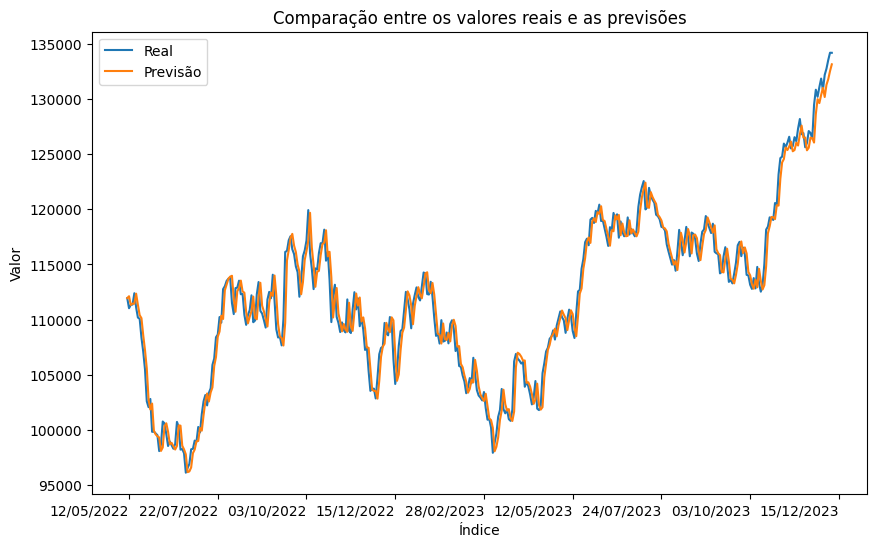

In [ ]:
# Função para carregar o melhor modelo e suas métricas
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics

# Caminho do melhor modelo salvo
results_dir = f'/content/drive/MyDrive/Mestrado/Resultados/LSTM/LSTM_p{patience}_bestresults'
best_model_path = os.path.join(results_dir, 'best_model')

# Carregar o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(best_model_path)

# Fazer previsões usando o melhor modelo
val_predict = best_model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Organizar datas

# Plotar os dados reais e as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Real')
plt.plot(y_predict, label='Previsão')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparação entre os valores reais e as previsões')
plt.legend()
# Ajustar o eixo x para exibir as datas corretamente
plt.xticks(np.arange(1, len(df_test['Date']), step=50), df_test['Date'][np.arange(df_test.index[0], df_test.index[-1], step=50)], ha='right')


# Caminho para salvar o arquivo
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/LSTM/LSTM_p{patience}_bestresults/LSTM_1a{runs}runs_p{patience}_comparison_plot_test.png'

# Criar os diretórios necessários
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Salvar o gráfico
plt.savefig(file_path)

# Mostrar o gráfico
plt.show()

# Carregar e testar novamente o melhor modelo para conferir o resultado

In [ ]:
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)  # Corrigi para ler a seed como inteiro
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics

In [ ]:
# Carrega o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(os.path.join(results_dir, 'best_model'))
print("Melhor MAPE:", best_metrics['MAPE'])

# Definir a seed para reproduzir os resultados
seed = best_metrics['Seed']
random.seed(seed)
tf.random.set_seed(seed)

Melhor MAPE: 0.9851376858611556


In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Mestrado/Resultados/LSTM/LSTM_p{patience}_bestresults/LSTM_1a{runs}runs_p{patience}_test.csv')

# Encontra a linha com o menor valor na coluna MAPE
min_mape_row = df.loc[df['MAPE'].idxmin()]

# Exibe o resultado
print(min_mape_row)


MAE     1.099514e+03
MSE     1.933889e+06
RMSE    1.390643e+03
MAPE    9.851377e-01
R2      9.673800e-01
Run     3.200000e+01
Name: 32, dtype: float64


In [ ]:
# Constrói o modelo LSTM com os melhores parâmetros
def build_model(n_layers, n_units_lstm1, dropout_rate_lstm1, activation_lstm1, n_units_dense, activation_dense, lookback):
    model = Sequential()
    model.add(LSTM(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 1)))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))
    return model

# Construir e compilar o modelo
model = build_model(n_layers, n_units_lstm1, dropout_rate_lstm1, activation_lstm1, n_units_dense, activation_dense, lookback)
model.compile(optimizer=best_optimizer, loss='mae')

# Definir os callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Treinar o modelo
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[early_stopping], verbose=1)

# Fazer previsões
val_predict = model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Calcular métricas
mae = mean_absolute_error(y_real, y_predict)
mse = mean_squared_error(y_real, y_predict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
r2 = r2_score(y_real, y_predict)

# Imprimir as métricas
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.4335 - val_loss: 0.3551
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.5630 - val_loss: 0.1242
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.2669 - val_loss: 0.2355
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.2296 - val_loss: 0.1372
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.2561 - val_loss: 0.5318
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.2951 - val_loss: 0.8826
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.3533 - val_loss: 0.0803
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0621 - val_loss: 0.1033
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1633 - val_loss: 0.2023
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.1203 - val_loss: 0.0802
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0873 - val_loss: 0.0741
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss

# Fim